<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/Waterpumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

competition: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

geographical data: https://heartbeat.fritz.ai/working-with-geospatial-data-in-machine-learning-ad4097c7228d

optional data quality report: https://github.com/benjimr/Data-Summarizer-for-a-Data-Quality-Report/blob/master/Reporter.py

data quality report: https://github.com/ColinLeverger/machine-learning-python

Tanzania maps: https://www.researchgate.net/figure/Map-of-the-United-Republic-of-Tanzania-human-population-density-map-and-Anopheles_fig1_328491768

###**1.1 Loading Libraries**

In [ ]:
pip install fancyimpute

In [601]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

from collections import Counter
import math
import scipy.stats as ss

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

#data cleaning
from sklearn.impute import SimpleImputer
from fancyimpute import KNN 
from fancyimpute import IterativeImputer
import missingno as msno
from sklearn.preprocessing import OneHotEncoder


#modelling
from sklearn.model_selection import train_test_split

In [54]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

###**1.2 Loading data**

In [55]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:

train_labels = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/train_labels.csv')
train_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/train_values.csv', parse_dates = ['date_recorded' ])
test_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/test_values.csv', parse_dates = ['date_recorded' ])

In [57]:
#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')


In [58]:
#concatenate train and test for easier data minipulation
raw = pd.concat([train, test_values])
raw.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.0    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional         0.0    2013-01-28        Unicef         263   
4  19728      functional         0.0    2011-07-13   Action In A           0   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe mul

In [ ]:
#convert faulty datatypes
raw[['region_code','district_code', 'num_private']] = raw[['region_code','district_code', 'num_private']].astype('object')


In [ ]:
raw.dtypes

id                                int64
status_group                     object
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                      object
basin                            object
subvillage                       object
region                           object
region_code                      object
district_code                    object
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64


In [ ]:
#divide features into numerical and cateogorical for ease of describtion
numerical = [ 'amount_tsh', 'date_recorded', 'gps_height',  'longitude', 'latitude', 
             'population' , 'construction_year'  ]

categorical = ['status_group', 'funder', 'installer','wpt_name','num_private',  'basin', 'subvillage', 'region', 'region_code',
               'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 
               'scheme_name', 'permit', 'extraction_type', 'extraction_type_group','extraction_type_class',
               'management', 'management_group', 'payment','payment_type', 'water_quality', 'quality_group', 'quantity',
               'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


print("Number of numerical features: {}".format(len(numerical)))
print("Number of categorical features: {}".format(len(categorical)))


Number of numerical features: 7
Number of categorical features: 33


In [ ]:
#ensure that all categorical data are strings isntead of mixed types
raw[categorical] = raw[categorical].astype('str')

##**2 Exploring the data**

###**2.1. Numerical data**

In [ ]:
raw[numerical].head()

amount_tsh date_recorded  gps_height  longitude   latitude  population  \
0      6000.0    2011-03-14        1390  34.938093  -9.856322         109   
1         0.0    2013-03-06        1399  34.698766  -2.147466         280   
2        25.0    2013-02-25         686  37.460664  -3.821329         250   
3         0.0    2013-01-28         263  38.486161 -11.155298          58   
4         0.0    2011-07-13           0  31.130847  -1.825359           0   

  construction_year  
0              1999  
1              2010  
2              2009  
3              1986  
4                 0

In [ ]:
#raw[numerical].describe()

In [ ]:
#print percentage of missing numerical datapoints
#round(raw[numerical].isna().sum()*100/raw[numerical].isna().count()).sort_values(ascending=False)

In [ ]:
#explore the cardinality of numerical features
#for column in raw[numerical]:
  #unique = raw[column].nunique()
  #print(column,":", unique)
 

####**2.1.1 Data Quality report**


In [ ]:
data_types = pd.DataFrame(
    raw[numerical].dtypes,
    columns=['Data Type'])

missing_data = pd.DataFrame(
    raw[numerical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values']
)
for row in list(raw[numerical].columns.values):
    unique_values.loc[row] = [raw[numerical][row].nunique()]

maximum_values = pd.DataFrame(
    columns=['Maximum Value'])
for row in list(raw[numerical].columns.values):
    maximum_values.loc[row] = [raw[numerical][row].max()]

minimum_values = pd.DataFrame(
    columns=['Minimum Value'])
for row in list(raw[numerical].columns.values):
    minimum_values.loc[row] = [raw[numerical][row].min()]

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(raw[numerical].columns.values):
    count_values.loc[row] = [raw[numerical][row].count()]

mean_values = pd.DataFrame(
    columns=['Mean Value'])
for row in list(raw[numerical].columns.values):
    mean_values.loc[row] = [raw[numerical][row].mean()]

quartile_1 = pd.DataFrame(
    columns=['1st Quartile'])
for row in list(raw[numerical].columns.values):
    quartile_1.loc[row] = [raw[numerical][row].quantile(0.25)]

median = pd.DataFrame(
    columns=['Median'])
for row in list(raw[numerical].columns.values):
    median.loc[row] = [raw[numerical][row].quantile(0.5)]

quartile_3 = pd.DataFrame(
    columns=['3rd Quartile'])
for row in list(raw[numerical].columns.values):
    quartile_3.loc[row] = [raw[numerical][row].quantile(0.75)]

dq_report_num = data_types.join(count_values).join(missing_data).join(unique_values).join(minimum_values).join(maximum_values).join(mean_values).join(quartile_1).join(median).join(quartile_3)
dq_report_num['Missing %'] = (dq_report_num['Missing Values'] / len(raw[numerical]) *100)
dq_report_num

Data Type Count Value  Missing Values Unique Values  \
amount_tsh                float64       74250               0           102   
date_recorded      datetime64[ns]       74250               0           369   
gps_height                  int64       74250               0          2456   
longitude                 float64       74250               0         71870   
latitude                  float64       74250               0         71869   
population                  int64       74250               0          1128   
construction_year           int64       74250               0            55   

                         Minimum Value        Maximum Value  \
amount_tsh                           0               350000   
date_recorded      2001-03-26 00:00:00  2013-12-03 00:00:00   
gps_height                         -90                 2777   
longitude                            0              40.3452   
latitude                      -11.6494               -2e-08   
population                           0                30500   
construction_year                    0                 2013   

                                      Mean Value         1st Quartile  \
amount_tsh                               318.686                    0   
date_recorded      2012-03-28 09:51:49.527267072  2011-04-01 00:00:00   
gps_height                               665.667                    0   
longitude                                34.0743              33.0868   
latitude                                -5.70177             -8.52567   
population                               180.751                    0   
construction_year                        1298.46                    0   

                                Median         3rd Quartile  Missing %  
amount_tsh                           0                   20        0.0  
date_recorded      2012-10-10 00:00:00  2013-02-09 00:00:00        0.0  
gps_height                         364                 1317        0.0  
longitude                      34.9075              37.1817        0.0  
latitude                      -5.02654             -3.32506        0.0  
population                          25                  215        0.0  
construction_year                 1986                 2004        0.0

In [ ]:
unique = raw[categorical].apply(lambda x: len(x.unique()))
unique.head()

status_group        4
funder           2141
installer        2411
wpt_name        45684
num_private        68
dtype: int64

In [ ]:
median = raw[categorical].apply(lambda x: (x.mode()))
median.head()

status_group                  funder installer wpt_name num_private  \
0   functional  Government Of Tanzania       DWE     none           0   

           basin subvillage  region region_code district_code     lga   ward  \
0  Lake Victoria    Shuleni  Iringa          11             1  Njombe  Igosi   

  public_meeting              recorded_by scheme_management scheme_name  \
0           True  GeoData Consultants Ltd               VWC           K   

  permit extraction_type extraction_type_group extraction_type_class  \
0   True         gravity               gravity               gravity   

  management management_group    payment payment_type water_quality  \
0        vwc       user-group  never pay    never pay          soft   

  quality_group quantity quantity_group  source source_type source_class  \
0          good   enough         enough  spring      spring  groundwater   

      waterpoint_type waterpoint_type_group  construction_year  
0  communal standpipe    communal standpipe                  0

#### **2.1.2 Density Plot**

In [ ]:
def kdeplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,12))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.kdeplot(data = dataset, x =feature[plot] , ax = axes[i][j],    shade = True, color  = "black" )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             plot +=1

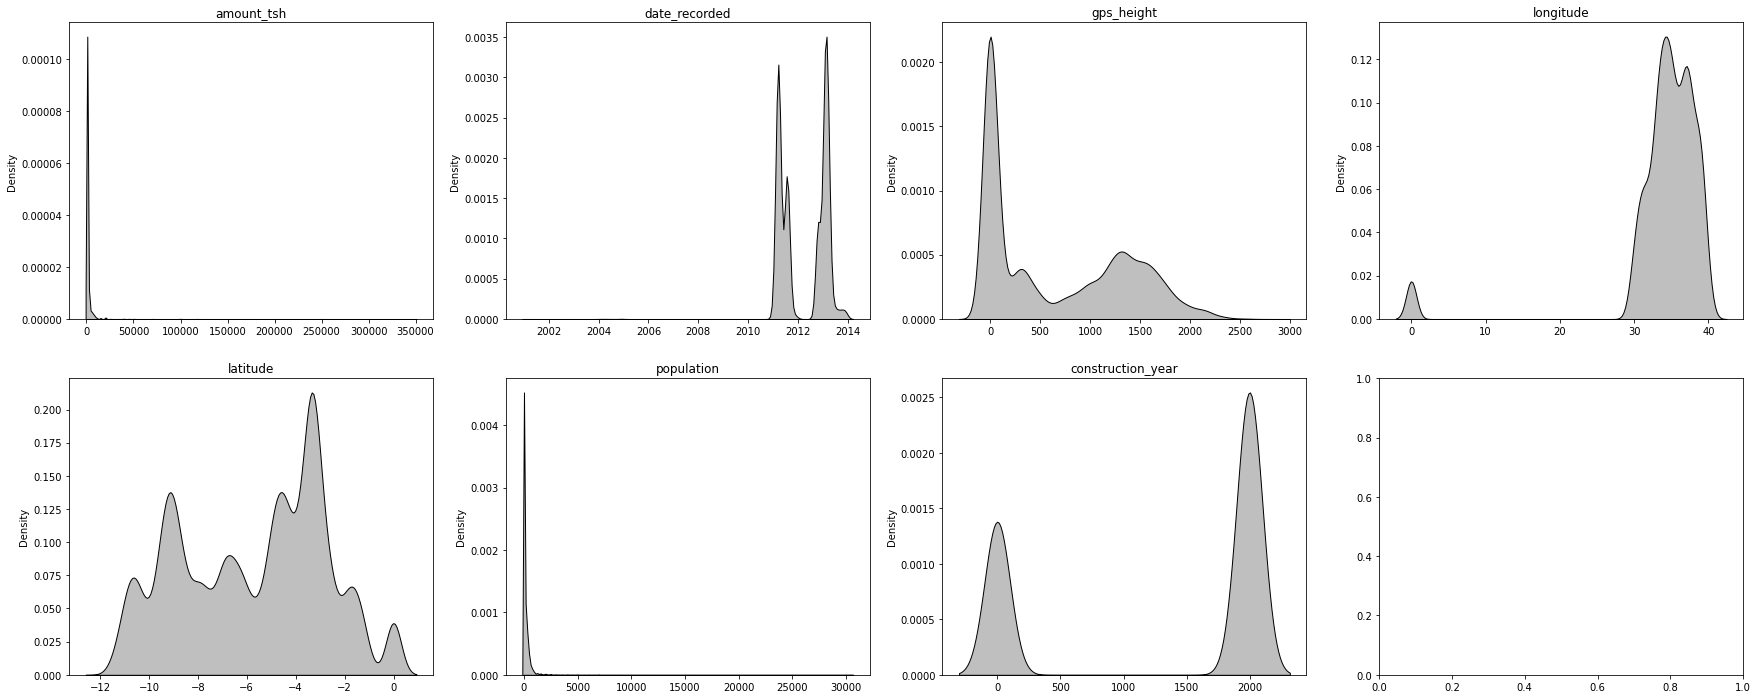

In [ ]:
try:
    kdeplotter(raw, raw[numerical].columns, 2,4)
except IndexError: 
    pass 

#### **2.1.3 Histograms**

In [ ]:
def histplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,10))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.histplot(data = dataset, x =feature[plot] , ax = axes[i][j], color  = "chocolate", bins = 30 )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             plot +=1

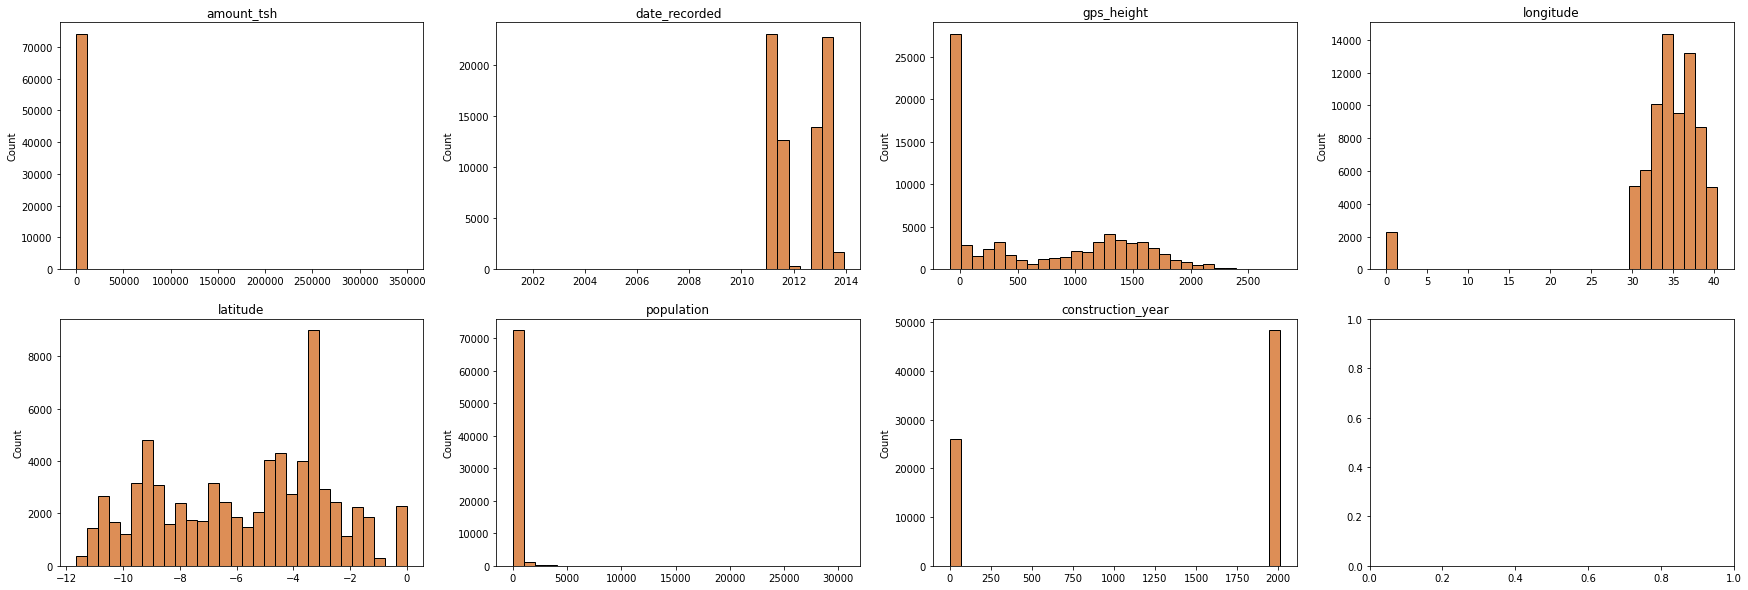

In [ ]:
try:
    histplotter (raw, raw[numerical].columns, 2,4)
except IndexError: 
    pass 


#### **2.1.4 Pairplots**

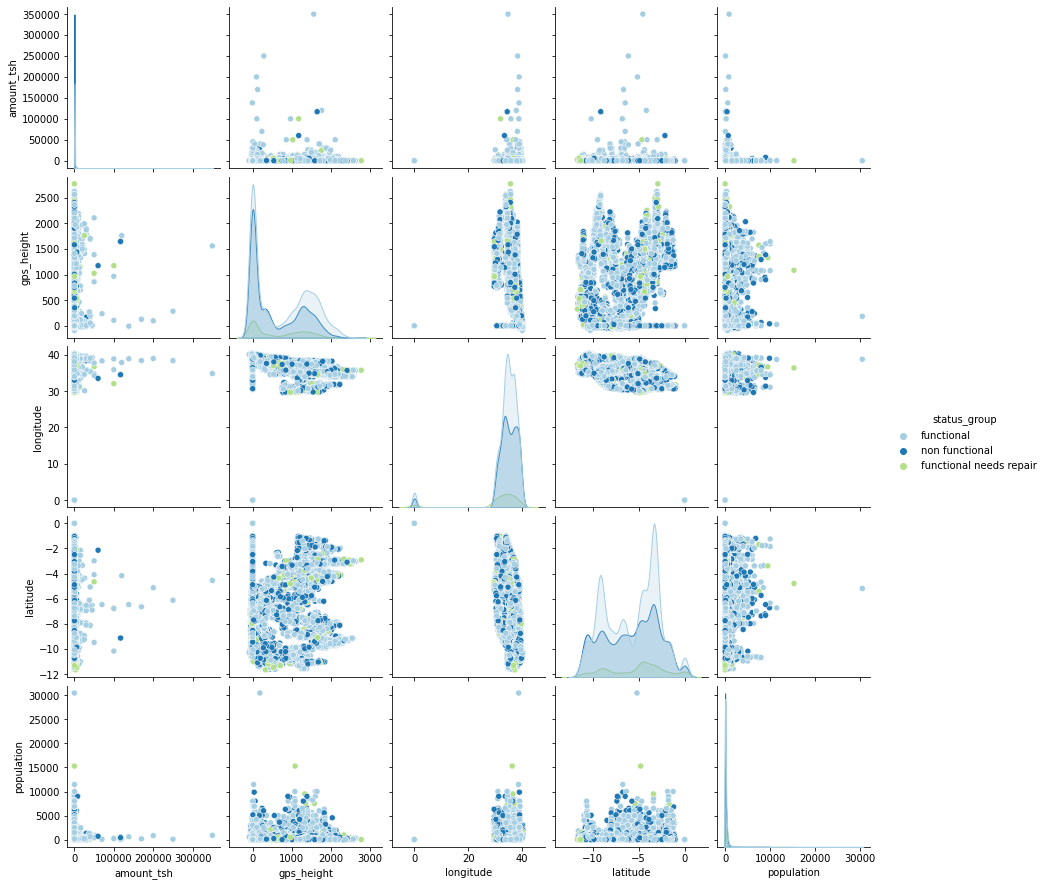

In [ ]:
numerical_pair = [ 'amount_tsh', 'gps_height',  'longitude', 'latitude', 
             'population',  'status_group' ]

sns.pairplot(raw[numerical_pair], hue = 'status_group', kind = 'scatter', palette = 'Paired')

#### **2.1.5 Boxplots**

In [285]:
def boxplotter (feature, data):
  ax =sns.boxplot(x = "status_group",  y=feature,  data = data, palette = "Paired")
  ax.set(xlabel = "")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.show()

In [ ]:
raw[numerical].columns.tolist()

['amount_tsh',
 'date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'construction_year']

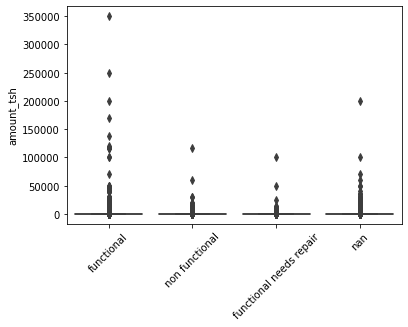

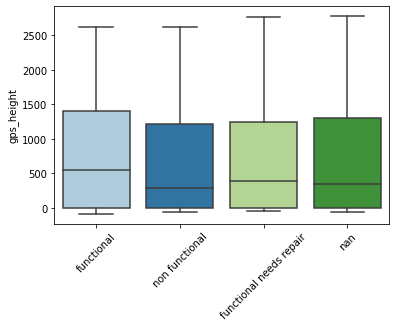

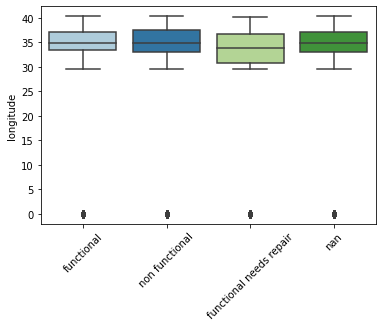

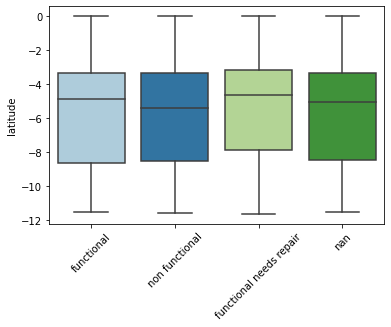

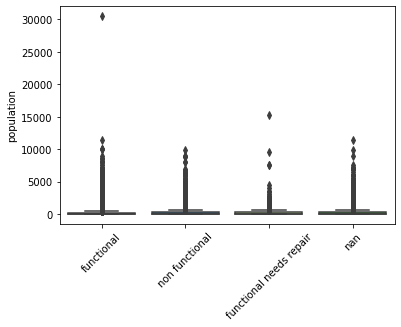

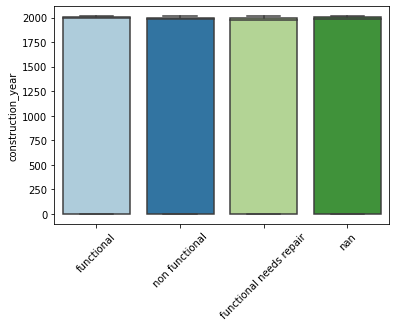

In [ ]:
numerical_list = ['amount_tsh','gps_height','longitude','latitude','population','construction_year']

for item in numerical_list:
  boxplotter(item, raw)

#### **2.1.5 Other visualizatons**

array(['Lake Nyasa', 'Lake Victoria', 'Pangani',
       'Ruvuma / Southern Coast', 'Internal', 'Lake Tanganyika',
       'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'], dtype=object)

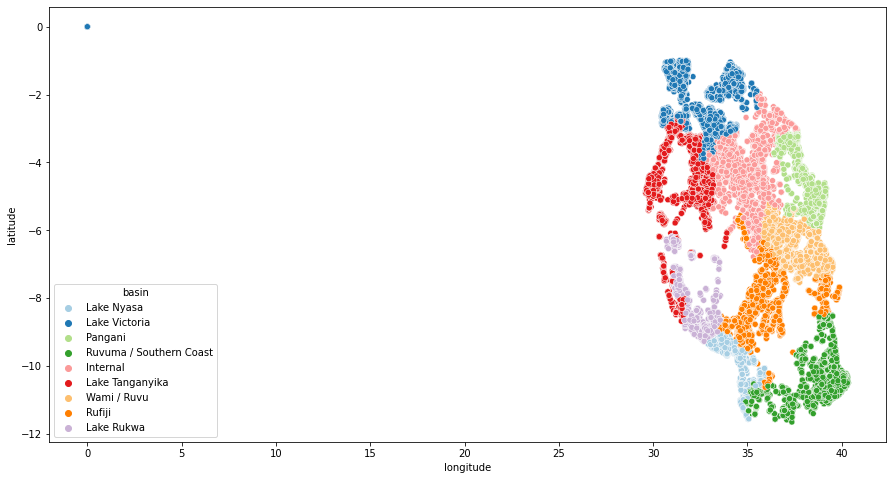

In [ ]:
plt.figure(figsize = (15,8))
sns.scatterplot(x= raw['longitude'], y = raw['latitude'], hue = raw['basin'], palette='Paired')
plt.show()


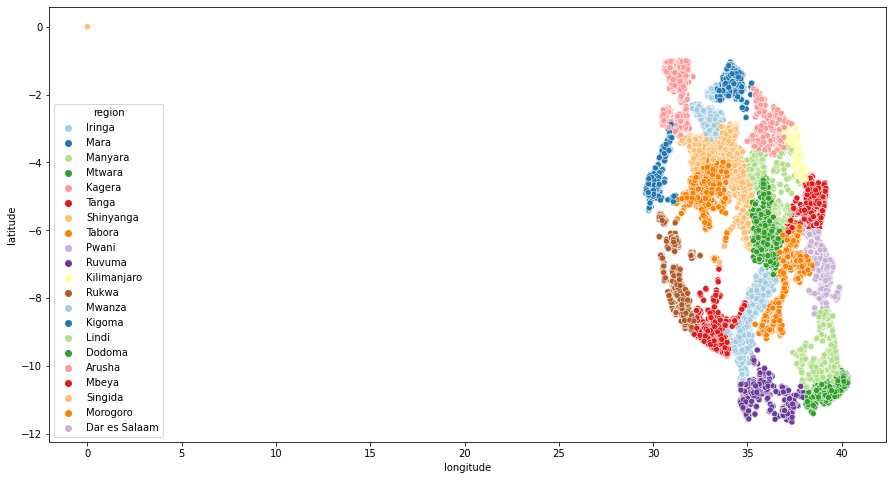

In [ ]:
plt.figure(figsize = (15,8))
sns.scatterplot(x= raw['longitude'], y = raw['latitude'], hue = raw['region'], palette='Paired')
plt.show()


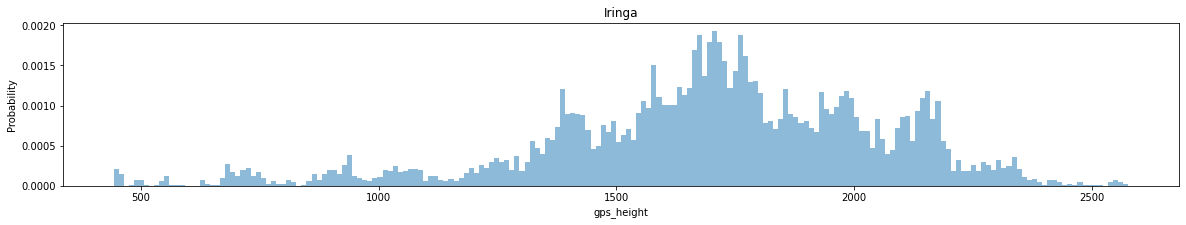

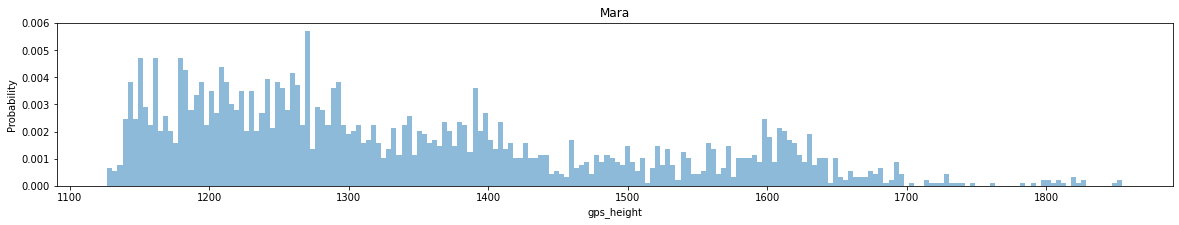

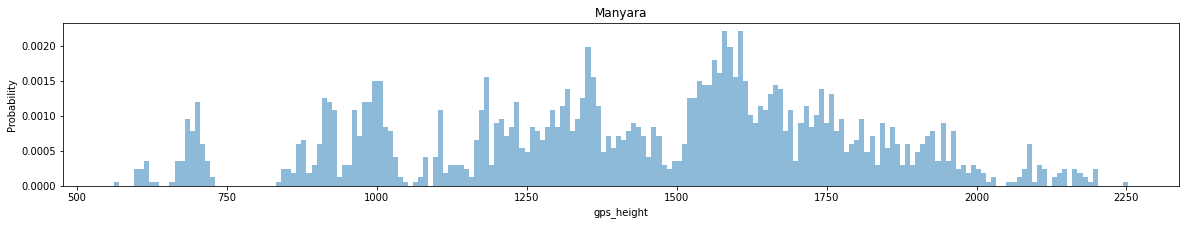

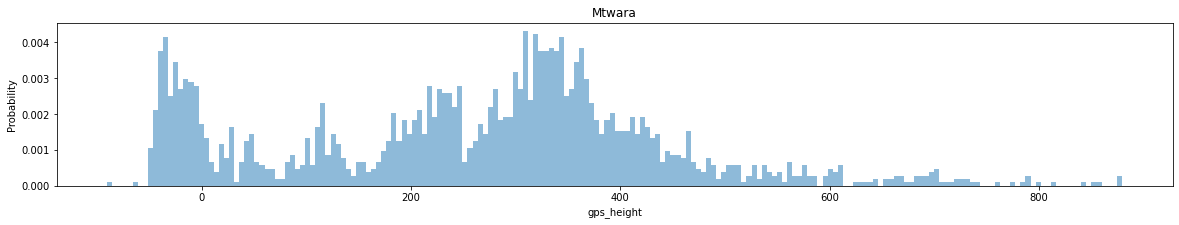

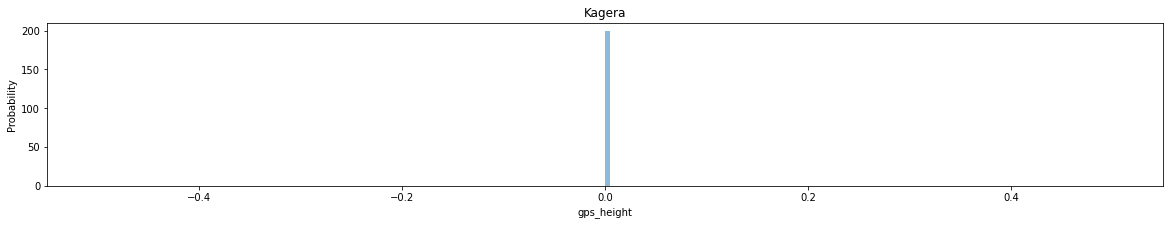

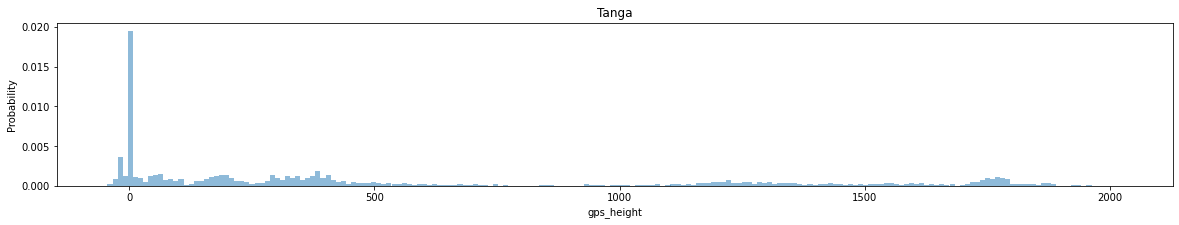

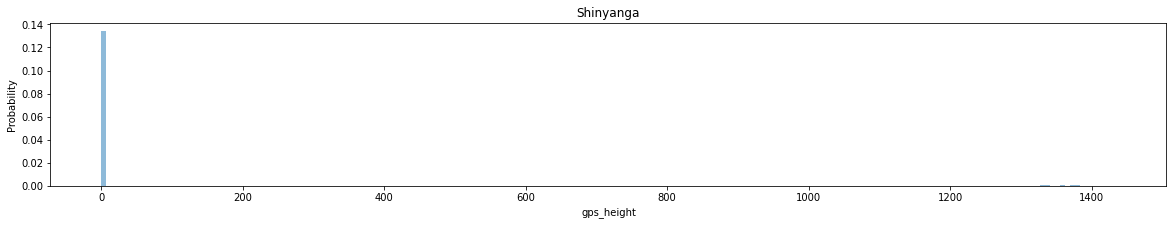

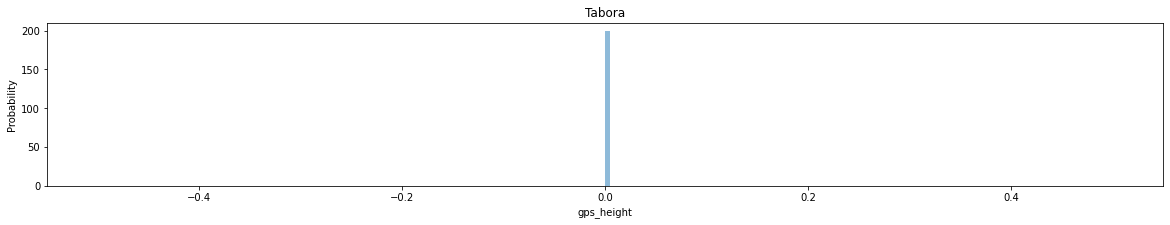

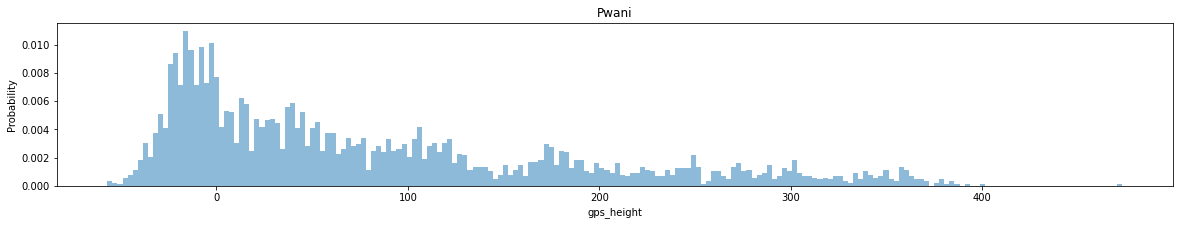

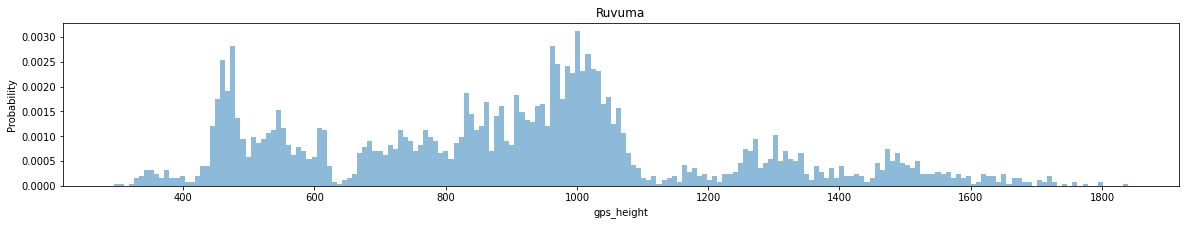

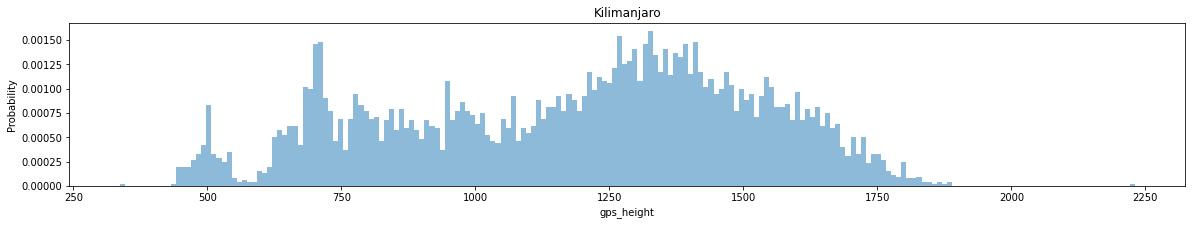

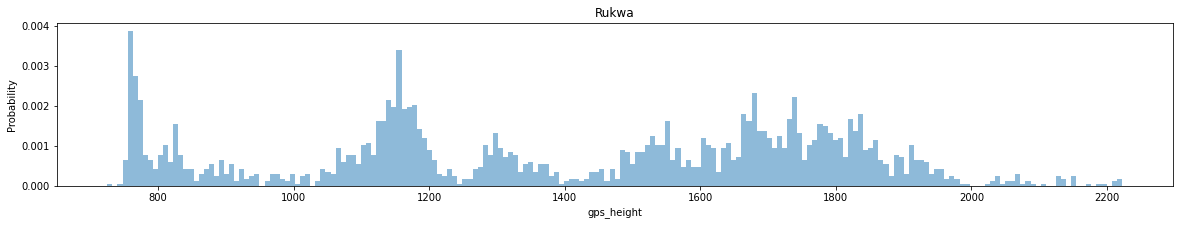

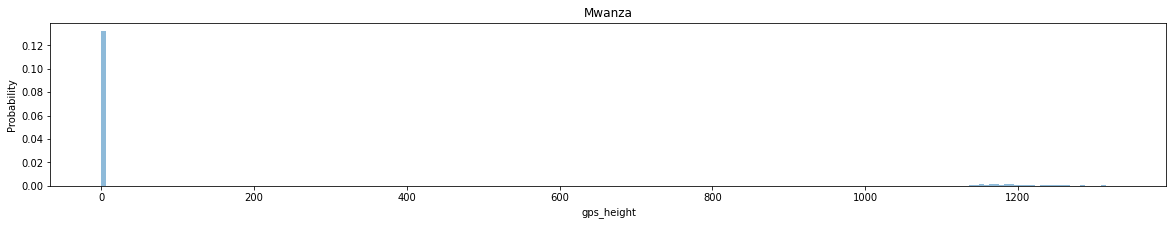

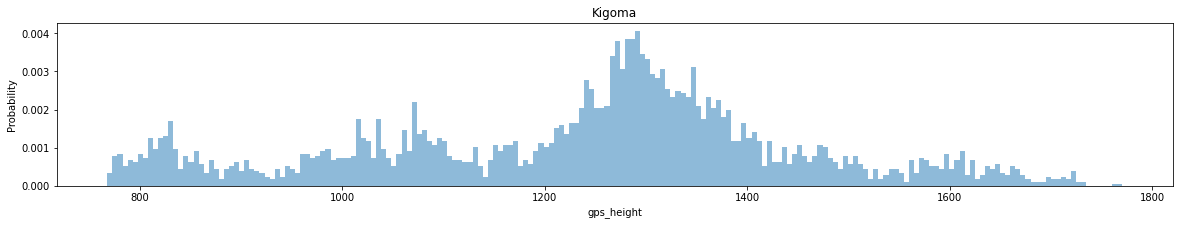

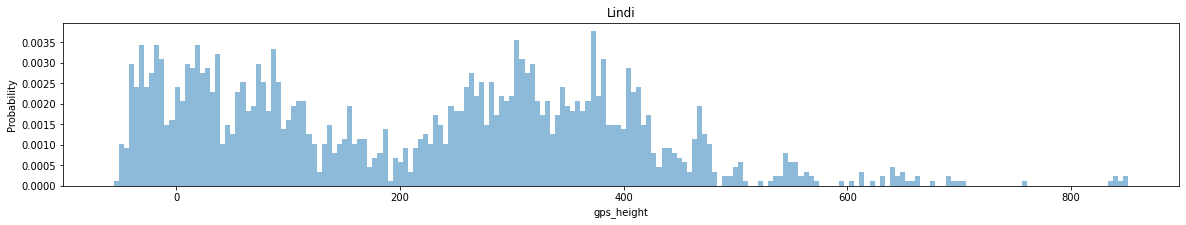

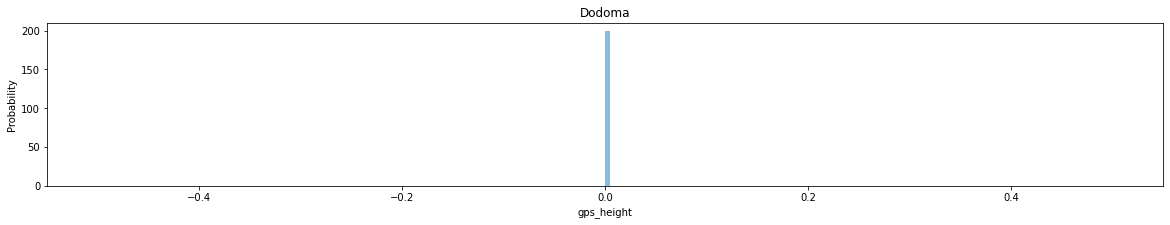

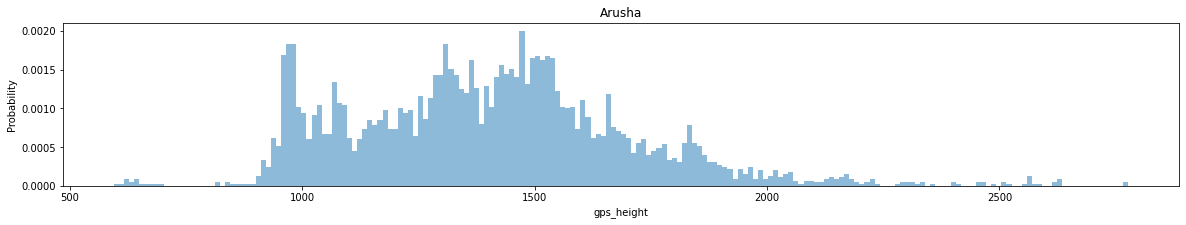

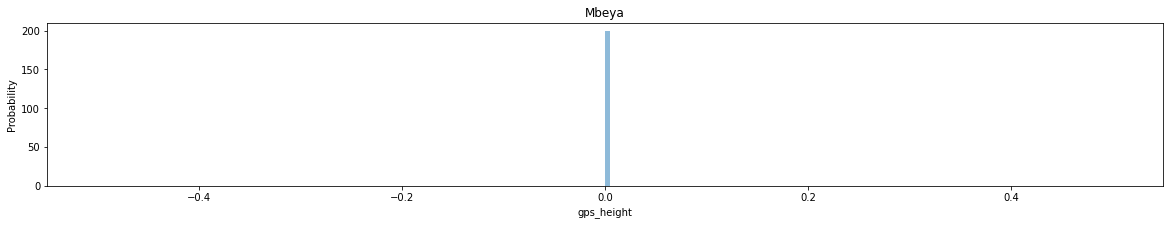

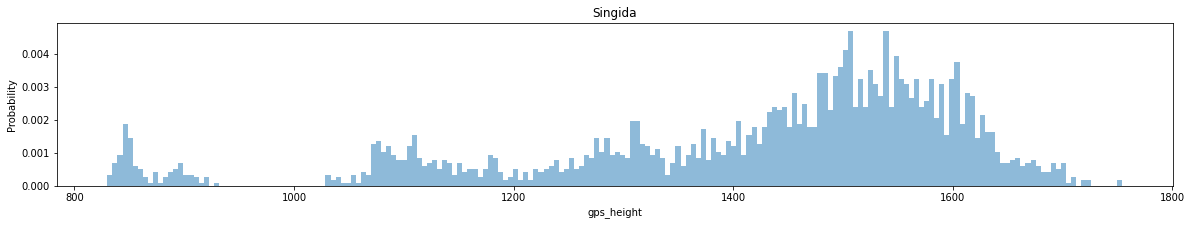

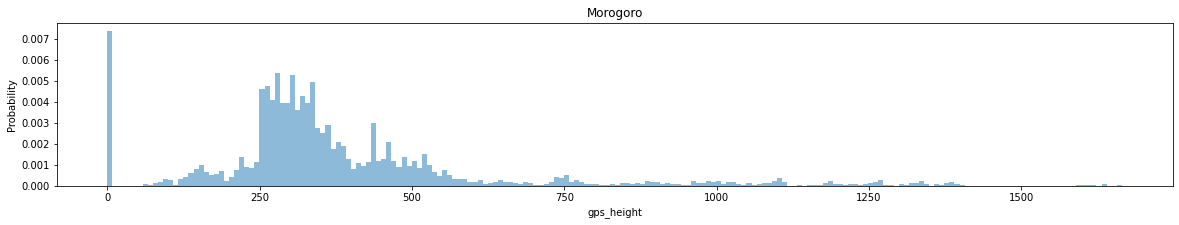

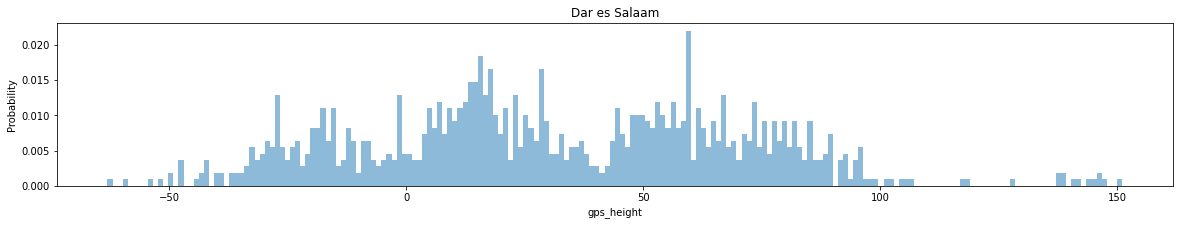

In [ ]:
# Distribution of gps_height by region

for x in raw['region'].unique().tolist():
    if raw[raw['region']==x]['gps_height'].count() > 0:
        %matplotlib inline
        plt.rcParams["figure.figsize"] = (20,3)
        plt.hist(raw[raw['region']==x]['gps_height'].to_list(), density=True, bins=200, alpha=0.5)
        plt.ylabel('Probability')
        plt.xlabel('gps_height')
        plt.title(x)
        plt.show()

#### **2.1.6 Correlations**

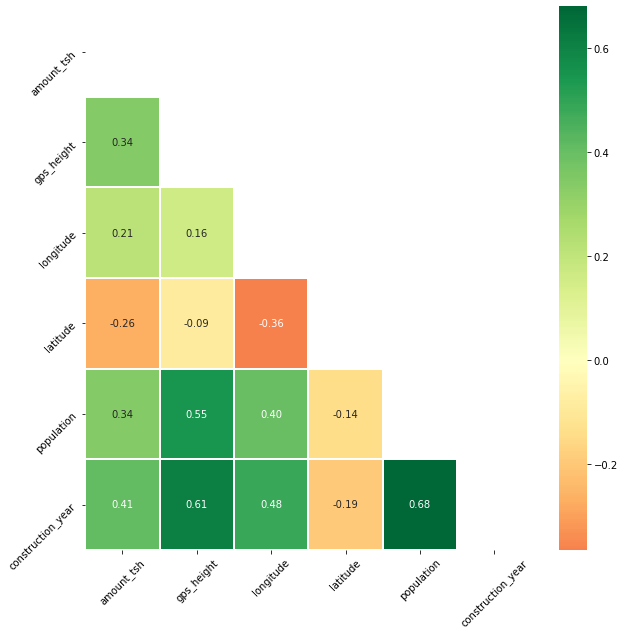

In [ ]:
# Create the correlation matrix
corr_mean = raw[numerical].corr(method = 'spearman')

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mean, dtype=bool))

# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr_mean, mask=mask, cmap= "RdYlGn", center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

#note, these correlations aren't too usefull yet because of the many zero's and outliers

###**2.2 Categorical data**

In [ ]:
raw[categorical] = raw[categorical].astype('str')

In [ ]:
raw[categorical].head()

status_group        funder     installer              wpt_name  \
0      functional         Roman         Roman                  none   
1      functional       Grumeti       GRUMETI              Zahanati   
2      functional  Lottery Club  World vision           Kwa Mahundi   
3  non functional        Unicef        UNICEF  Zahanati Ya Nanyumbu   
4      functional   Action In A       Artisan               Shuleni   

  num_private                    basin  subvillage   region region_code  \
0           0               Lake Nyasa    Mnyusi B   Iringa          11   
1           0            Lake Victoria     Nyamara     Mara          20   
2           0                  Pangani     Majengo  Manyara          21   
3           0  Ruvuma / Southern Coast  Mahakamani   Mtwara          90   
4           0            Lake Victoria  Kyanyamisa   Kagera          18   

  district_code        lga        ward public_meeting  \
0             5     Ludewa    Mundindi           True   
1             2  Serengeti       Natta            nan   
2             4  Simanjiro     Ngorika           True   
3            63   Nanyumbu    Nanyumbu           True   
4             1    Karagwe  Nyakasimbi           True   

               recorded_by scheme_management                  scheme_name  \
0  GeoData Consultants Ltd               VWC                        Roman   
1  GeoData Consultants Ltd             Other                          nan   
2  GeoData Consultants Ltd               VWC  Nyumba ya mungu pipe scheme   
3  GeoData Consultants Ltd               VWC                          nan   
4  GeoData Consultants Ltd               nan                          nan   

  permit extraction_type extraction_type_group extraction_type_class  \
0  False         gravity               gravity               gravity   
1   True         gravity               gravity               gravity   
2   True         gravity               gravity               gravity   
3   True     submersible           submersible           submersible   
4   True         gravity               gravity               gravity   

  management management_group         payment payment_type water_quality  \
0        vwc       user-group    pay annually     annually          soft   
1        wug       user-group       never pay    never pay          soft   
2        vwc       user-group  pay per bucket   per bucket          soft   
3        vwc       user-group       never pay    never pay          soft   
4      other            other       never pay    never pay          soft   

  quality_group      quantity quantity_group                source  \
0          good        enough         enough                spring   
1          good  insufficient   insufficient  rainwater harvesting   
2          good        enough         enough                   dam   
3          good           dry            dry           machine dbh   
4          good      seasonal       seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group  
0    communal standpipe  
1    communal standpipe  
2    communal standpipe  
3    communal standpipe  
4    communal standpipe

####**2.2.1 Data Quality report**

In [ ]:
#for feature in raw[categorical].columns:
   # uniq = np.unique(raw[categorical][feature])
   # print('{}: {} distinct values -  {}'.format(feature,len(uniq),uniq))

In [ ]:
# print absolute number  of missing continious data points
#print(raw[categorical].isna().sum().sort_values(ascending=False))

In [ ]:
#print percentage of missing numerical datapoints
#round(raw[categorical].isna().sum()*100/raw[categorical].isna().count()).sort_values(ascending=False)

In [ ]:
#print percentage of missing numerical datapoints
#round(raw[categorical].isna().sum()*100/raw[categorical].isna().count()).sort_values(ascending=False)

In [ ]:
#value = raw['status_group'].value_counts()
#value

In [ ]:
#explore the cardinality of numerical features
#for column in raw[categorical]:
  #mode = raw[column].value_counts()
  #print(mode)
 

In [ ]:
#how many unique gps coordinates are there?
#temp = raw.copy()
#temp['location'] = temp['longitude'].astype(str) + '-' + temp['latitude'].astype(str)
#temp['location'].nunique()


In [ ]:
data_types = pd.DataFrame(
    raw[categorical].dtypes,
    columns=['Data Type'])

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(raw[categorical].columns.values):
    count_values.loc[row] = [raw[categorical][row].count()]

missing_data = pd.DataFrame(
    raw[categorical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values'])
for row in list(raw[categorical].columns.values):
    unique_values.loc[row] = [raw[categorical][row].nunique()]

mode_values = pd.DataFrame(
    columns=['Mode'])
for row in list(raw[categorical].columns.values):
    mode_values.loc[row] = [raw[categorical][row].mode()[0]]
    mode = mode_values.loc[row]

#mode frequency
listModeFreq = []
for row in categorical:
    mode = raw[row].mode().iat[0]
    ModeFreq = raw[row].value_counts()[mode]
    #print(x, mode, raw[x].value_counts()[mode])
    listModeFreq .append(ModeFreq )
listModeFreq  = np.array(listModeFreq )

dq_report_cat = data_types.join(count_values).join(missing_data).join(unique_values).join(mode_values)
dq_report_cat['Mode freq.'] = listModeFreq 
dq_report_cat['Mode %'] = (dq_report_cat['Mode freq.'] / dq_report_cat['Count Value']*100) 
dq_report_cat['Missing %'] = (dq_report_cat['Missing Values'] / len(raw[categorical]) *100)
dq_report_cat 

Data Type Count Value  Missing Values Unique Values  \
status_group             object       74250               0             4   
funder                   object       74250               0          2141   
installer                object       74250               0          2411   
wpt_name                 object       74250               0         45684   
num_private              object       74250               0            68   
basin                    object       74250               0             9   
subvillage               object       74250               0         21426   
region                   object       74250               0            21   
region_code              object       74250               0            27   
district_code            object       74250               0            20   
lga                      object       74250               0           125   
ward                     object       74250               0          2098   
public_meeting           object       74250               0             3   
recorded_by              object       74250               0             1   
scheme_management        object       74250               0            13   
scheme_name              object       74250               0          2869   
permit                   object       74250               0             3   
extraction_type          object       74250               0            18   
extraction_type_group    object       74250               0            13   
extraction_type_class    object       74250               0             7   
management               object       74250               0            12   
management_group         object       74250               0             5   
payment                  object       74250               0             7   
payment_type             object       74250               0             7   
water_quality            object       74250               0             8   
quality_group            object       74250               0             6   
quantity                 object       74250               0             5   
quantity_group           object       74250               0             5   
source                   object       74250               0            10   
source_type              object       74250               0             7   
source_class             object       74250               0             3   
waterpoint_type          object       74250               0             7   
waterpoint_type_group    object       74250               0             6   

                                          Mode  Mode freq.    Mode %  \
status_group                        functional       32259   43.4465   
funder                  Government Of Tanzania       11299   15.2175   
installer                                  DWE       21751   29.2943   
wpt_name                                  none        4440    5.9798   
num_private                                  0       73299   98.7192   
basin                            Lake Victoria       12871   17.3347   
subvillage                             Shuleni         646  0.870034   
region                                  Iringa        6599   8.88754   
region_code                                 11        6608   8.89966   
district_code                                1       15299   20.6047   
lga                                     Njombe        3128   4.21279   
ward                                     Igosi         386  0.519865   
public_meeting                            True       63749   85.8572   
recorded_by            GeoData Consultants Ltd       74250       100   
scheme_management                          VWC       45917   61.8411   
scheme_name                                nan       35258   47.4855   
permit                                    True       48606   65.4626   
extraction_type                        gravity       33263   44.7987   
extraction_type_group              

In [ ]:
#check how region_code and region relate
for x in raw['region_code'].unique():
  check = raw[raw['region_code']==x]
  count = check['region'].value_counts()
  print(x)
  print(count)

11
Iringa       6599
Shinyanga       9
Name: region, dtype: int64
20
Mara    2451
Name: region, dtype: int64
21
Manyara    1972
Name: region, dtype: int64
90
Mtwara    1133
Name: region, dtype: int64
18
Kagera    4174
Lindi        9
Name: region, dtype: int64
4
Tanga    3145
Name: region, dtype: int64
17
Shinyanga    6262
Mwanza         72
Name: region, dtype: int64
14
Tabora       2466
Shinyanga      22
Name: region, dtype: int64
60
Pwani    1298
Name: region, dtype: int64
10
Ruvuma    3306
Name: region, dtype: int64
3
Kilimanjaro    5494
Name: region, dtype: int64
15
Rukwa    2242
Name: region, dtype: int64
19
Mwanza    3824
Name: region, dtype: int64
16
Kigoma    3533
Name: region, dtype: int64
80
Lindi    1536
Name: region, dtype: int64
1
Dodoma    2779
Name: region, dtype: int64
6
Pwani    2032
Name: region, dtype: int64
2
Arusha    3709
Name: region, dtype: int64
12
Mbeya     5758
Mwanza       1
Name: region, dtype: int64
13
Singida    2536
Name: region, dtype: int64
5
Morogoro  

####**2.2.2 Count plots**

In [ ]:
#create a list of categorical features with low cardinality
low_cardinal = dq_report_cat[dq_report_cat['Unique Values'] <=50]
cardinal_index = low_cardinal.index
low_cardinal_list = cardinal_index.to_list()

In [ ]:
def countplotter (dataset, feature, rows, columns):
    fig, axes = plt.subplots(nrows=rows,ncols=columns, figsize = (30,60))
    plot = 0
    for i in range(rows):
        for j in range(columns):
             ax = sns.countplot(data = dataset, x =feature[plot] , ax = axes[i][j], palette='YlOrRd' )
             ax.set_title(feature[plot])
             ax.set_xlabel("")
             ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=9)
             plot +=1

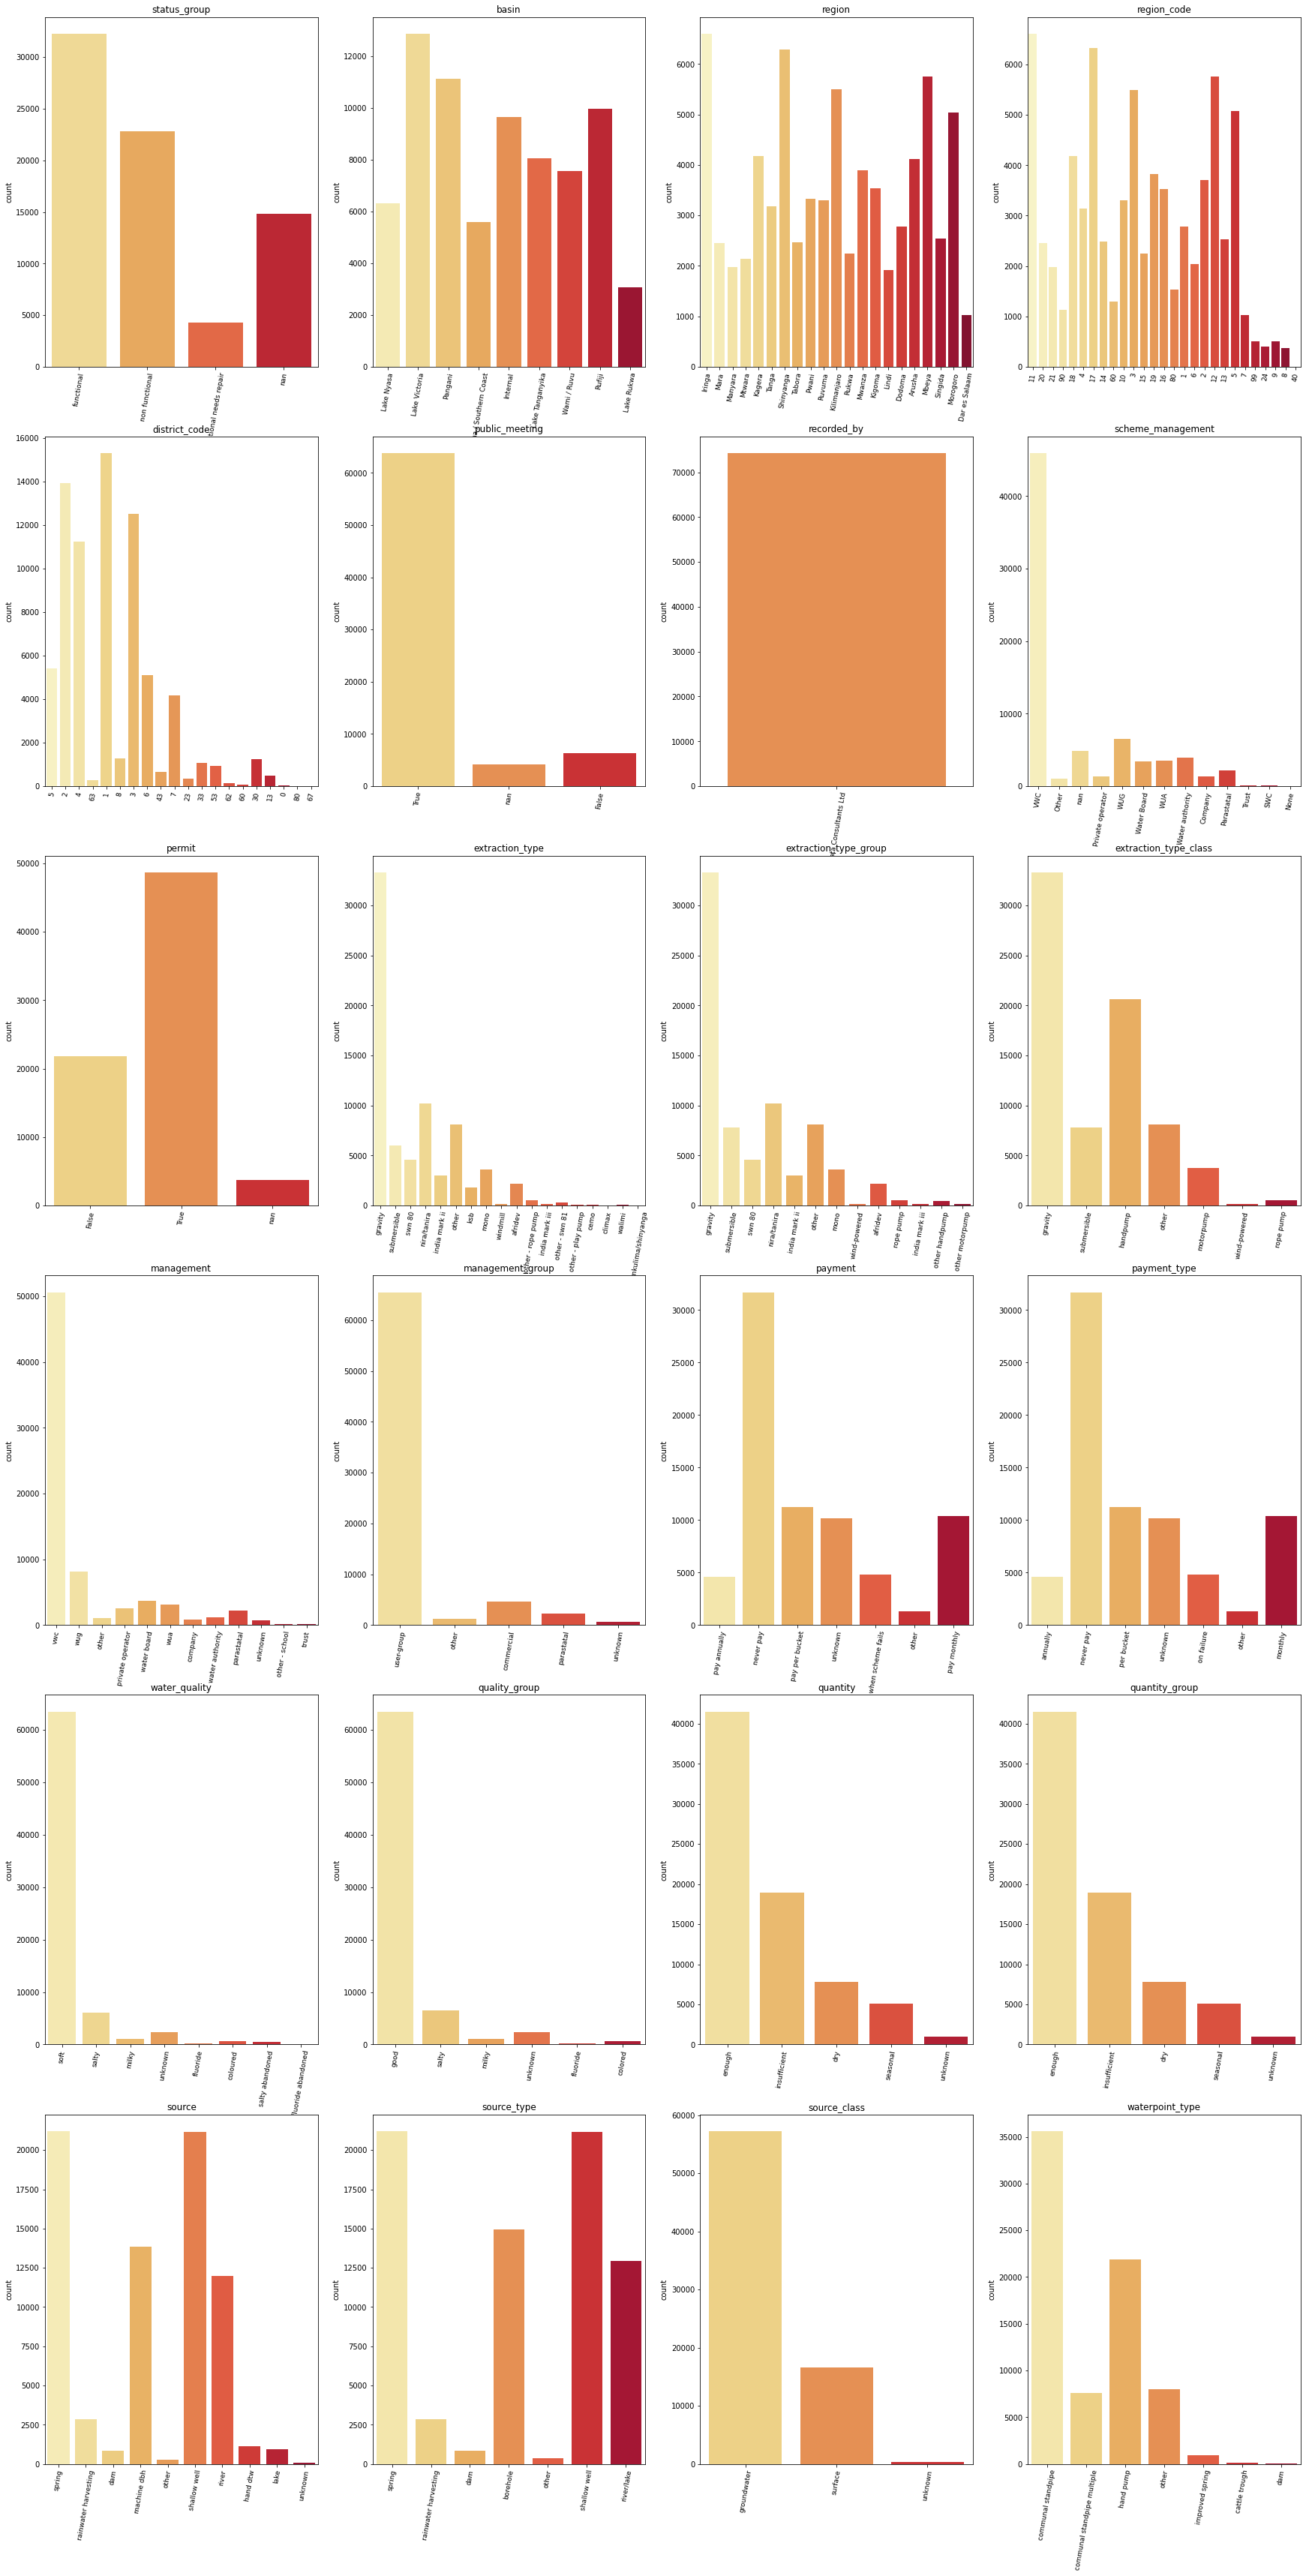

In [ ]:
countplotter (raw, raw[low_cardinal_list].columns, 6,4)

####**2.2.2 Barplots**

In [ ]:
def barplotter (dataset, feature):
  ax1 = sns.displot(dataset, x =feature,  stat = 'density', discrete = True, color = 'black')
  ax1.set(title=feature, xlabel = "")
  ax1.set_xticklabels( rotation = 80)
  ax2 = sns.displot(dataset, x =feature, col = 'status_group', stat = 'density', discrete = True)
  ax2.set(xlabel = "")
  ax2.set_xticklabels( rotation = 80)
  plt.show()
  

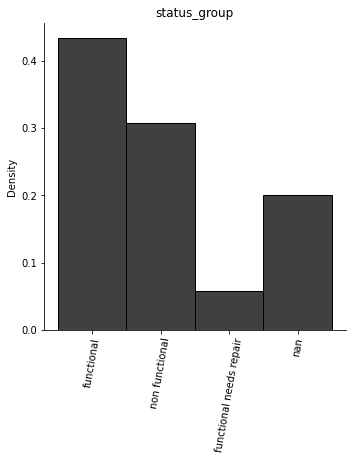

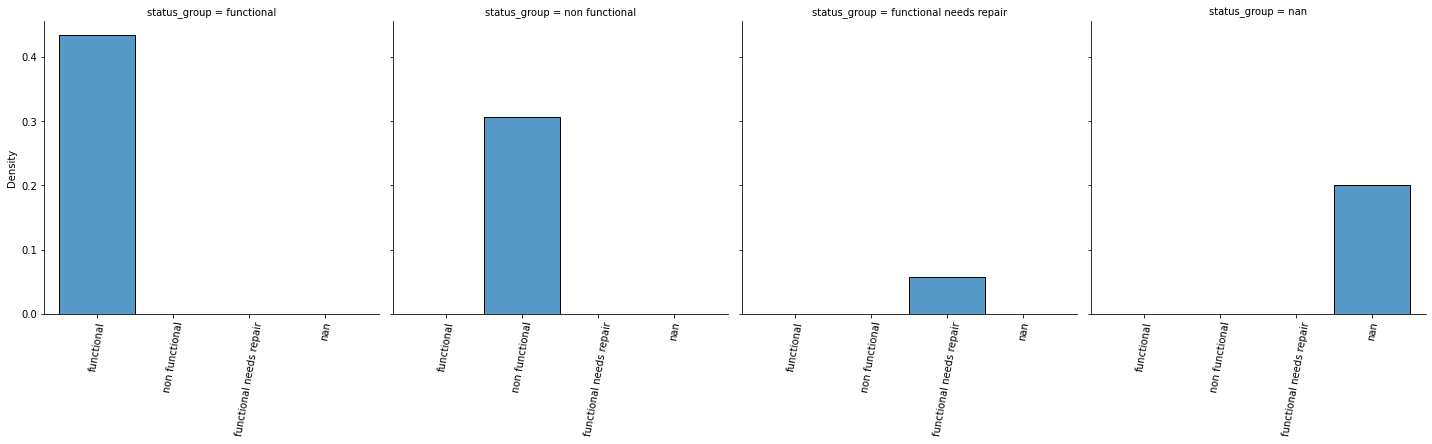

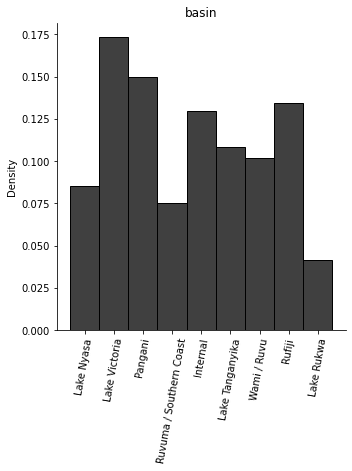

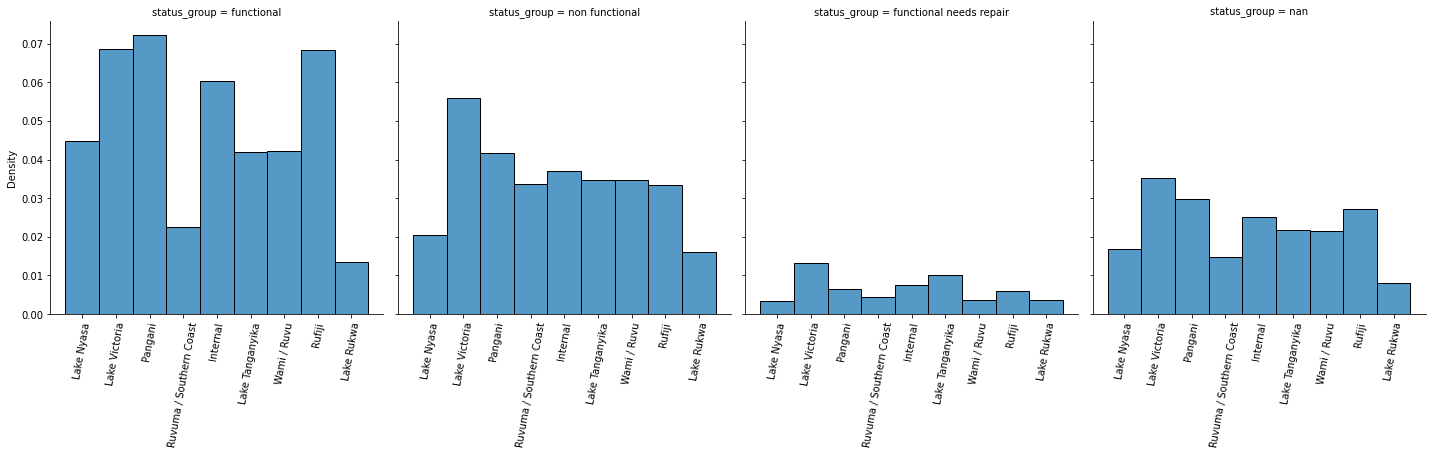

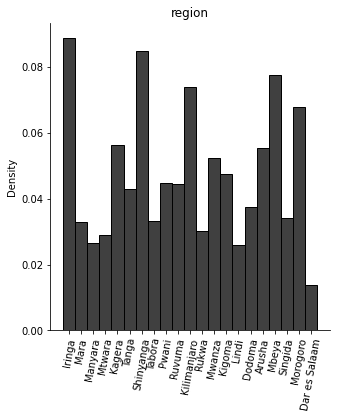

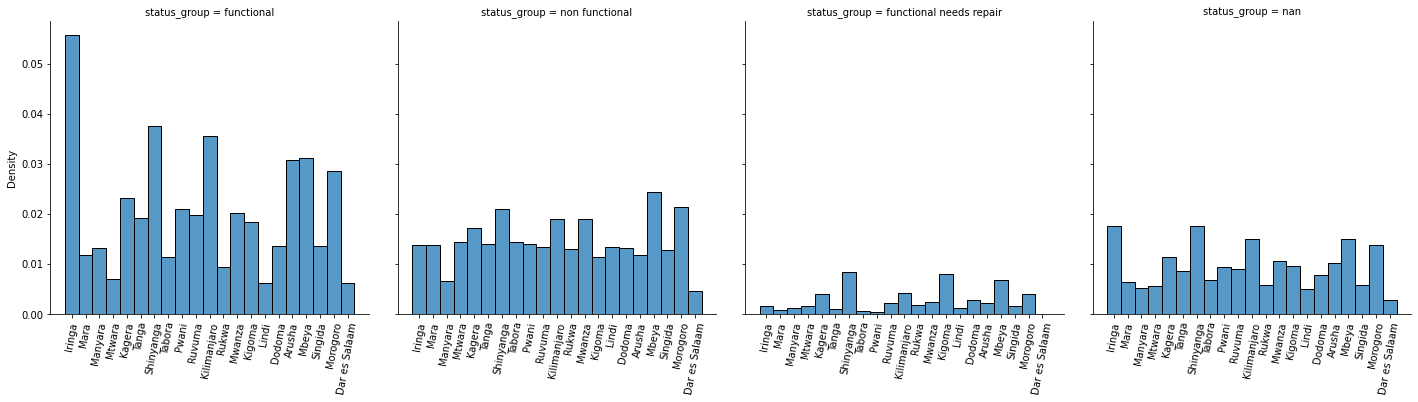

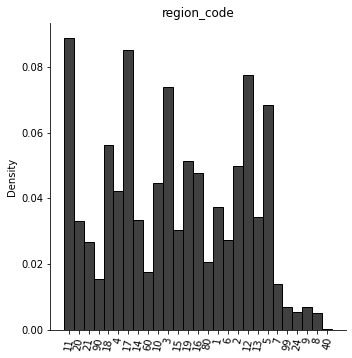

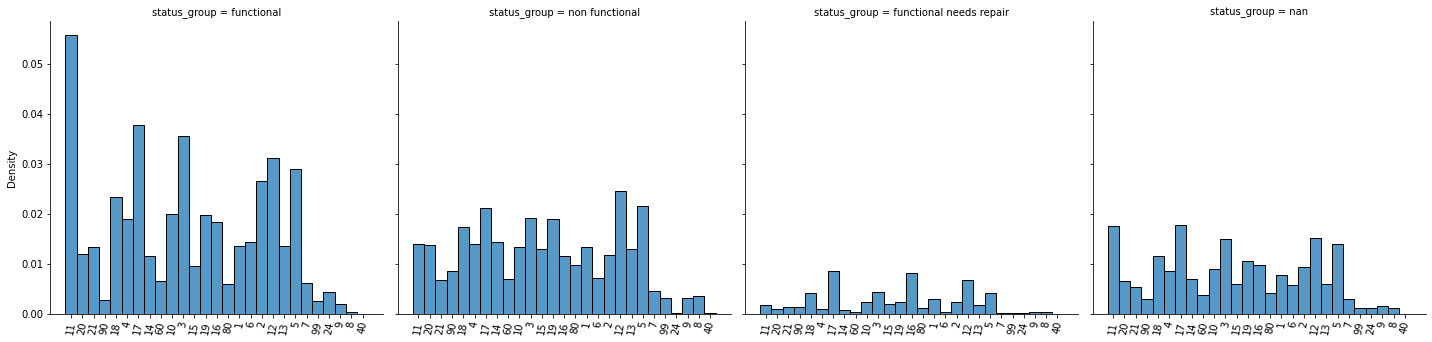

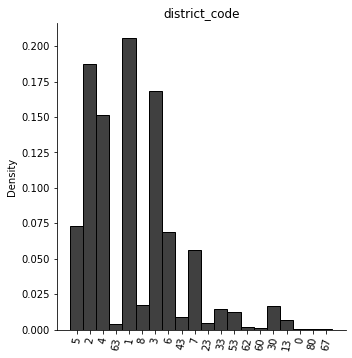

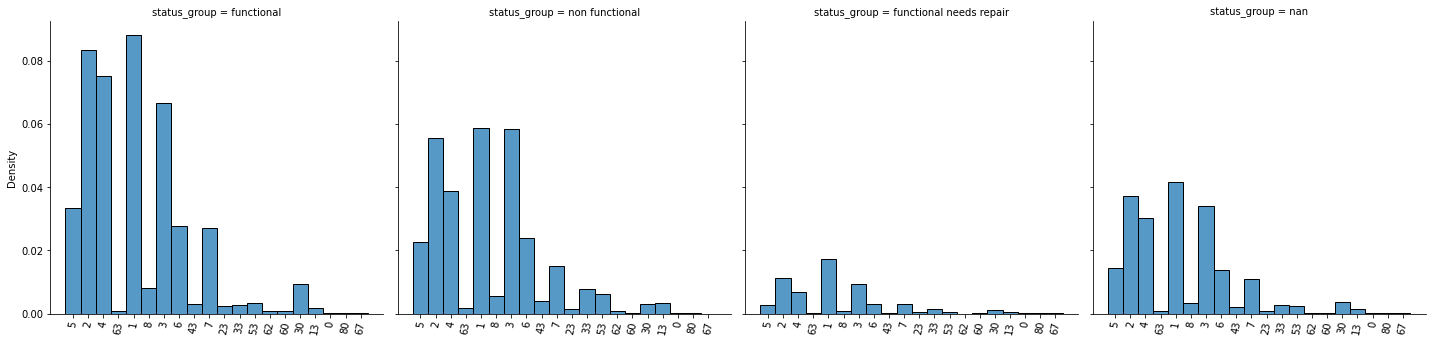

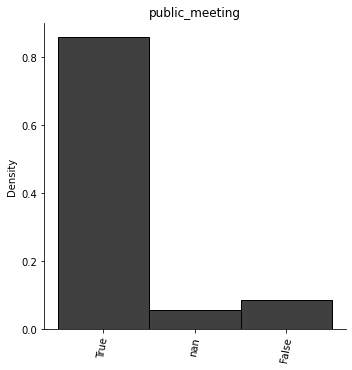

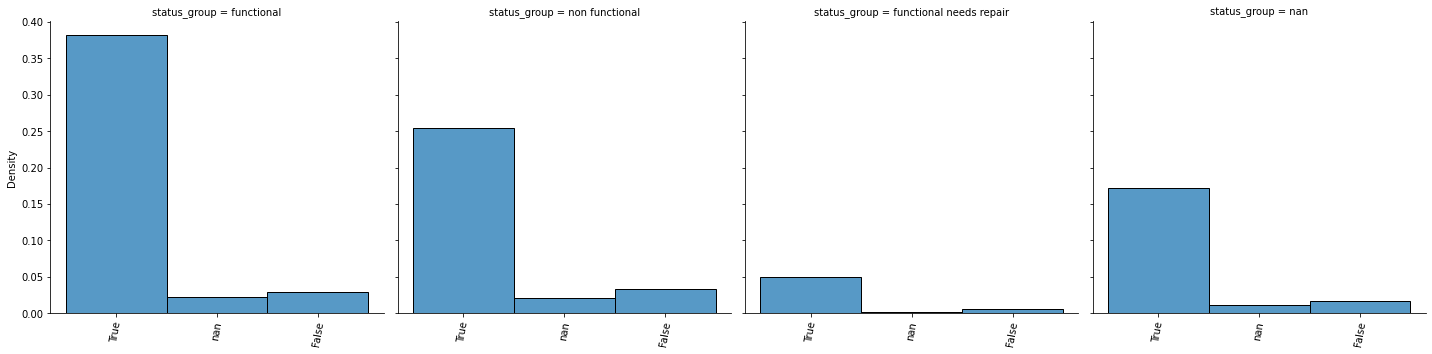

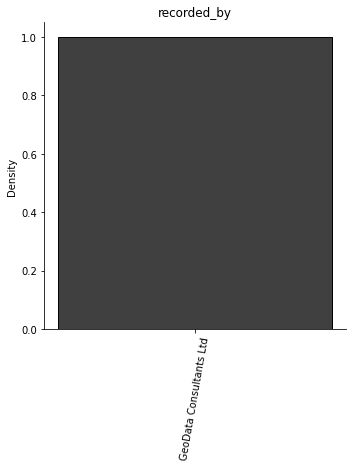

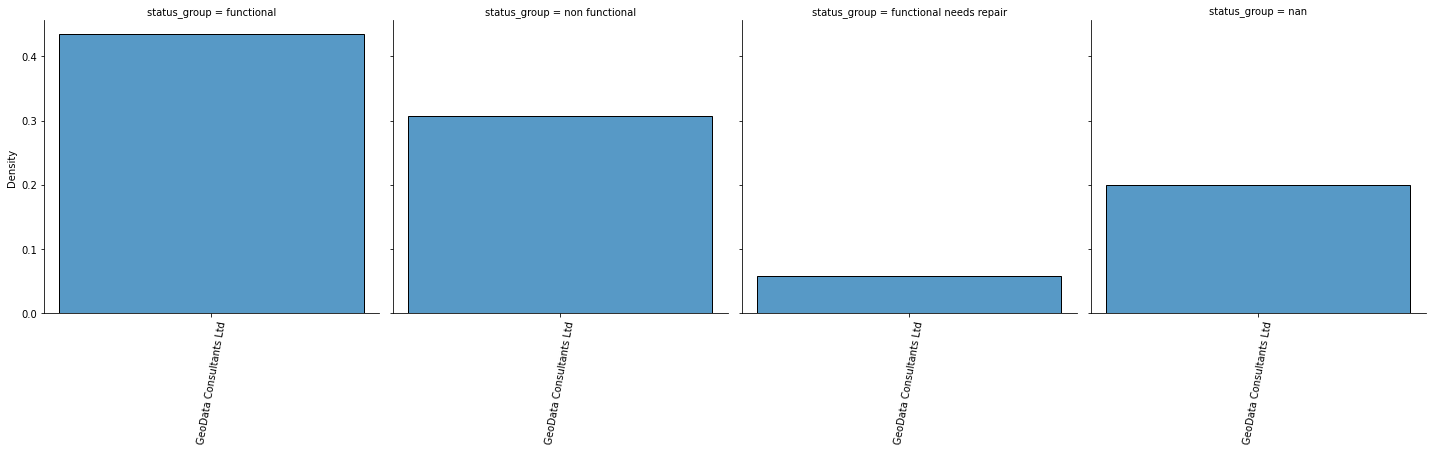

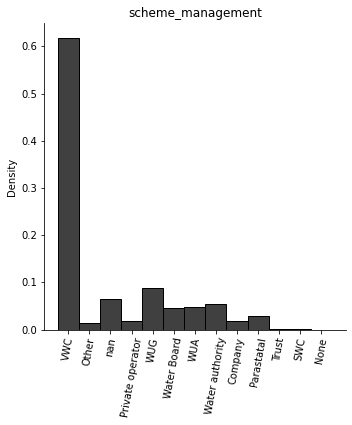

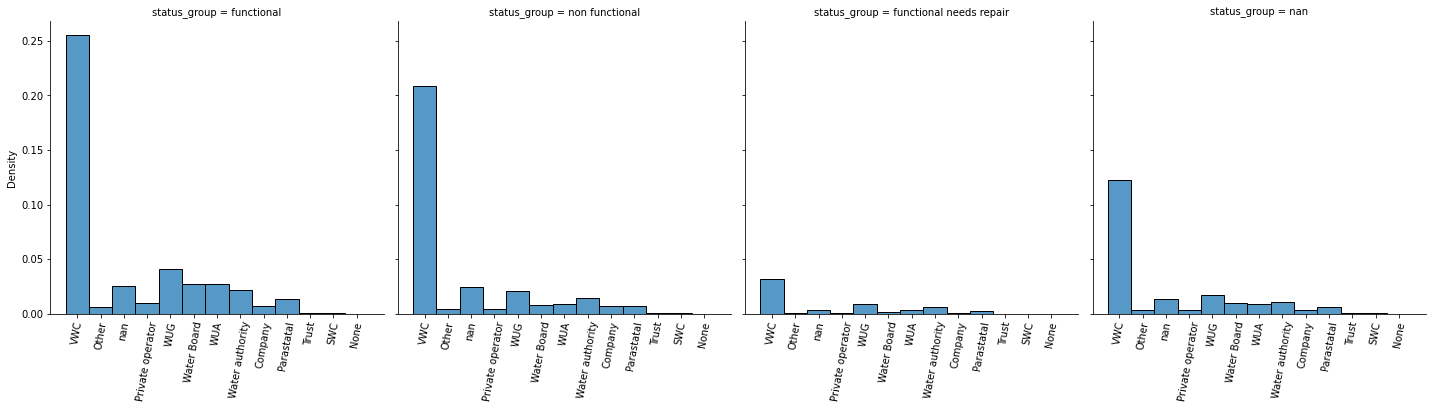

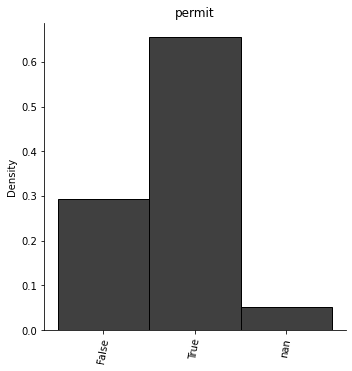

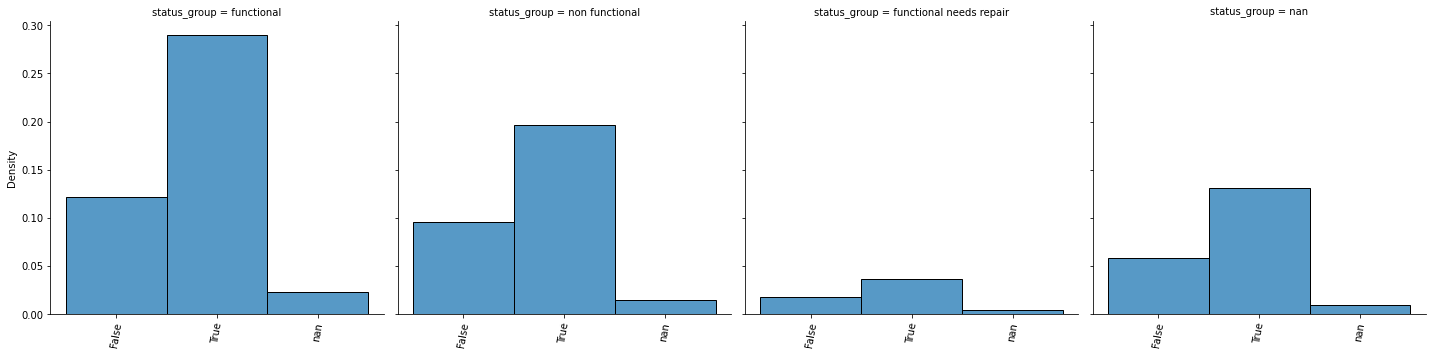

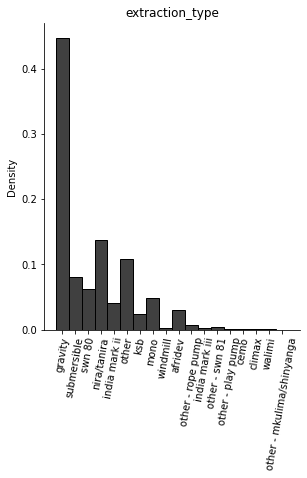

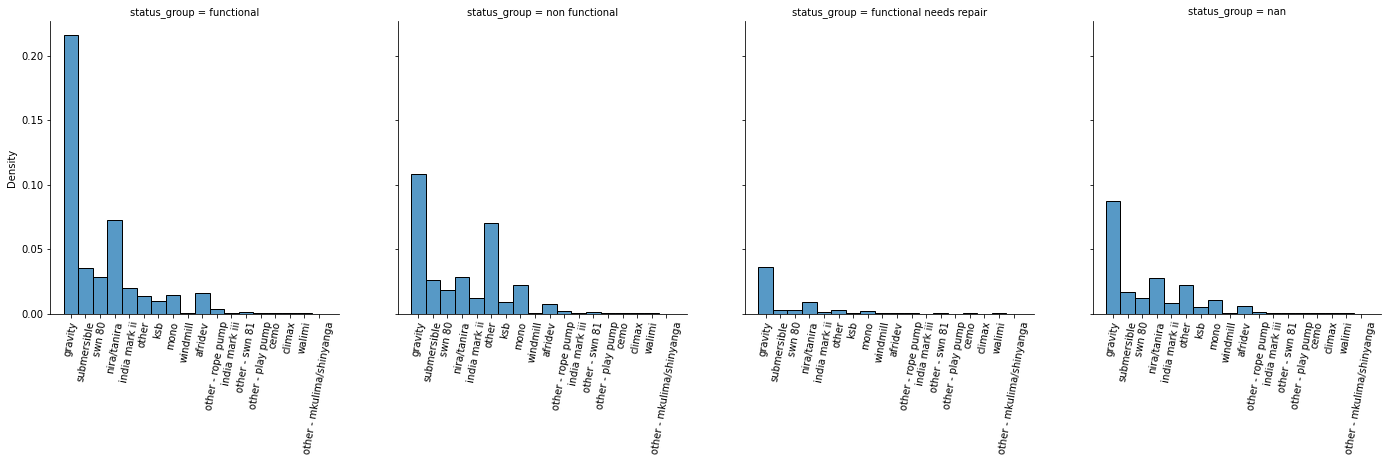

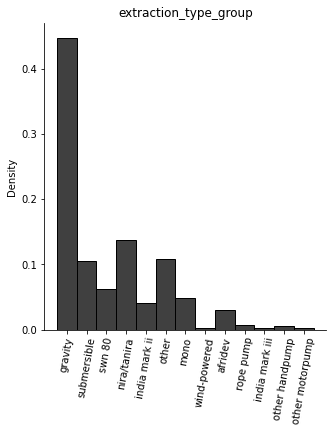

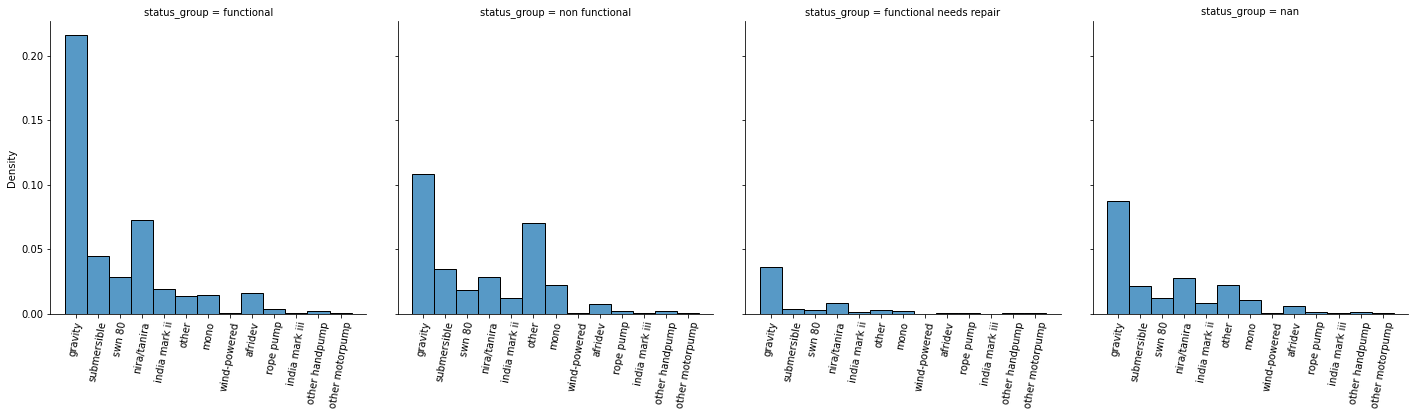

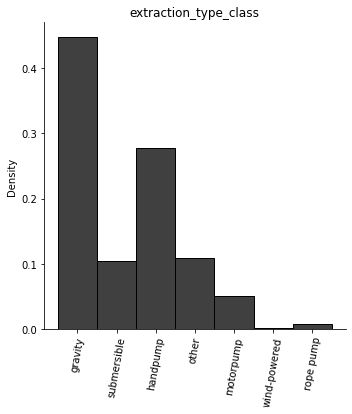

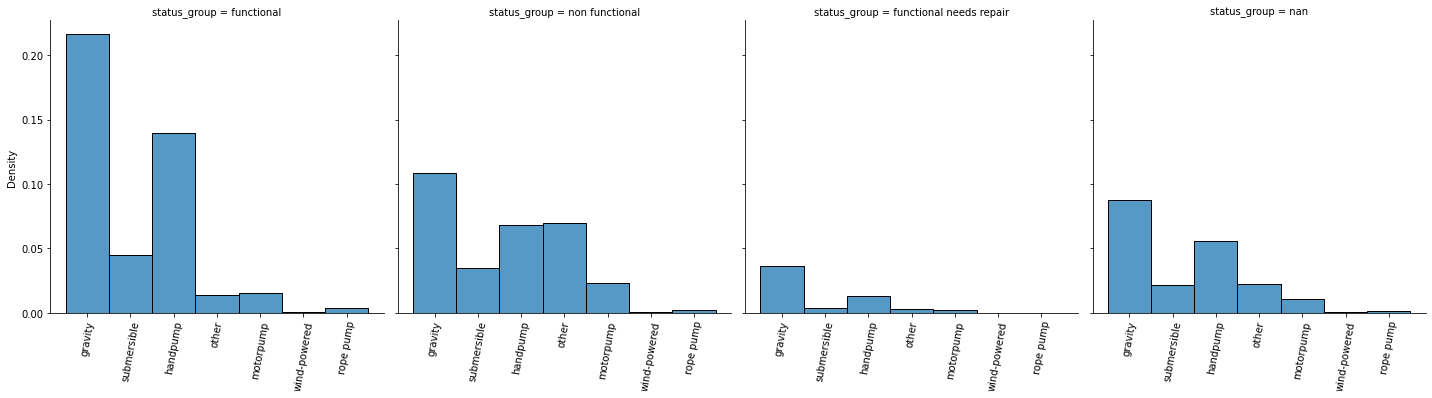

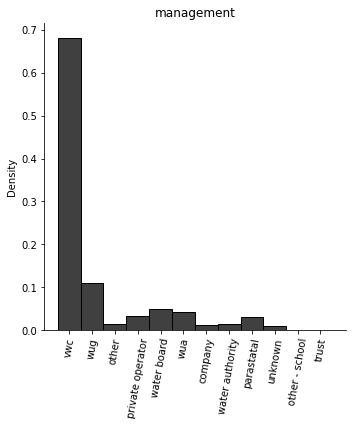

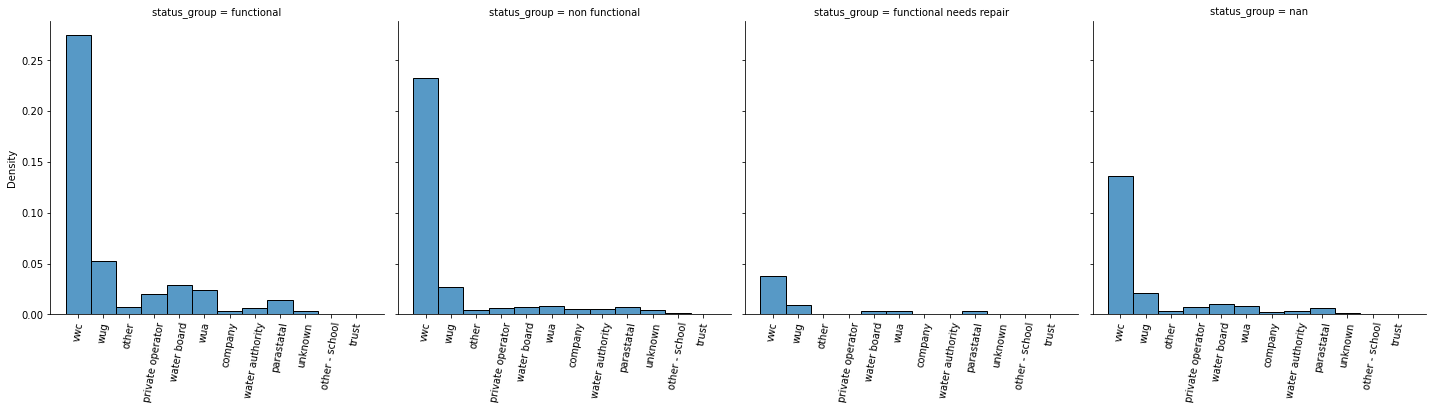

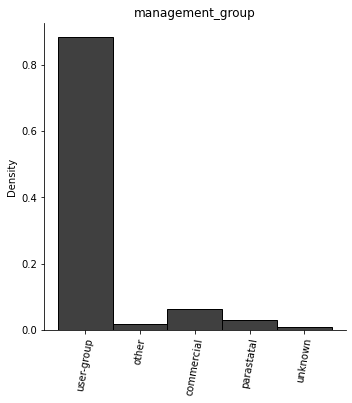

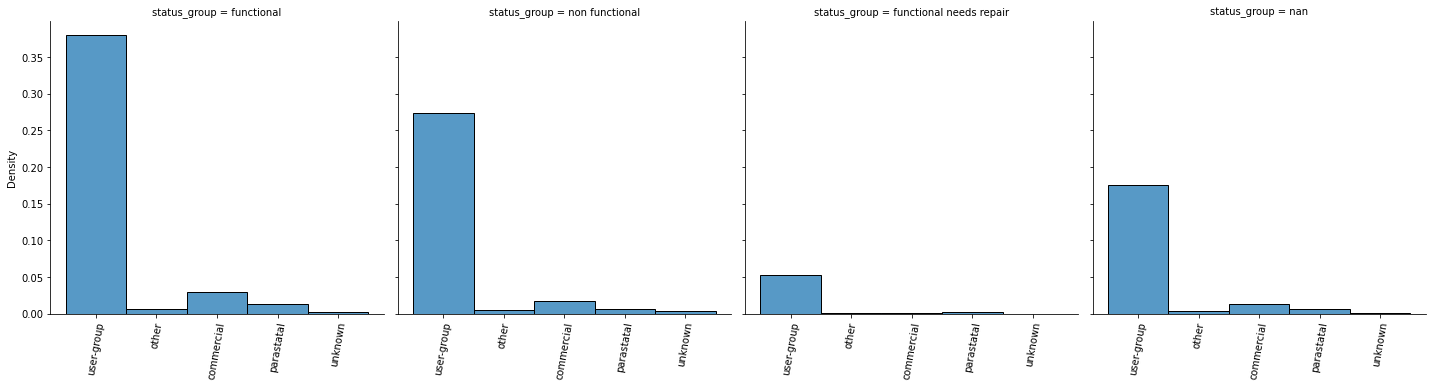

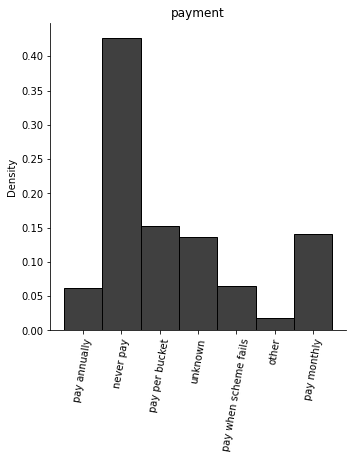

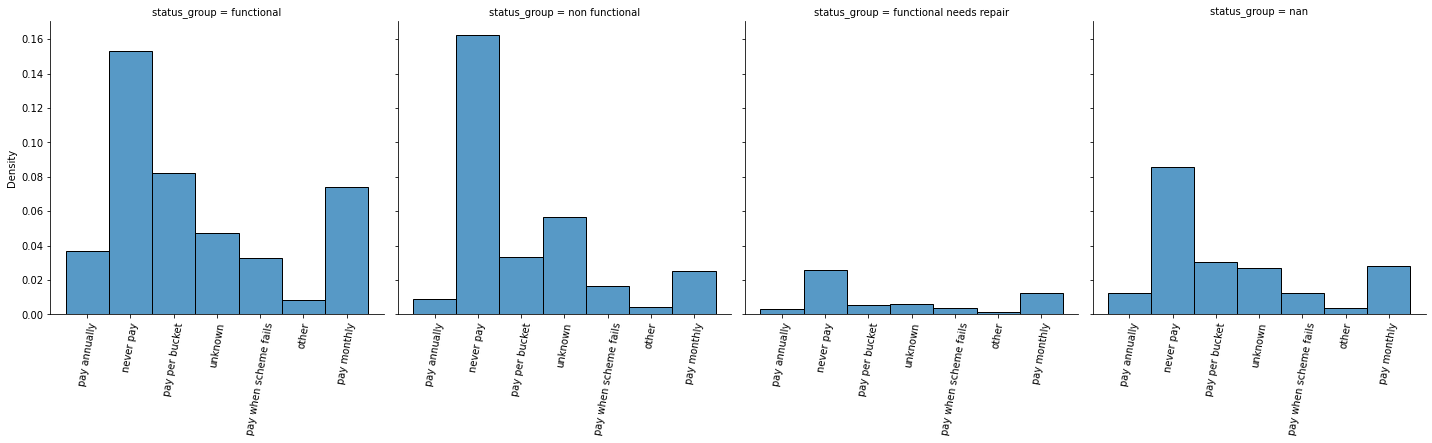

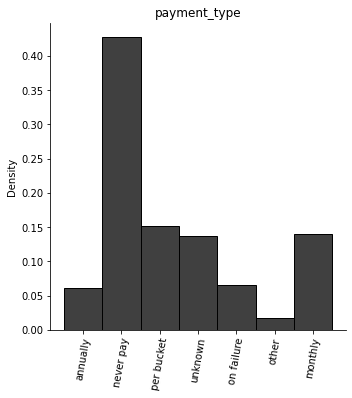

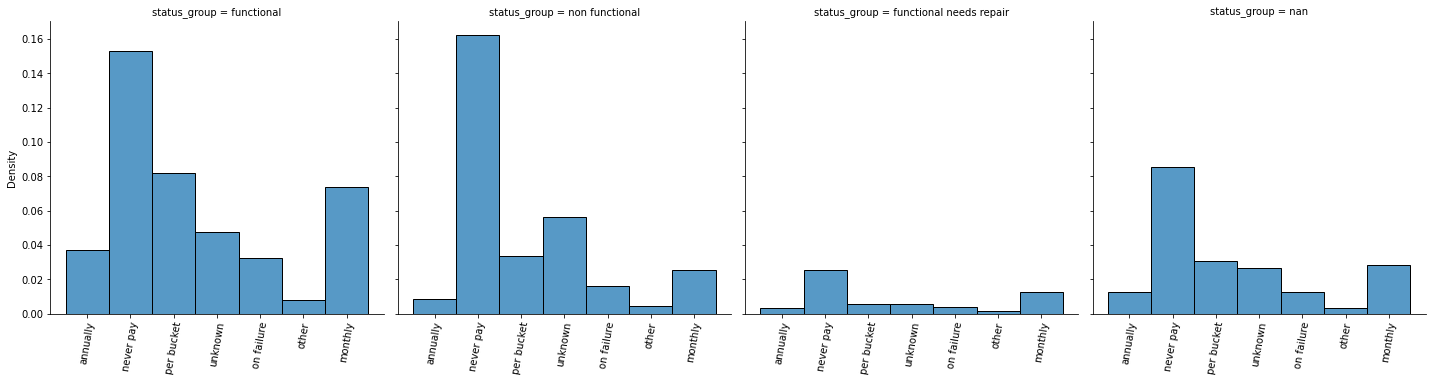

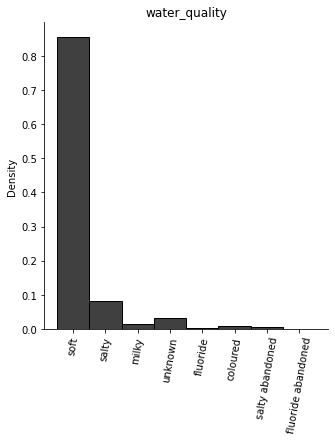

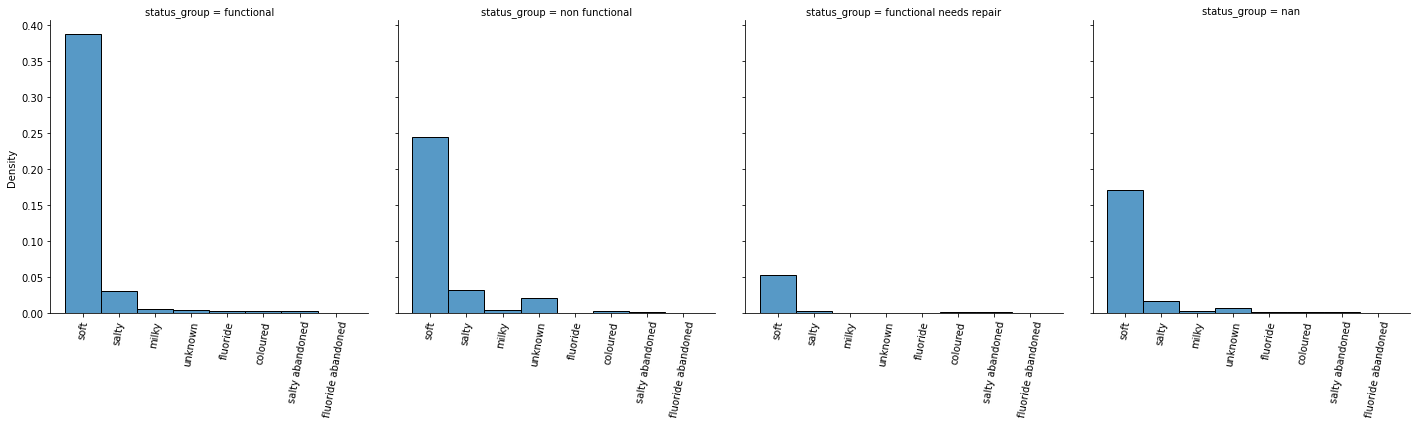

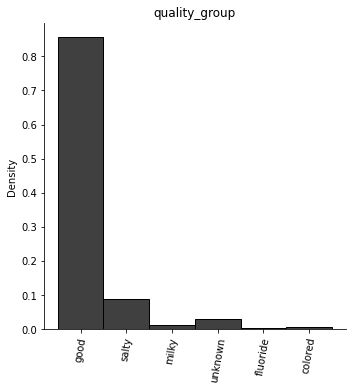

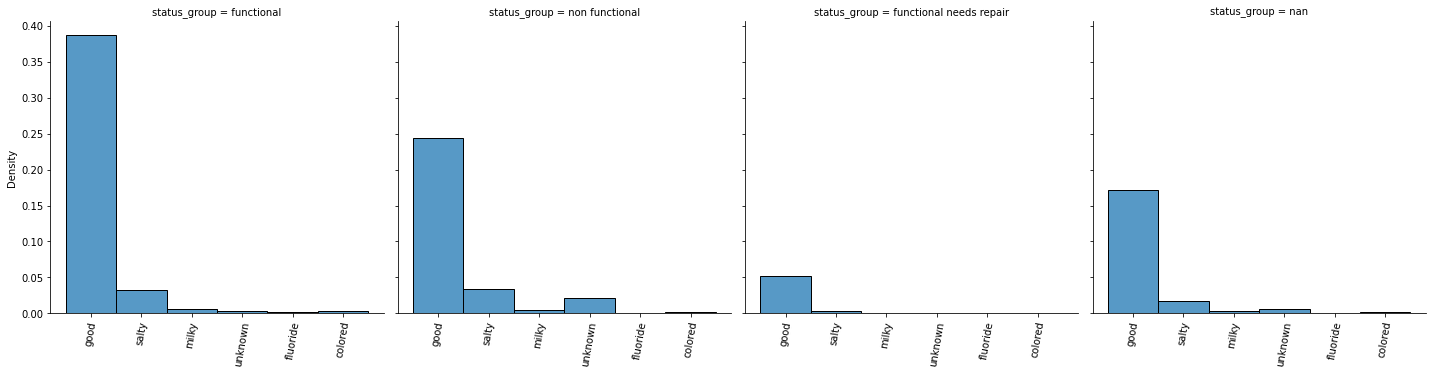

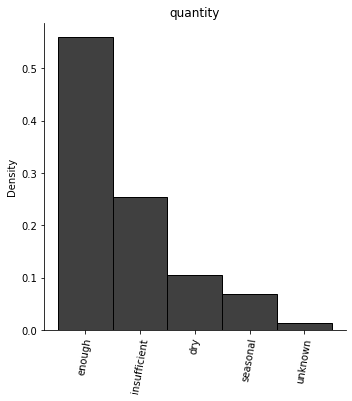

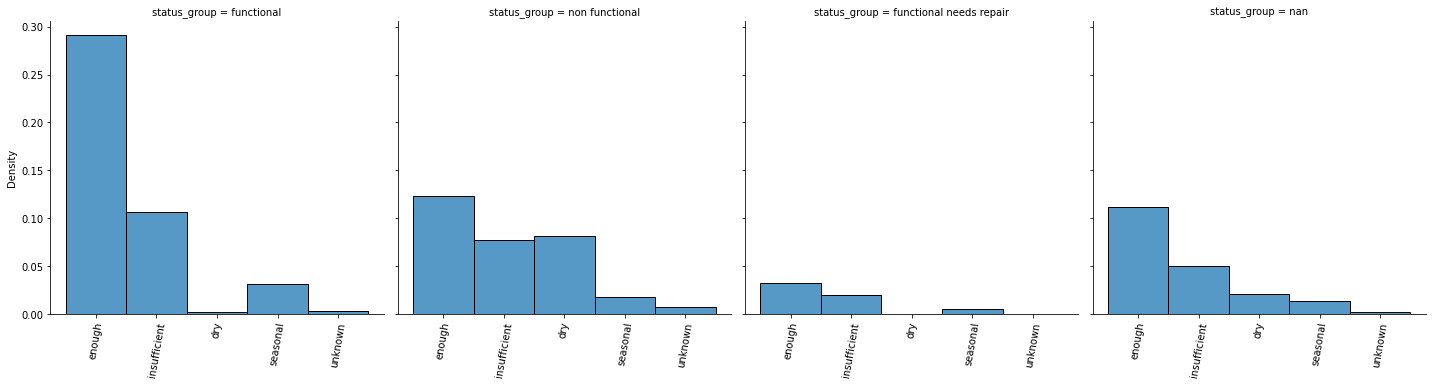

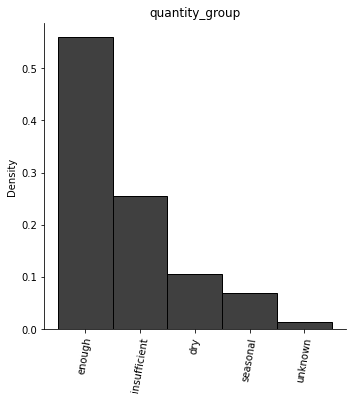

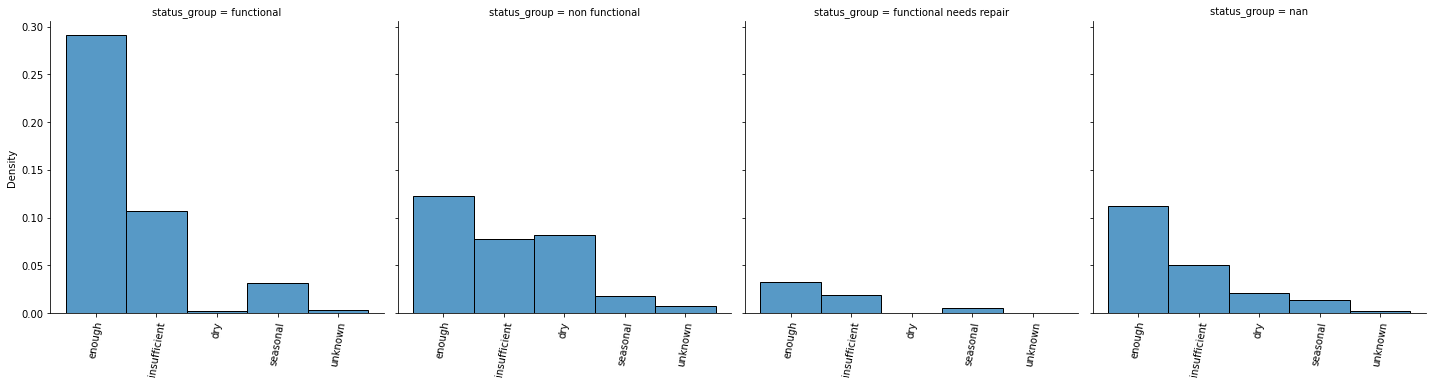

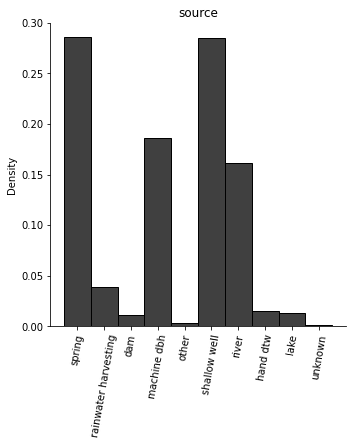

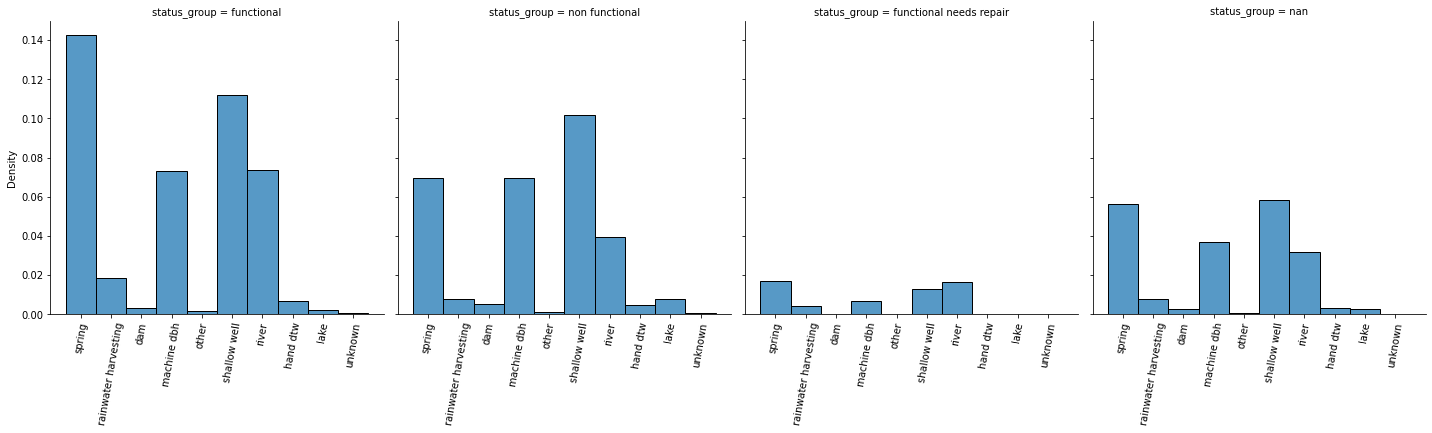

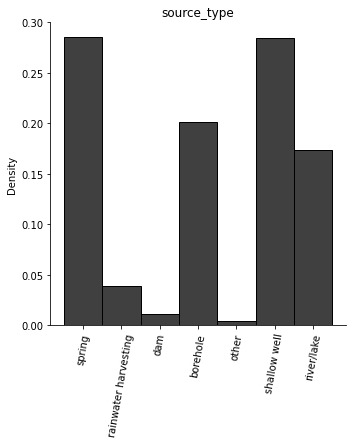

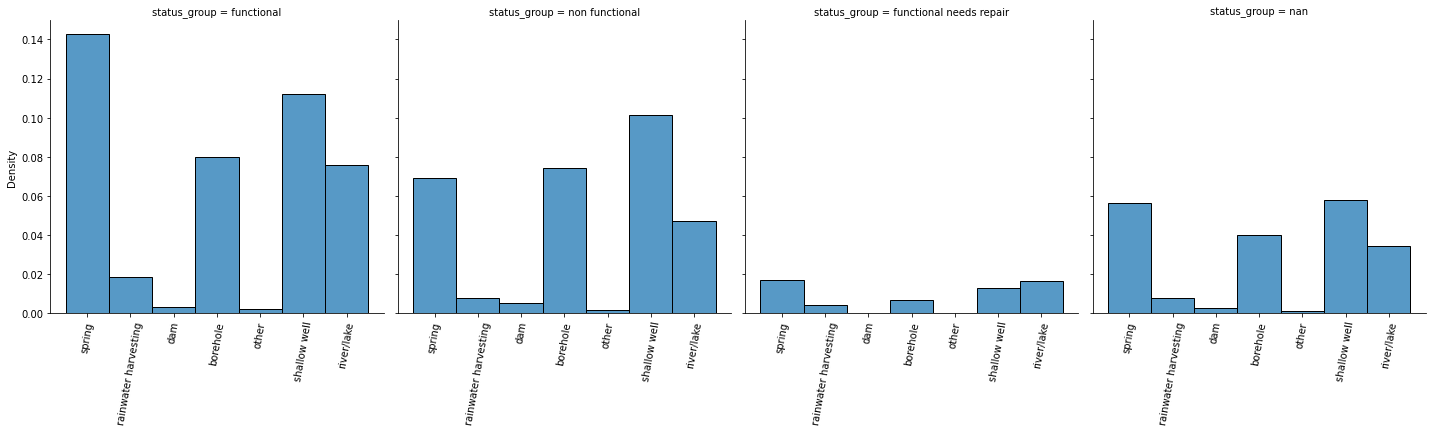

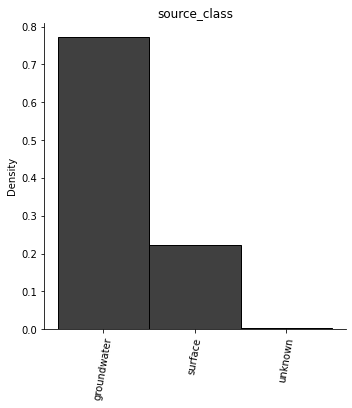

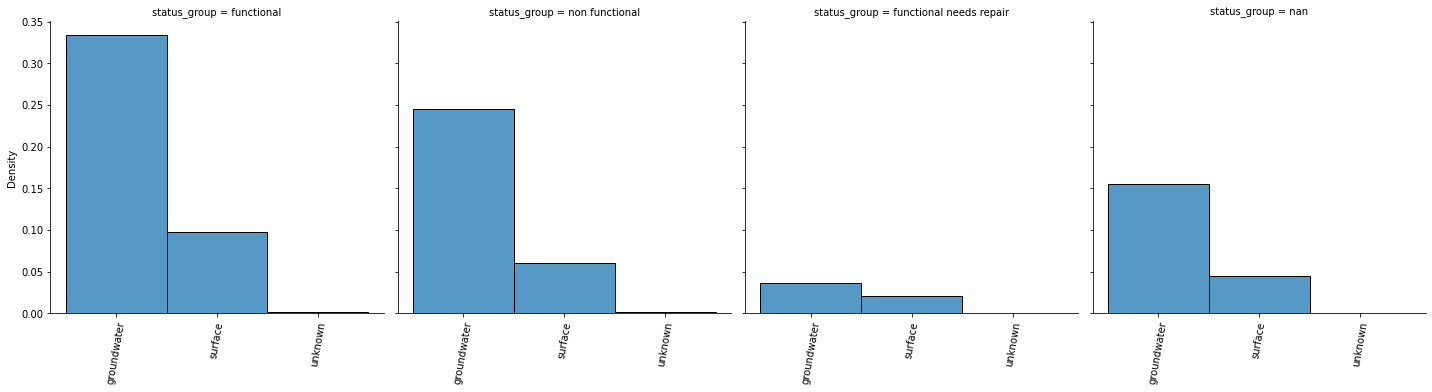

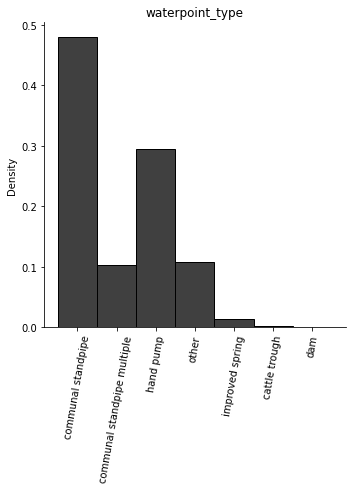

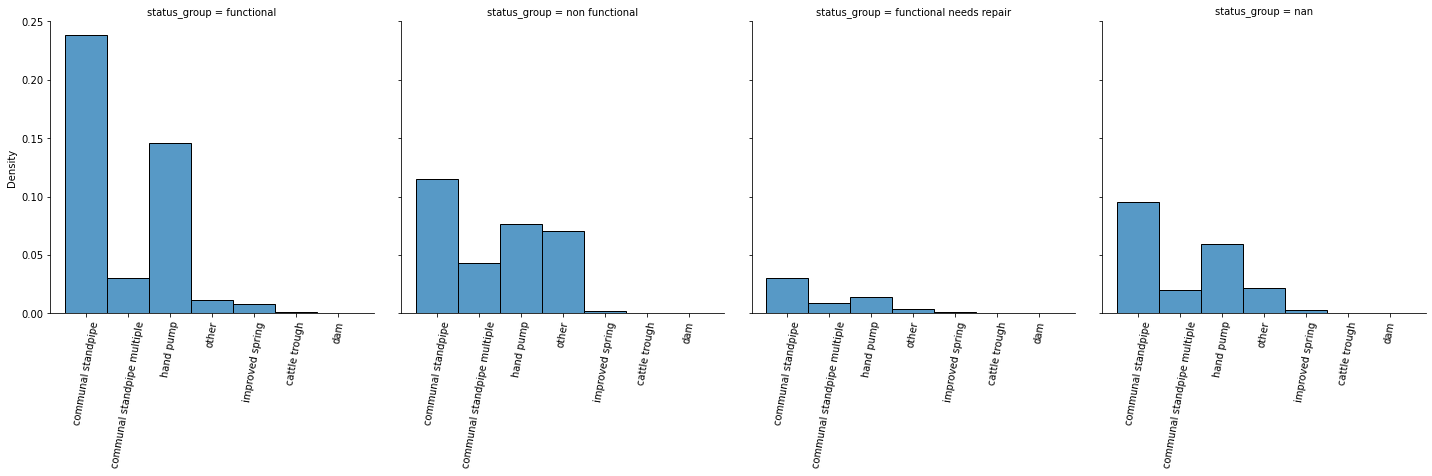

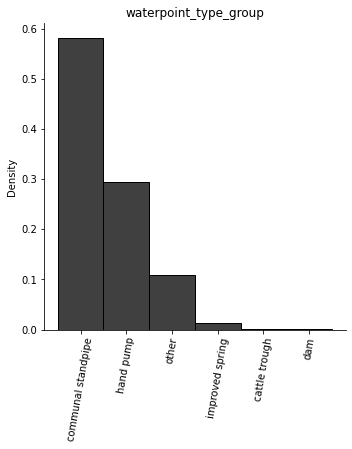

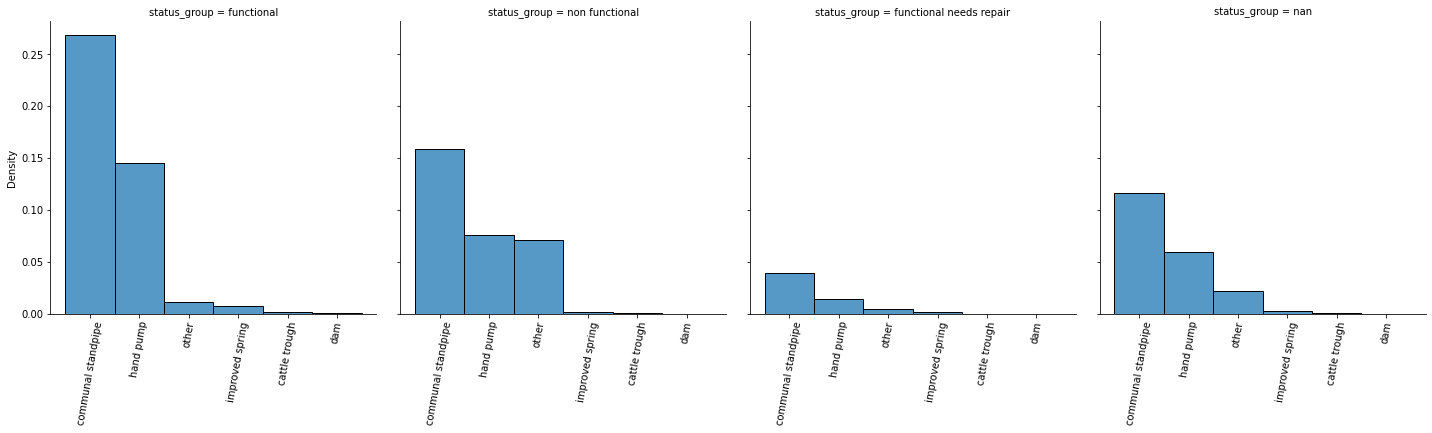

In [ ]:
for item in low_cardinal_list:
  barplotter(raw, item)


#### **2.2.3 Theil's U**

More formealy, we want to know if there's a certain feature that maximizes the information about the class. For this, we will use Theil's U, also known as the Uncertainty Coefficient. Formaly marked as U(x|y), this coefficient provides a value in the range of [0,1], where 0 means that feature y provides no information about feature x, and 1 means that feature y provides full information abpout features x's value.

In [ ]:
#https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

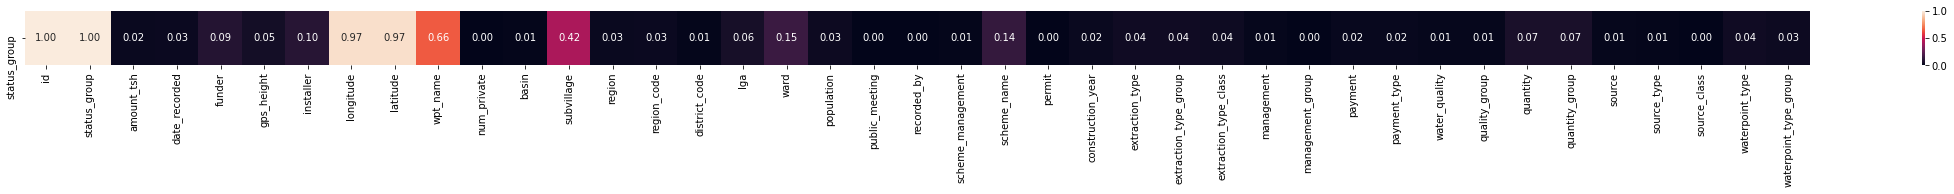

In [ ]:
#apply theilu
theilu = pd.DataFrame(index=['status_group'],columns=raw.columns)
columns = raw.columns
for j in range(0,len(columns)):
    u = theil_u(raw['status_group'].tolist(),raw[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(40,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

#obviously the features that uniquely describe the features (e.g. ID, Wpt name, Subvillage etc) give the most information about the the status of the pump

**Cramers V**

Cramers V is a measure of association bewteen two categorical features.

In [ ]:
#
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
for item in raw[categorical].columns.tolist():
  value = cramers_v(raw['status_group'], raw[item])
  print(item,value)

status_group 1.0
funder 0.21615476110126353
installer 0.21707757808332026
wpt_name 0.12535208958223673
num_private 0.027235526110546214
basin 0.09260982203188053
subvillage 0.2839447626591181
region 0.1463553031365558
region_code 0.15160376701601744
district_code 0.08589330541097345
lga 0.22512334224427985
ward 0.3158548042159522
public_meeting 0.050436582254728135
recorded_by nan
scheme_management 0.09395281655182194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


scheme_name 0.2728343967456182
permit 0.02586998740320461
extraction_type 0.1809659449452476
extraction_type_group 0.17987831893618303
extraction_type_class 0.17581457226372996
management 0.09614355446565764
management_group 0.03564946396383798
payment 0.13313517660426863
payment_type 0.13313517660426863
water_quality 0.10069230822355267
quality_group 0.09677762277890103
quantity 0.2260513546597279
quantity_group 0.2260513546597279
source 0.10821442176511244
source_type 0.09221920265806008
source_class 0.06281563162413502
waterpoint_type 0.18249297595639746
waterpoint_type_group 0.1652618784447551


###**2.3 Numerical and Categorical Correlations**

Source
* http://shakedzy.xyz/dython/
* http://shakedzy.xyz/dython/modules/nominal/

In [ ]:
#pip install dython

In [ ]:
#because dython doesn't run very well on the large df, we can run it on a random sample
raw_sample = raw.sample(n=10000, random_state=1)

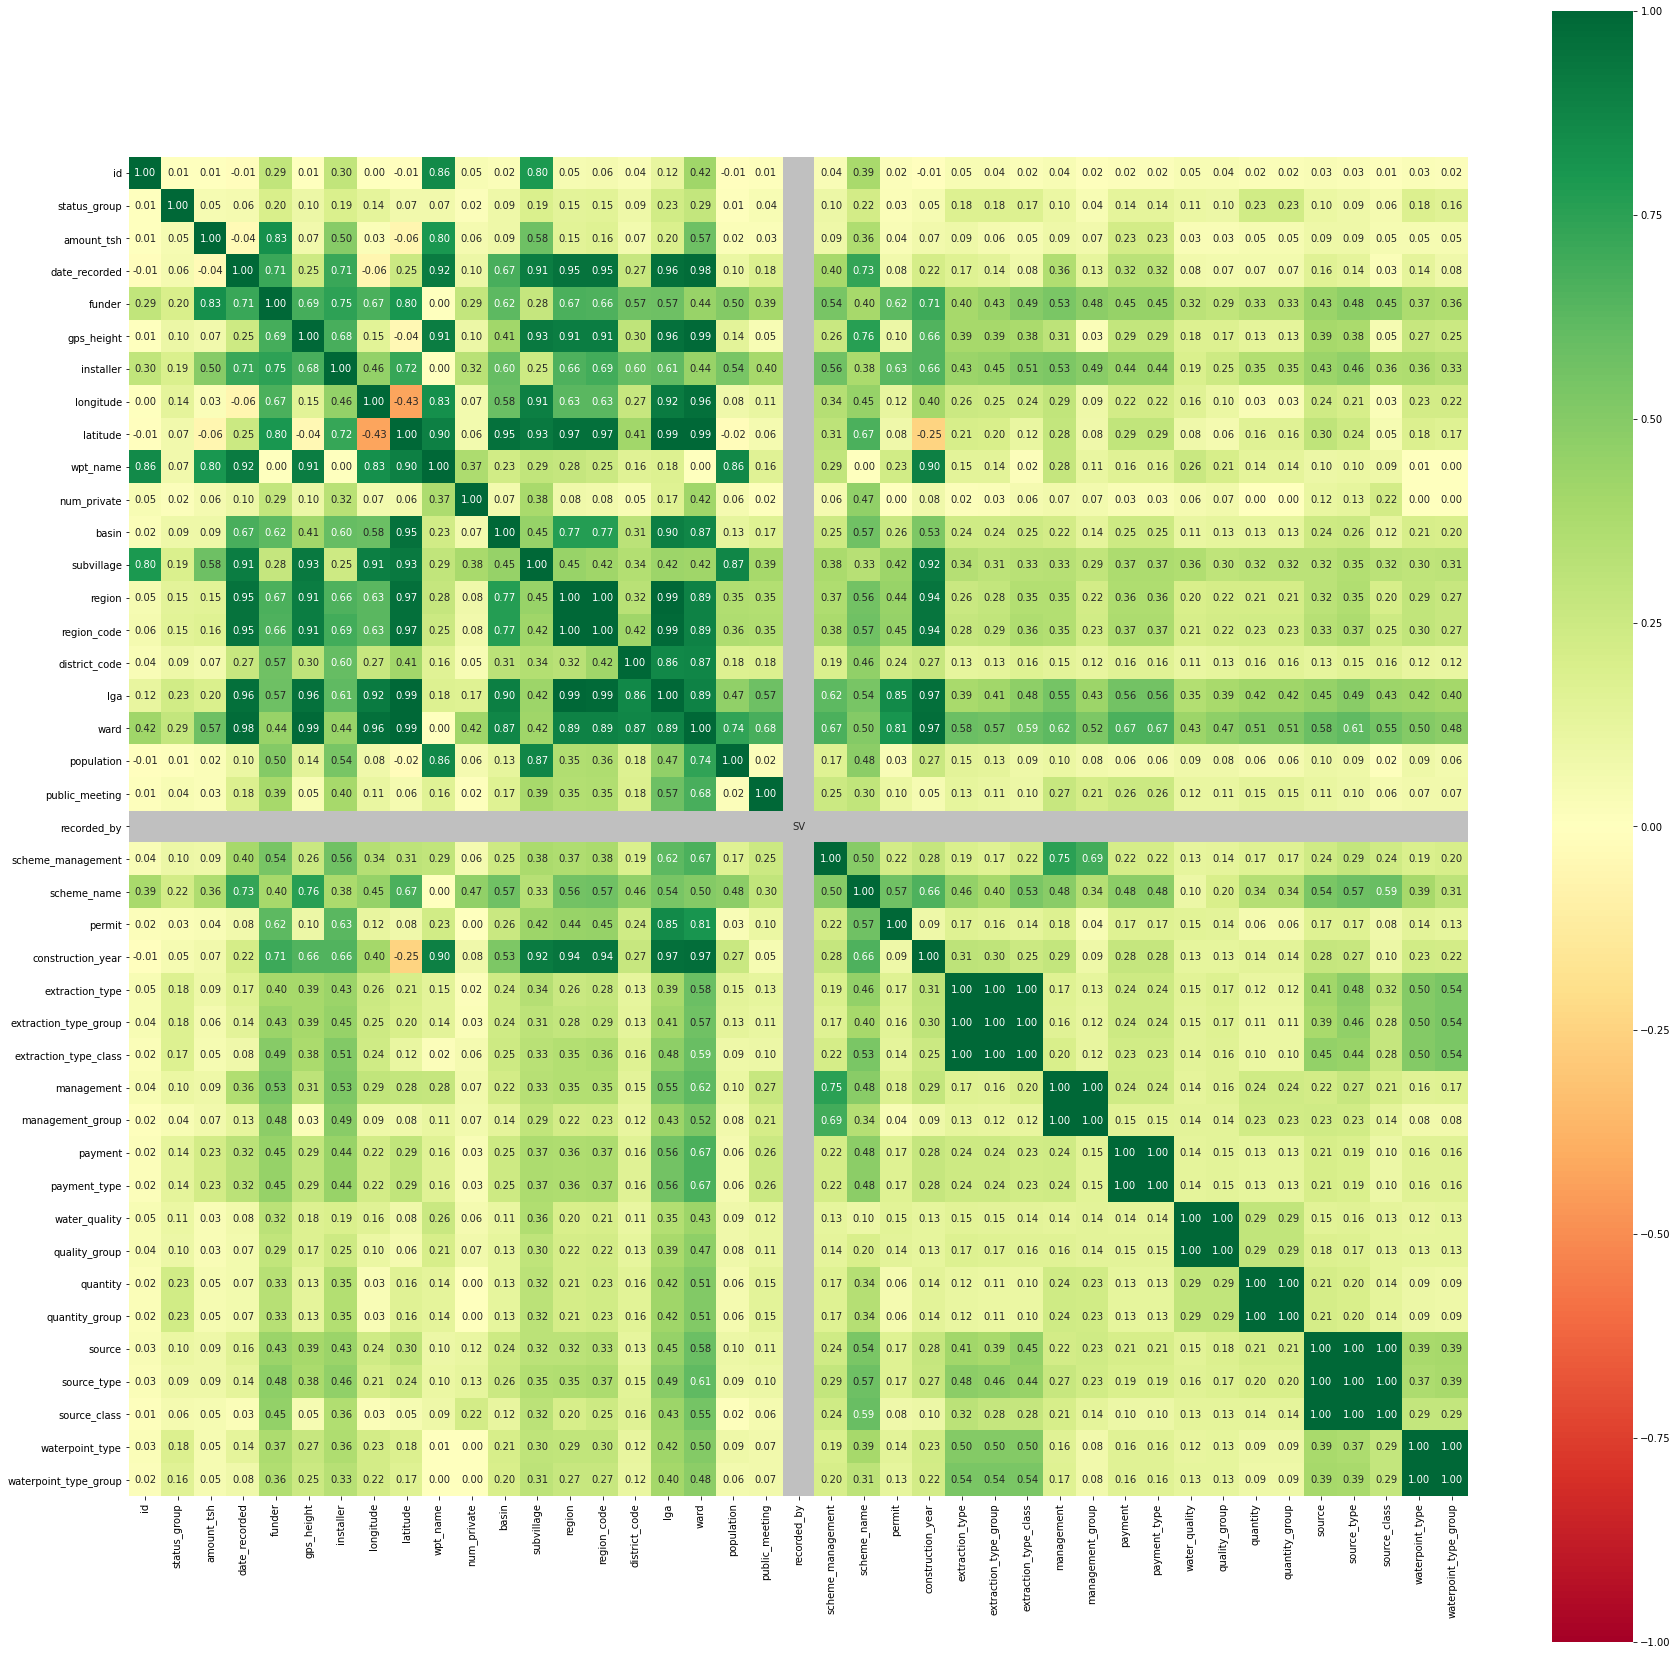

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4566ab4490>,
 'corr':                              id  status_group  amount_tsh  date_recorded  \
 id                     1.000000      0.006037    0.006165      -0.009860   
 status_group           0.006037      1.000000    0.054383       0.058278   
 amount_tsh             0.006165      0.054383    1.000000      -0.038746   
 date_recorded         -0.009860      0.058278   -0.038746       1.000000   
 funder                 0.294084      0.202193    0.831873       0.711516   
 gps_height             0.005364      0.101046    0.070575       0.247271   
 installer              0.296448      0.190795    0.496513       0.711669   
 longitude              0.001935      0.137297    0.028107      -0.059398   
 latitude              -0.006836      0.072753   -0.061996       0.252174   
 wpt_name               0.858767      0.073523    0.800304       0.921702   
 num_private            0.045407      0.022857    0.058350       0.100043   
 b

In [ ]:
#Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using: 
#* Pearson's R for continuous-continuous cases <-- note: this is not optimal for the current dataset
#* Correlation Ratio for categorical-continuous cases 
#* Cramer's V or Theil's U for categorical-categorical cases

from dython.nominal import associations
associations(raw_sample, figsize=(30,30), cmap = 'RdYlGn' )

In [ ]:
#Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using: 
#* Pearson's R for continuous-continuous cases  <-- this is not ideal
#* Correlation Ratio for categorical-continuous cases 
#* Cramer's V or Theil's U for categorical-categorical cases

from dython.nominal import compute_associations
compute_associations(raw_sample)

id  status_group  amount_tsh  date_recorded  \
id                     1.000000      0.019824    0.006699       0.005428   
status_group           0.019824      1.000000    0.052977       0.067589   
amount_tsh             0.006699      0.052977    1.000000      -0.048345   
date_recorded          0.005428      0.067589   -0.048345       1.000000   
funder                 0.354685      0.175016    0.942300       0.708040   
gps_height             0.019782      0.094792    0.050255       0.259021   
installer              0.357592      0.165127    0.520313       0.708655   
longitude              0.003230      0.124914    0.029536      -0.058367   
latitude              -0.009351      0.073131   -0.054258       0.257681   
wpt_name               0.875524      0.121740    0.803310       0.931320   
num_private            0.069136      0.026744    0.041041       0.106762   
basin                  0.043256      0.088767    0.093137       0.675421   
subvillage             0.854782      0.151272    0.668630       0.925051   
region                 0.065731      0.139356    0.154095       0.949020   
region_code            0.072582      0.143541    0.173099       0.948489   
district_code          0.046641      0.087440    0.065160       0.265495   
lga                    0.154707      0.221138    0.204617       0.958527   
ward                   0.562081      0.234093    0.592568       0.984291   
population            -0.006968      0.028578    0.027421       0.098022   
public_meeting         0.021434      0.038546    0.042334       0.187842   
recorded_by            0.000000      0.000000    0.000000       0.000000   
scheme_management      0.051968      0.100086    0.115635       0.396837   
scheme_name            0.472149      0.188356    0.339005       0.729753   
permit                 0.013925      0.040350    0.032855       0.080116   
construction_year      0.010695      0.048666    0.064113       0.223296   
extraction_type        0.042860      0.177231    0.123655       0.190303   
extraction_type_group  0.039964      0.175909    0.062238       0.163350   
extraction_type_class  0.025051      0.168720    0.057465       0.085664   
management             0.056837      0.099635    0.114830       0.351259   
management_group       0.034993      0.037648    0.101536       0.129353   
payment                0.024953      0.122922    0.183712       0.310440   
payment_type           0.024953      0.122922    0.183712       0.310440   
water_quality          0.055072      0.107688    0.031748       0.086360   
quality_group          0.053172      0.096077    0.031725       0.080530   
quantity               0.036006      0.224956    0.049288       0.075147   
quantity_group         0.036006      0.224956    0.049288       0.075147   
source                 0.039108      0.103958    0.087011       0.171583   
source_type            0.033260      0.091975    0.082953       0.149882   
source_class           0.006420      0.057109    0.059350       0.027762   
waterpoint_type        0.016917      0.174135    0.047558       0.133366   
waterpoint_type_group  0.016476      0.156697    0.042681       0.068364   

                         funder  gps_height  installer  longitude  latitude  \
id                     0.354685    0.019782   0.357592   0.003230 -0.009351   
status_group           0.175016    0.094792   0.165127   0.124914  0.073131   
amount_tsh             0.942300    0.050255   0.520313   0.029536 -0.054258   
date_recorded          0.708040    0.259021   0.708655  -0.058367  0.257681   
funder                 1.000000    0.680500   0.744344   0.659242  0.804994   
gps_height             0.680500    1.000000   0.672873   0.163050 -0.037929   
installer              0.744344    0.672873   1.000000   0.439990  0.722822   
longitude              0.659242    0.163050   0.439990   1.000000 -0.436846   
latitude               0.804994   -0.037929   0.722822  -0.436846  1.000000   
wpt_name               0.000000    0.916248   

In [ ]:
#knn imputer?

### **3 Data Cleaning**

In [ ]:
cleaned = raw.copy()

####**3.1 Zero's to NaN**

Numerical data
* Data, Longitude, Latitude, Populatation and Construction Year can't technically be zero so can be converted to NaN

In [ ]:
#gps height has 25.649 records where the height is zero
height_zero = raw[raw['gps_height']==0]
len(height_zero)
#height_zero.head()

25649

In [ ]:
#gps height has 25.649 records where the height is zero
height_zero = raw[raw['gps_height']<100]
len(height_zero)
#height_zero.head()

30492

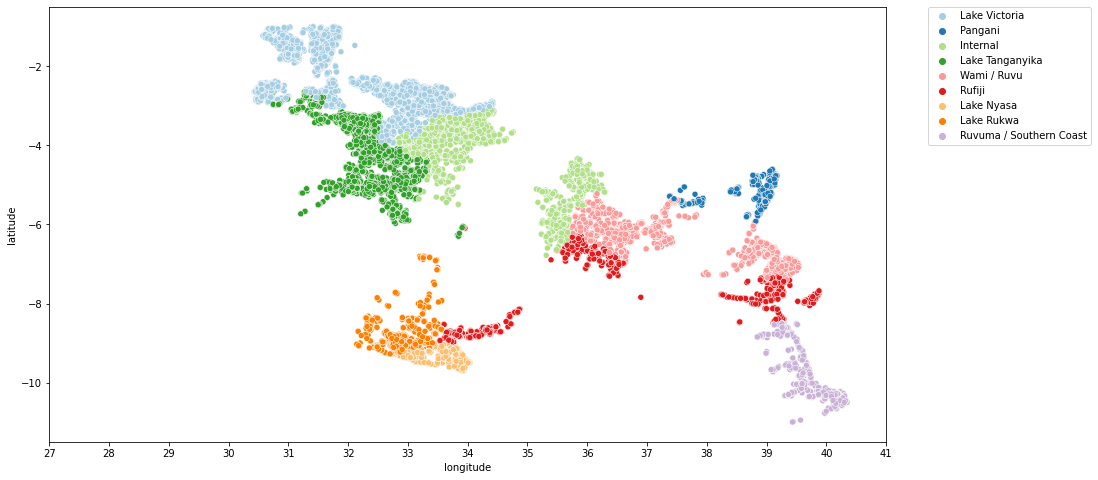

In [ ]:
#plot the location of records where the altitude equals zero and the longiutude is not missing
height_zero = height_zero[height_zero['longitude']!=0.000000]

#plot the location
plt.figure(figsize = (15,8))
ax = sns.scatterplot(x= height_zero['longitude'], y = height_zero['latitude'], hue = height_zero['basin'], palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticks(range(27 ,42))
#ax.set_yticks(range(0, -12))
plt.show()

In [ ]:
#Elevation map of Tanzania: https://www.mapsland.com/africa/tanzania/large-elevation-map-of-tanzania

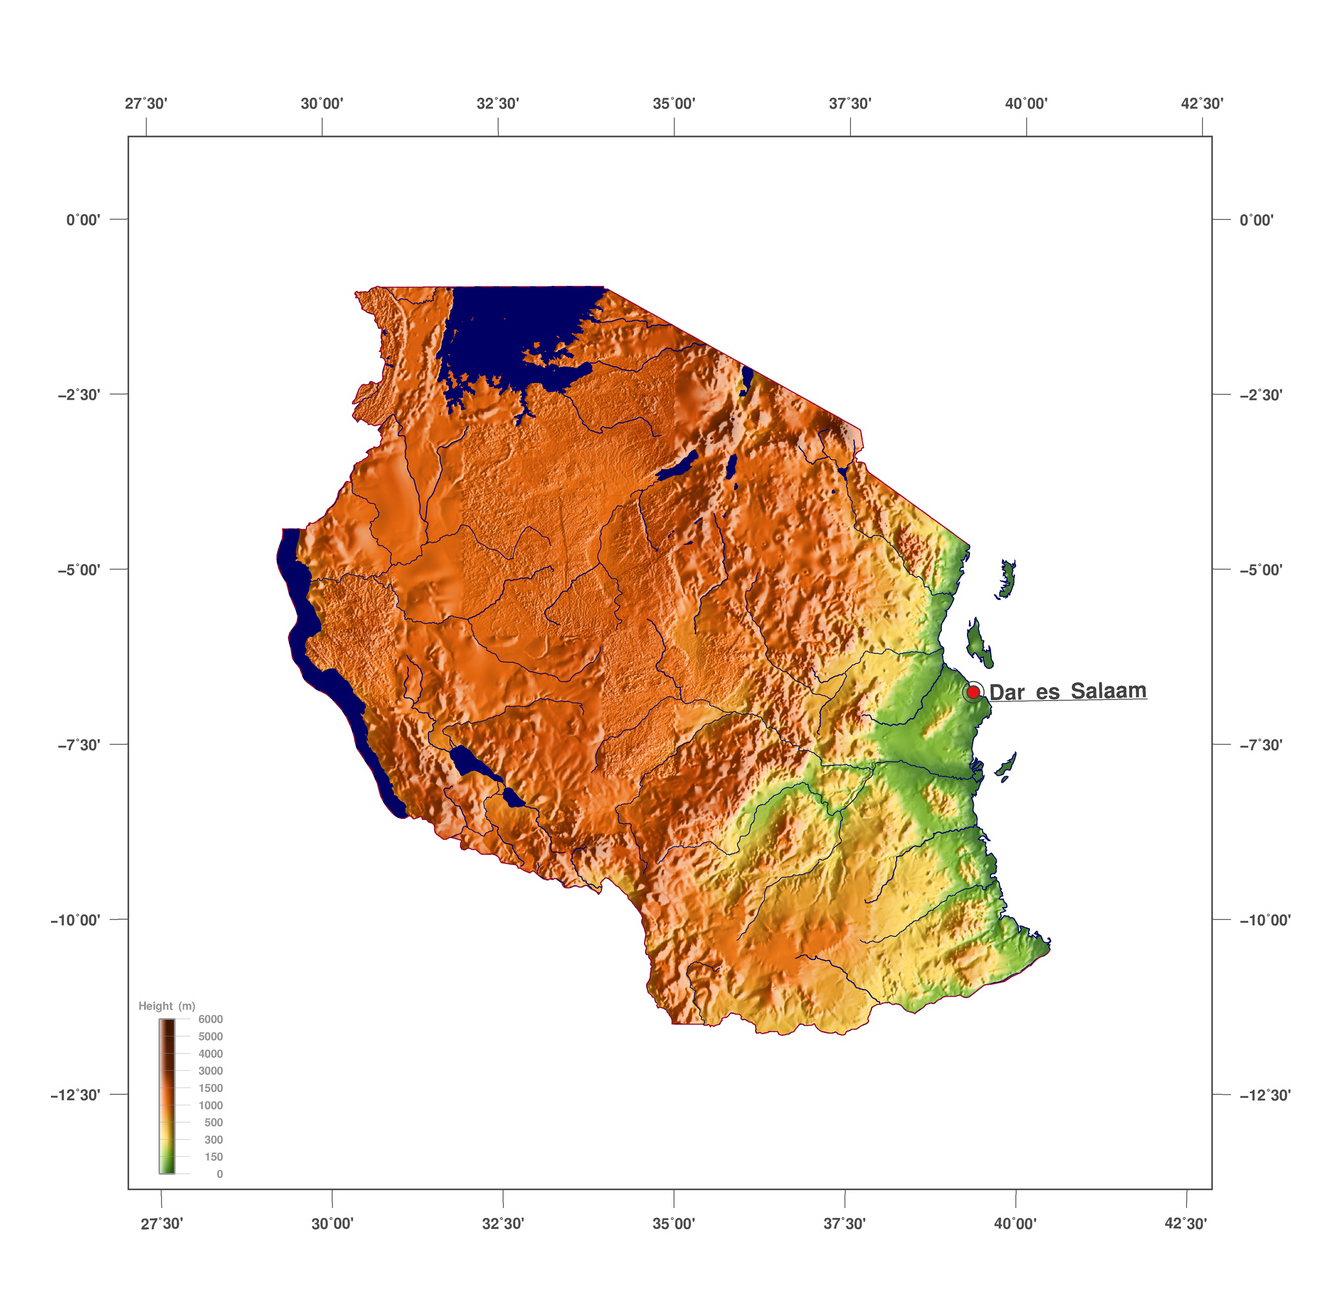


**Zero's in the numerical features**

Based on the given altitude map of Tanzania, the fast majority of the zero's can't be zero's. Some zero's along the coastal area could technically be correct, but when I impute these by some region average I expect the overall imapct to moderate.

Amount_tsh is a tricky feature because it represents the static height, which could technically be zero when the water source and the discharge lcoation are at the same location. Based on what I know for the use of zero's in the other numerical features and the poor correlation between Amount_tsh and the label I will also assume that zero's here are incorrect.

Dates, Longitude, Latitude, Populatation and Construction Year can't technically be zero so can be converted to NaN

In [ ]:
#set all numerical zero's to np.nan
cleaned[numerical] = cleaned[numerical].replace(0, np.nan)


In [ ]:
#reprint the data quality report
data_types = pd.DataFrame(
    cleaned [numerical].dtypes,
    columns=['Data Type'])

missing_data = pd.DataFrame(
    cleaned [numerical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values']
)
for row in list(cleaned [numerical].columns.values):
    unique_values.loc[row] = [cleaned [numerical][row].nunique()]

maximum_values = pd.DataFrame(
    columns=['Maximum Value'])
for row in list(cleaned [numerical].columns.values):
    maximum_values.loc[row] = [cleaned [numerical][row].max()]

minimum_values = pd.DataFrame(
    columns=['Minimum Value'])
for row in list(cleaned [numerical].columns.values):
    minimum_values.loc[row] = [cleaned [numerical][row].min()]

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(cleaned [numerical].columns.values):
    count_values.loc[row] = [cleaned[numerical][row].count()]

mean_values = pd.DataFrame(
    columns=['Mean Value'])
for row in list(cleaned [numerical].columns.values):
    mean_values.loc[row] = [cleaned [numerical][row].mean()]

quartile_1 = pd.DataFrame(
    columns=['1st Quartile'])
for row in list(cleaned [numerical].columns.values):
    quartile_1.loc[row] = [cleaned [numerical][row].quantile(0.25)]

median = pd.DataFrame(
    columns=['Median'])
for row in list(cleaned [numerical].columns.values):
    median.loc[row] = [cleaned [numerical][row].quantile(0.5)]

quartile_3 = pd.DataFrame(
    columns=['3rd Quartile'])
for row in list(cleaned [numerical].columns.values):
    quartile_3.loc[row] = [cleaned [numerical][row].quantile(0.75)]

dq_report_num = data_types.join(count_values).join(missing_data).join(unique_values).join(minimum_values).join(maximum_values).join(mean_values).join(quartile_1).join(median).join(quartile_3)
dq_report_num['Missing %'] = (dq_report_num['Missing Values'] / len(cleaned[numerical]) *100)
dq_report_num

Data Type Count Value  Missing Values Unique Values  \
amount_tsh                float64       22201           52049           101   
date_recorded      datetime64[ns]       74250               0           369   
gps_height                float64       48601           25649          2455   
longitude                 float64       71981            2269         71869   
latitude                  float64       74250               0         71869   
population                float64       47416           26834          1127   
construction_year         float64       48281           25969            54   

                         Minimum Value        Maximum Value  \
amount_tsh                         0.2               350000   
date_recorded      2001-03-26 00:00:00  2013-12-03 00:00:00   
gps_height                         -90                 2777   
longitude                      29.6071              40.3452   
latitude                      -11.6494               -2e-08   
population                           1                30500   
construction_year                 1960                 2013   

                                      Mean Value         1st Quartile  \
amount_tsh                               1065.83                   50   
date_recorded      2012-03-28 09:51:49.527267072  2011-04-01 00:00:00   
gps_height                               1016.97                  390   
longitude                                35.1484              33.2777   
latitude                                -5.70177             -8.52567   
population                               283.043                   40   
construction_year                        1996.87                 1988   

                                Median         3rd Quartile  Missing %  
amount_tsh                         250                 1000  70.099663  
date_recorded      2012-10-10 00:00:00  2013-02-09 00:00:00   0.000000  
gps_height                        1166                 1497  34.544108  
longitude                      35.0071              37.2374   3.055892  
latitude                      -5.02654             -3.32506   0.000000  
population                         150                  328  36.140067  
construction_year                 2000                 2008  34.975084

**Amount_tsh**

Static Height is the maximum height reached by the pipe after the pump. The heighest peak of Tanzania, the Kilimanjaro is 5,895 meter, so any value greater than this is not possible.

In [ ]:
#there are 443 records with an unrealistic value for amount tsh
amount_tsh_above_6000 = cleaned[cleaned['amount_tsh']>6000]
len(amount_tsh_above_6000)


443

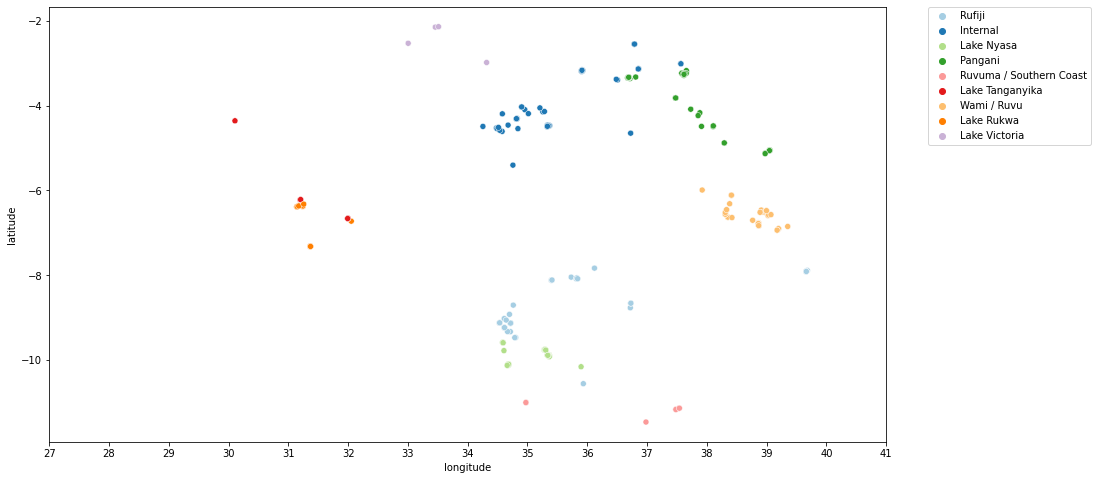

In [ ]:
#where do we find the strange values for amount tsh?
plt.figure(figsize = (15,8))
ax = sns.scatterplot(x= amount_tsh_above_6000 ['longitude'], y = amount_tsh_above_6000 ['latitude'], hue = amount_tsh_above_6000 ['basin'], palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticks(range(27 ,42))
#ax.set_yticks(range(0, -12))
plt.show()

Setting any value above 6000 to 6000 is not a perfect solution since some of the spots are location in areas that most certainly don't have this altitude, but it is better than keeping the very large values.

In [ ]:
#set any value for amount_tsh that is greater than or equal to 6000 to 6000
cleaned['amount_tsh'].loc[cleaned['amount_tsh'] >= 6000] = 6000

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


**GPS height**

Tanzania is not located below sealevel, so any negative value for gps height cannot be correct. The normal error is gps altitude is is +- 15 meter and this applies 95% of the time. The other 5% of the time you can have any value.

In [ ]:
#gps height has 1860 where the altitude is lower than 0
negative_altitude = cleaned[cleaned['gps_height']<0]
len(negative_altitude)


1881

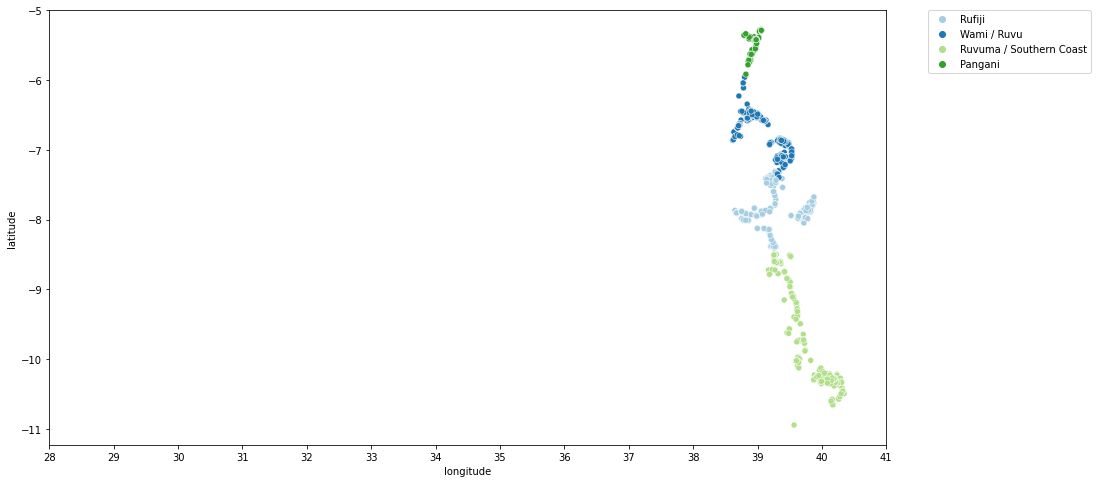

In [ ]:
#where do we find the records with very large amounts_tsh?
plt.figure(figsize = (15,8))
ax = sns.scatterplot(x= negative_altitude ['longitude'], y = negative_altitude ['latitude'], hue = negative_altitude ['basin'], palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticks(range(28 ,42))
plt.show()

The negative values for altitude are all located along the coast where a value of zero (or close to zero) would be more realistic. I will therefore reset any negative value to zero.

In [ ]:
#set any negative value for altitide to zero
cleaned['gps_height'].loc[cleaned['gps_height'] <0] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#reprint data quality report
data_types = pd.DataFrame(
    cleaned [numerical].dtypes,
    columns=['Data Type'])

missing_data = pd.DataFrame(
    cleaned [numerical].isnull().sum(),
    columns=['Missing Values'])

unique_values = pd.DataFrame(
    columns=['Unique Values']
)
for row in list(cleaned [numerical].columns.values):
    unique_values.loc[row] = [cleaned [numerical][row].nunique()]

maximum_values = pd.DataFrame(
    columns=['Maximum Value'])
for row in list(cleaned [numerical].columns.values):
    maximum_values.loc[row] = [cleaned [numerical][row].max()]

minimum_values = pd.DataFrame(
    columns=['Minimum Value'])
for row in list(cleaned [numerical].columns.values):
    minimum_values.loc[row] = [cleaned [numerical][row].min()]

count_values = pd.DataFrame(
    columns=['Count Value'])
for row in list(cleaned [numerical].columns.values):
    count_values.loc[row] = [cleaned[numerical][row].count()]

mean_values = pd.DataFrame(
    columns=['Mean Value'])
for row in list(cleaned [numerical].columns.values):
    mean_values.loc[row] = [cleaned [numerical][row].mean()]

quartile_1 = pd.DataFrame(
    columns=['1st Quartile'])
for row in list(cleaned [numerical].columns.values):
    quartile_1.loc[row] = [cleaned [numerical][row].quantile(0.25)]

median = pd.DataFrame(
    columns=['Median'])
for row in list(cleaned [numerical].columns.values):
    median.loc[row] = [cleaned [numerical][row].quantile(0.5)]

quartile_3 = pd.DataFrame(
    columns=['3rd Quartile'])
for row in list(cleaned [numerical].columns.values):
    quartile_3.loc[row] = [cleaned [numerical][row].quantile(0.75)]

dq_report_num = data_types.join(count_values).join(missing_data).join(unique_values).join(minimum_values).join(maximum_values).join(mean_values).join(quartile_1).join(median).join(quartile_3)
dq_report_num['Missing %'] = (dq_report_num['Missing Values'] / len(cleaned[numerical]) *100)
dq_report_num

Data Type Count Value  Missing Values Unique Values  \
amount_tsh                float64       22201           52049            65   
date_recorded      datetime64[ns]       74250               0           369   
gps_height                float64       48601           25649          2396   
longitude                 float64       71981            2269         71869   
latitude                  float64       74250               0         71869   
population                float64       47416           26834          1127   
construction_year         float64       48281           25969            54   

                         Minimum Value        Maximum Value  \
amount_tsh                         0.2                 6000   
date_recorded      2001-03-26 00:00:00  2013-12-03 00:00:00   
gps_height                           0                 2777   
longitude                      29.6071              40.3452   
latitude                      -11.6494               -2e-08   
population                           1                30500   
construction_year                 1960                 2013   

                                      Mean Value         1st Quartile  \
amount_tsh                               786.407                   50   
date_recorded      2012-03-28 09:51:49.527267072  2011-04-01 00:00:00   
gps_height                               1017.75                  390   
longitude                                35.1484              33.2777   
latitude                                -5.70177             -8.52567   
population                               283.043                   40   
construction_year                        1996.87                 1988   

                                Median         3rd Quartile  Missing %  
amount_tsh                         250                 1000  70.099663  
date_recorded      2012-10-10 00:00:00  2013-02-09 00:00:00   0.000000  
gps_height                        1166                 1497  34.544108  
longitude                      35.0071              37.2374   3.055892  
latitude                      -5.02654             -3.32506   0.000000  
population                         150                  328  36.140067  
construction_year                 2000                 2008  34.975084

**Categorical features**

**Construction year**

In [ ]:
cleaned['construction_year'].unique()

array([1999., 2010., 2009., 1986.,   nan, 2011., 1987., 1991., 1978.,
       1992., 2008., 1974., 2000., 2002., 2004., 1972., 2003., 1980.,
       2007., 1973., 1985., 1970., 1995., 2006., 1962., 2005., 1997.,
       2012., 1996., 1977., 1983., 1984., 1990., 1982., 1976., 1988.,
       1989., 1975., 1960., 1961., 1998., 1963., 1971., 1994., 1968.,
       1993., 2001., 1979., 1967., 2013., 1969., 1981., 1964., 1966.,
       1965.])

In [ ]:
cleaned[categorical].columns

Index(['status_group', 'funder', 'installer', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

There are some categorical features that have a zero category:
funder, installer,  num_private and district_code. With the exception of district_code these are all features with high cardinality which I won't use during modelling. I checked records with district code 0 and they all lay have the same value for basin, region, region_code, lga etc. I therefore think these are not random missing values, but true district codes.

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
cleaned['district_code'].unique()

array(['5', '2', '4', '63', '1', '8', '3', '6', '43', '7', '23', '33',
       '53', '62', '60', '30', '13', '0', '80', '67'], dtype=object)

In [ ]:
#save finished dataframe 
#cleaned.to_csv("cleaned.csv")

####**3.2 Outliers and skewness**

**Population**

The boxplot and previous kde plot show that populaton has a problematic distribution. If we consider that any village that hase a population greater than  mean + 3 x stdev (i.e. 1.976 inhabitants), we would find 791 towns. Only 7 towns have 10.000 or more inhabitants. I have no reason to believe that these are true outliers. I will deal with the skewed distribution and try to create a feature that will bin the population.

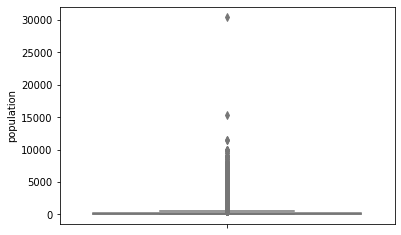

In [ ]:
ax =sns.boxplot(  y="population",  data = raw, palette = "Paired")

In [ ]:
mean = cleaned['population'].mean()
std = cleaned['population'].std()
outlier = mean + 3* std
print(mean)
print(std)
print(outlier)

283.04262274337776
564.413841610112
1976.2841475737137


In [ ]:
#number of records with outlier population
outlier_population = cleaned[cleaned['population']>1976]
print(len(outlier_population))
print(len(raw['population']))

791
74250


In [ ]:
#number of records 10.000 or more inhabitants
outlier_population = cleaned[cleaned['population']>=10000]
print(len(outlier_population))


7


####**3.3 Missingness**

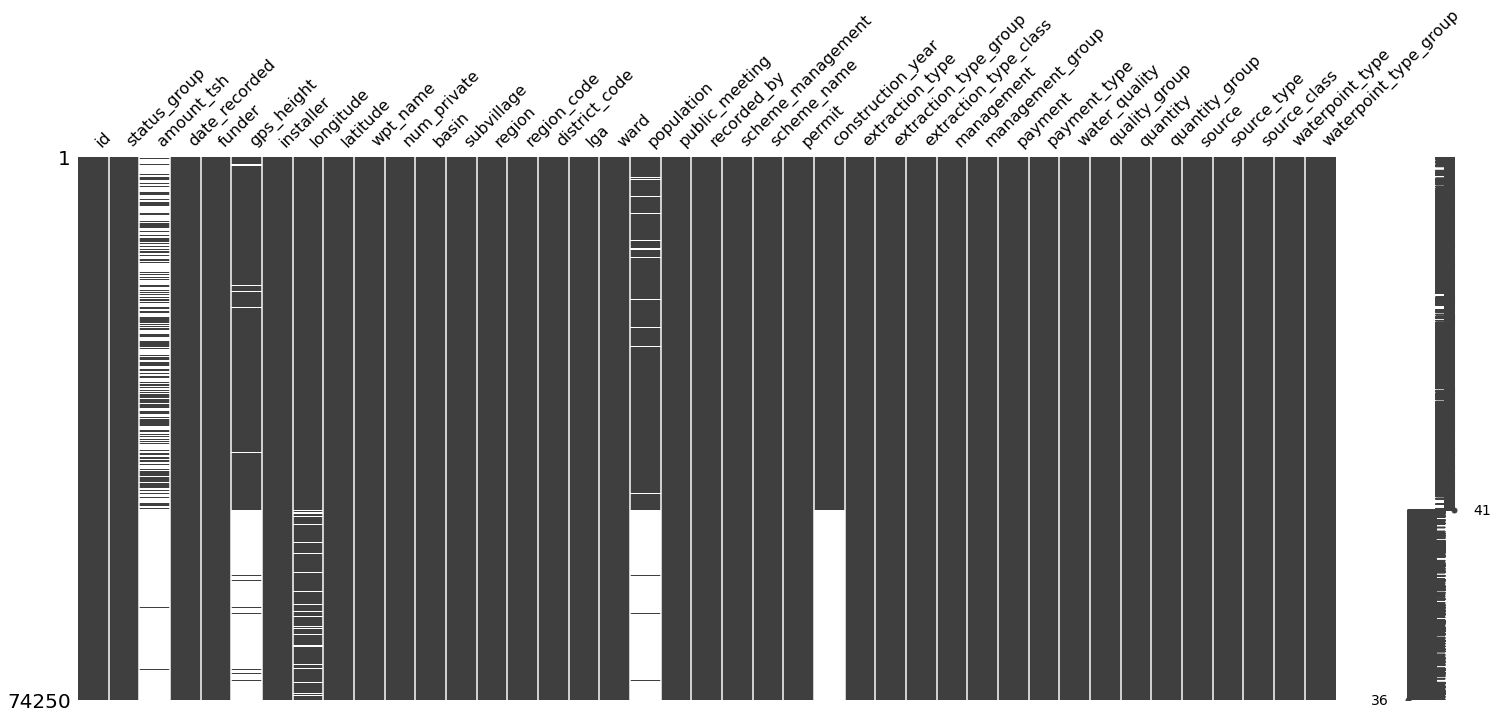

In [ ]:
#there is a clear relation between missing values in gps_heigt, population, construction year and to some degree longitude
sorted_values = cleaned.sort_values('construction_year')
msno.matrix(sorted_values)

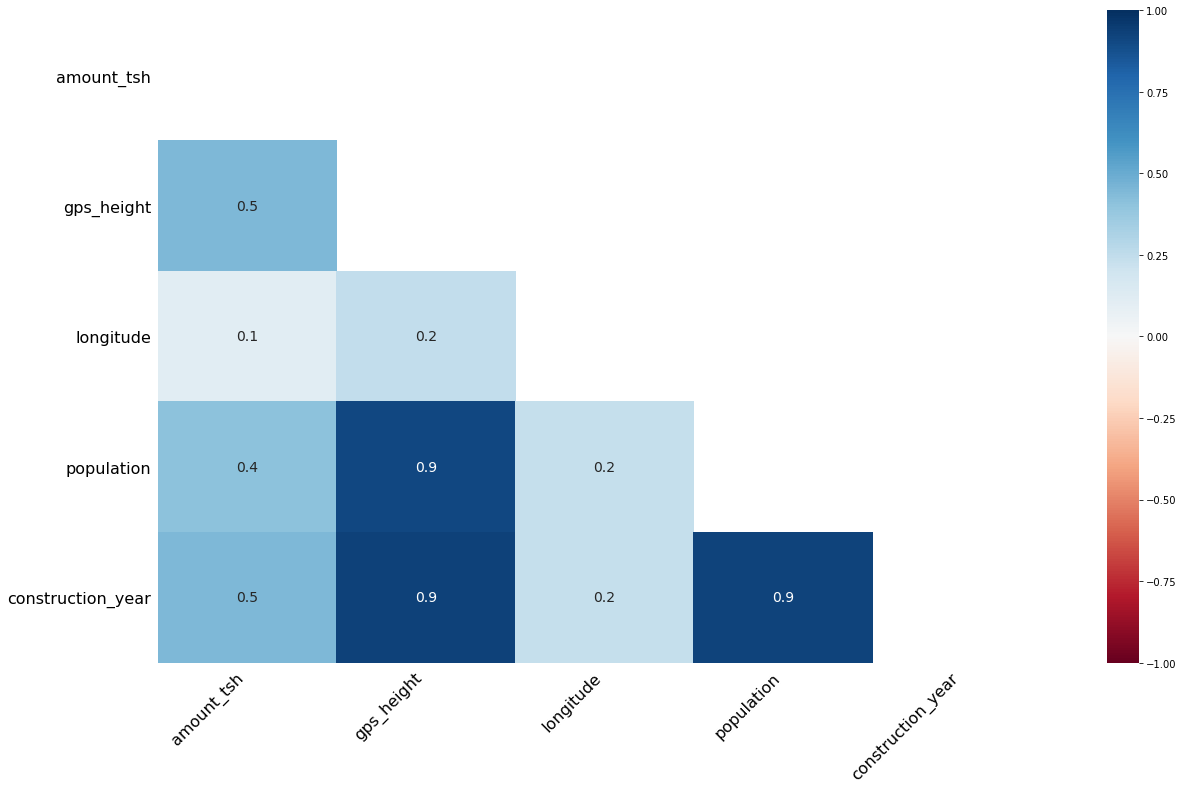

In [ ]:
#strong correlation in missingness
msno.heatmap(cleaned)

Na het imputen valt me op dat er meer construction_year in de 1980-2000 range an minder in begin 2000 zijn. DAarnaast is er meer missing values rond de 1200 m.

In [ ]:
mbeya = cleaned[cleaned['longitude']=="Mbeya"]
mbeya['longitude'].unique()

array([], dtype=float64)

In [ ]:
df = (cleaned.drop('region', 1)
        .isna()
        .groupby(cleaned['region'].fillna('NaN'))
        .mean ()
        .rename_axis(None)
        .T)


In [ ]:
test = df.loc[["amount_tsh", "gps_height", "longitude", "latitude", "construction_year", "population"]]
#test = (test*100)
test.head()

Arusha Dar es Salaam Dodoma     Iringa Kagera     Kigoma  \
amount_tsh         0.724398      0.344118      1   0.348992      1   0.469573   
gps_height                0    0.00490196      1          0      1          0   
longitude                 0             0      0          0      0          0   
latitude                  0             0      0          0      0          0   
construction_year  0.014595     0.0196078      1  0.0712229      1  0.0031135   

                  Kilimanjaro       Lindi     Manyara        Mara Mbeya  \
amount_tsh           0.539316    0.701042    0.641481    0.815993     1   
gps_height                  0  0.00208333           0           0     1   
longitude                   0           0           0           0     0   
latitude                    0           0           0           0     0   
construction_year  0.00691664   0.0708333  0.00811359  0.00815993     1   

                    Morogoro      Mtwara    Mwanza       Pwani        Rukwa  \
amount_tsh          0.505558    0.599347  0.985887    0.454518     0.629795   
gps_height         0.0615324  0.00139925  0.879138  0.00840588            0   
longitude                  0           0  0.259174           0            0   
latitude                   0           0         0           0            0   
construction_year  0.0047638   0.0485075  0.882987   0.0675473  0.000892061   

                       Ruvuma Shinyanga     Singida Tabora     Tanga  
amount_tsh           0.460073  0.996981    0.607256      1  0.650345  
gps_height                  0  0.965517           0      1  0.194601  
longitude                   0  0.200064           0      0         0  
latitude                    0         0           0      0         0  
construction_year  0.00604961  0.965517  0.00433754      1  0.037037

####**3.5 Impute missing data**

Because the data is not missing at random, missing values will be imputed using MICE

In [ ]:
#create a copy of cleaned df
cleaned_imputed = cleaned.copy()


In [ ]:
cleaned_imputed.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman      1390.0   
1   8776      functional         NaN    2013-03-06       Grumeti      1399.0   
2  34310      functional        25.0    2013-02-25  Lottery Club       686.0   
3  67743  non functional         NaN    2013-01-28        Unicef       263.0   
4  19728      functional         NaN    2011-07-13   Action In A         NaN   

      installer  longitude   latitude              wpt_name num_private  \
0         Roman  34.938093  -9.856322                  none           0   
1       GRUMETI  34.698766  -2.147466              Zahanati           0   
2  World vision  37.460664  -3.821329           Kwa Mahundi           0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu           0   
4       Artisan  31.130847  -1.825359               Shuleni           0   

                     basin  subvillage   region region_code district_code  \
0               Lake Nyasa    Mnyusi B   Iringa          11             5   
1            Lake Victoria     Nyamara     Mara          20             2   
2                  Pangani     Majengo  Manyara          21             4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara          90            63   
4            Lake Victoria  Kyanyamisa   Kagera          18             1   

         lga        ward population public_meeting              recorded_by  \
0     Ludewa    Mundindi      109.0           True  GeoData Consultants Ltd   
1  Serengeti       Natta      280.0            nan  GeoData Consultants Ltd   
2  Simanjiro     Ngorika      250.0           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu       58.0           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi        nan           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit construction_year  \
0               VWC                        Roman  False            1999.0   
1             Other                          nan   True            2010.0   
2               VWC  Nyumba ya mungu pipe scheme   True            2009.0   
3               VWC                          nan   True            1986.0   
4               nan                          nan   True               nan   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe multiple    communal standpipe  


In [ ]:
#optional: convert construction year to integer

#.astype int didn't work so this is a work around
col=np.array(cleaned_imputed['construction_year'], np.int16)
cleaned_imputed['construction_year']=col

#set all numerical zero's to np.nan
cleaned_imputed['construction_year']= cleaned_imputed['construction_year'].replace(0, np.nan)


In [ ]:
#create a list of all categorical features
categorical_cols = [cname for cname in cleaned_imputed .columns if
                    cleaned_imputed [cname].dtype == "object"]

print(categorical_cols)

['status_group', 'date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [ ]:
#oHE crashes when including all features, so I will only include the low cardinality ones
categorical_cols_low_cardinality = ['basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group']

In [ ]:
# one hot encoding of low cardinality features encoded low_cardinality
ohe = pd.get_dummies(cleaned_imputed [categorical_cols_low_cardinality], prefix="OHE")
 
# Concatenate one hot encoded features to full dataframe
cleaned_imputed_ohe = pd.concat([cleaned_imputed , ohe], axis=1)

In [ ]:
#drop redundant features 
to_drop = ['date_recorded', 'status_group', 'funder', 'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
cleaned_imputed_ohe= cleaned_imputed_ohe.drop(to_drop, axis=1)

In [ ]:
#split data in train and test based on ID
mice_train = cleaned_imputed_ohe[cleaned_imputed_ohe["id"].isin(train_values["id"])]
mice_test =  cleaned_imputed_ohe[cleaned_imputed_ohe["id"].isin(test_values["id"])]


In [ ]:
#create mice imputer
mice_imputer = IterativeImputer()

#fit and transform on train and transform test
mice_train.iloc[:, :] = np.round(mice_imputer.fit_transform(mice_train))
mice_test.iloc[:, :] = np.round(mice_imputer.transform(mice_test))

https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

In [ ]:
#save finished dataframe 
#cleaned_imputed_ohe.to_csv("cleaned_imputed_ohe.csv")

In [ ]:
#concatenate train and test
cleaned_imputed_ohe= pd.concat([mice_train, mice_test])


In [ ]:
#create another copy of the original dataframe
cleaned_imputed= cleaned.copy()

#take the imputed columns from the imputed dataframe and replace them in the original dataframe
cleaned_imputed[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']] = cleaned_imputed_ohe[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']] 
cleaned_imputed.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman      1390.0   
1   8776      functional       -65.0    2013-03-06       Grumeti      1399.0   
2  34310      functional        25.0    2013-02-25  Lottery Club       686.0   
3  67743  non functional       920.0    2013-01-28        Unicef       263.0   
4  19728      functional      -373.0    2011-07-13   Action In A      2054.0   

      installer  longitude  latitude              wpt_name num_private  \
0         Roman       35.0     -10.0                  none           0   
1       GRUMETI       35.0      -2.0              Zahanati           0   
2  World vision       37.0      -4.0           Kwa Mahundi           0   
3        UNICEF       38.0     -11.0  Zahanati Ya Nanyumbu           0   
4       Artisan       31.0      -2.0               Shuleni           0   

                     basin  subvillage   region region_code district_code  \
0               Lake Nyasa    Mnyusi B   Iringa          11             5   
1            Lake Victoria     Nyamara     Mara          20             2   
2                  Pangani     Majengo  Manyara          21             4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara          90            63   
4            Lake Victoria  Kyanyamisa   Kagera          18             1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi       109.0           True  GeoData Consultants Ltd   
1  Serengeti       Natta       280.0            nan  GeoData Consultants Ltd   
2  Simanjiro     Ngorika       250.0           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu        58.0           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi       256.0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False             1999.0   
1             Other                          nan   True             2010.0   
2               VWC  Nyumba ya mungu pipe scheme   True             2009.0   
3               VWC                          nan   True             1986.0   
4               nan                          nan   True             1999.0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe multiple    communal standp

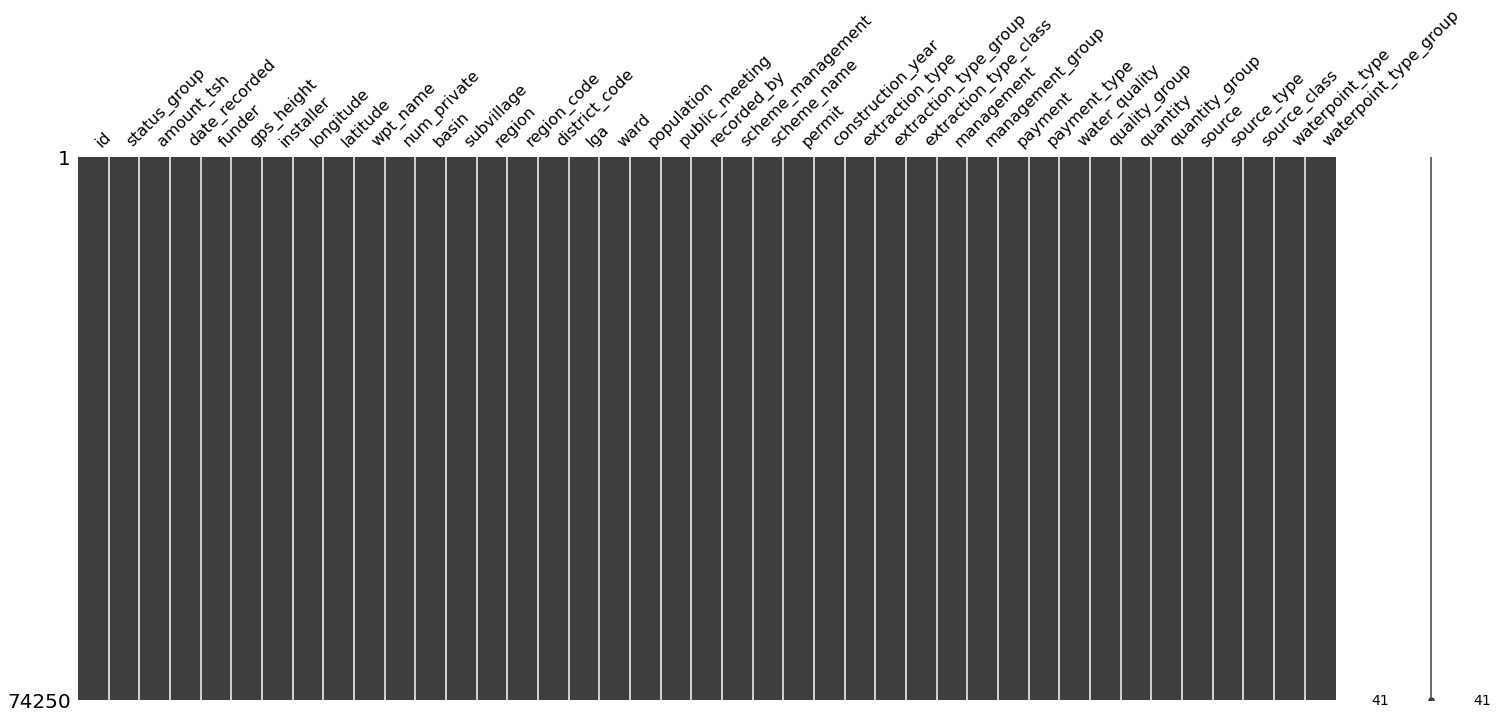

In [ ]:
#there are no more missing values
sorted_values = cleaned_imputed.sort_values('construction_year')
msno.matrix(sorted_values)

In [ ]:
#cleaned_imputed.to_csv("cleaned_imputed_waterpumps.csv")

In [ ]:
#function to create density plot
def impute_checker (feature):
  cleaned[feature].plot(kind='kde', c='black')
  cleaned_imputed[feature].plot(kind='kde', style = "--", c= 'red')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.show()


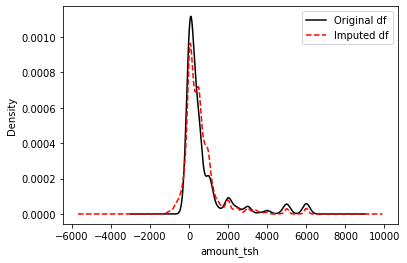

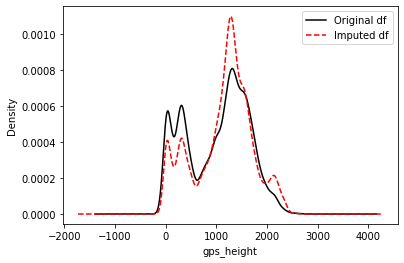

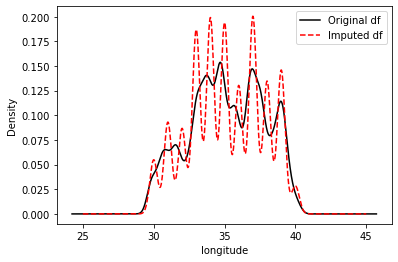

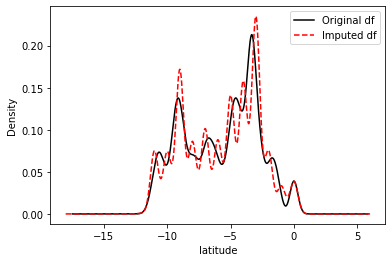

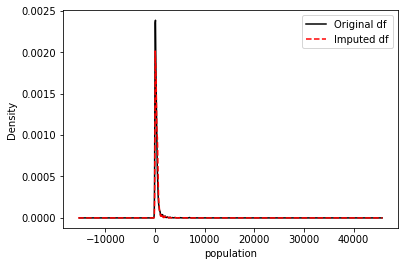

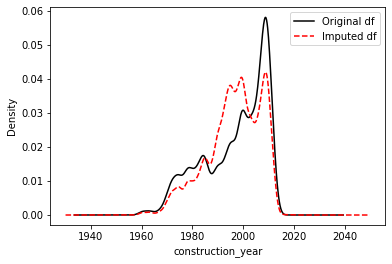

In [ ]:
#plot the distribution of each imputed feature before and after imputing
for feature in ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']:
  impute_checker(feature)

In [ ]:
#cleaned_imputed.to_csv("cleaned_imputed_waterpumps.csv")

**Impuing cycles with sample of data**

In [ ]:
cleaned_imputed = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/cleaned_imputed_waterpumps.csv')
cleaned_imputed = cleaned_imputed.drop('Unnamed: 0', axis=1)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#oHE crashes when including all features, so I will only include the low cardinality ones
categorical_cols_low_cardinality = ['basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group']

In [ ]:
# one hot encoding of low cardinality features encoded low_cardinality
ohe = pd.get_dummies(cleaned_imputed [categorical_cols_low_cardinality], prefix="OHE")
 
# Concatenate one hot encoded features to full dataframe
cleaned_imputed_ohe = pd.concat([cleaned_imputed , ohe], axis=1)

In [ ]:
cleaned_imputed_ohe_sample = cleaned_imputed_ohe.sample(n=10000, random_state=1)

In [ ]:
X = cleaned_imputed_ohe_sample[cleaned_imputed_ohe_sample["id"].isin(train_values["id"])]
X = X.drop(["id", "status_group", 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', "scheme_name", "date_recorded", 'basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group'], axis=1)



In [ ]:
y =cleaned_imputed_ohe_sample[cleaned_imputed_ohe_sample["id"].isin(train_labels["id"])]

#y_mapper = { "functional": 1, "non functional": 2, "functional needs repair": 3} 
#y["status_group"] = y["status_group"] .replace(y_mapper)
y = y["status_group"].to_frame()


>1 0.756 (0.001)
>2 0.759 (0.007)
>3 0.758 (0.006)
>4 0.756 (0.005)
>5 0.759 (0.004)
>6 0.758 (0.007)
>7 0.759 (0.005)
>8 0.758 (0.009)
>9 0.760 (0.006)
>10 0.761 (0.010)
>11 0.760 (0.005)
>12 0.758 (0.008)
>13 0.759 (0.009)
>14 0.759 (0.008)
>15 0.759 (0.006)
>16 0.759 (0.003)
>17 0.762 (0.003)
>18 0.759 (0.006)
>19 0.761 (0.006)
>20 0.759 (0.002)


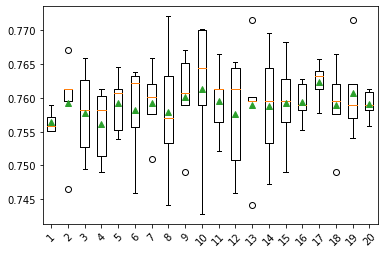

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# evaluate each strategy on the dataset start:20.20 - 21.15
results = list()
strategies = [str(i) for i in range(1, 21)]
for s in strategies:
  pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestClassifier())])
  scores = cross_val_score(pipeline, X, y.values.ravel(), cv=5)
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()
#https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

#####**Determine optiman number of imputation rounds**

In [ ]:
cleaned = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/cleaned.csv', parse_dates = ['date_recorded' ])

cleaned = cleaned.drop('Unnamed: 0', axis=1)

In [ ]:
cleaned[[ 'amount_tsh', 'gps_height', 'longitude', 'latitude' , 'construction_year']] = cleaned[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'construction_year']].astype('float')

cleaned[['id' ]] = cleaned[['id']].astype('int')

cleaned[['status_group',  'date_recorded', 'funder',
       'installer',  'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group']] = cleaned[['status_group',  'date_recorded', 'funder',
       'installer',  'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group']].astype('str')

In [ ]:
#oHE crashes when including all features, so I will only include the low cardinality ones
categorical_cols_low_cardinality = ['basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group']

In [ ]:
# one hot encoding of low cardinality features encoded low_cardinality
ohe = pd.get_dummies(cleaned[categorical_cols_low_cardinality], prefix="OHE")
 
# Concatenate one hot encoded features to full dataframe
cleaned_ohe = pd.concat([cleaned, ohe], axis=1)

In [ ]:
X = cleaned_ohe[cleaned_ohe["id"].isin(train_values["id"])].drop(["id", "status_group", 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', "scheme_name", "date_recorded", 'basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group'],axis=1)

In [ ]:
y =cleaned_ohe[cleaned_ohe["id"].isin(train_labels["id"])]
y = y["status_group"].to_frame()

In [ ]:
cleaned_columns = X.columns

minimum_list_total= []
for column in cleaned_columns: 
  min_values = cleaned_ohe[column].min() 
  minimum_list_total.append(min_values)

#minimum_list_total

In [ ]:
#X has 230 columns

#most important missing values are in first few columns: 7 columns
minimum_list_A = [0.2, 0.0, 29.6071219, -11.64944018, '0', 1.0, 1960.0]

#rest of the columns can be filled with zero's
minimum_list_B = [0] * 223

minimum_list = minimum_list_A + minimum_list_B

In [ ]:
maximum_list_total= []
for column in cleaned_columns: 
  max_values = cleaned_ohe[column].max() 
  maximum_list_total.append(max_values)

#maximum_list_total

In [ ]:
#X has 230 columns

#most important missing values are in first few columns: 7 columns (population and construction year derived from data quality report)
maximum_list_A = [6000.0, 2777.0, 40.34519307, -2e-08, '94', 30500, 2013.0]

#rest of the columns can be filled with ones
maximum_list_B = [1] * 223

maximum_list = maximum_list_A+ maximum_list_B

>1 0.803 (0.003)
>2 0.801 (0.003)
>3 0.801 (0.003)
>4 0.801 (0.003)
>5 0.801 (0.003)
>6 0.801 (0.003)
>7 0.801 (0.003)
>8 0.801 (0.003)
>9 0.801 (0.003)
>10 0.801 (0.003)
>11 0.801 (0.003)
>12 0.801 (0.003)
>13 0.801 (0.003)
>14 0.801 (0.003)
>15 0.801 (0.003)
>16 0.801 (0.003)
>17 0.801 (0.003)
>18 0.801 (0.003)
>19 0.801 (0.003)
>20 0.801 (0.003)


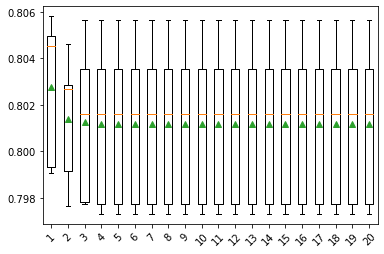

In [ ]:
#https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

#def warn(*args, **kwargs):
    #pass
#import warnings
#warnings.warn = warn


# evaluate each strategy on the dataset start:20.20
results = list()
strategies = [str(i) for i in range(1, 21, 1)]
for s in strategies:
  pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter=int(s), min_value = minimum_list, max_value = maximum_list, skip_complete = True)), ('m', RandomForestClassifier(random_state=1))])
  scores = cross_val_score(pipeline, X, y.values.ravel(), cv=5)
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

#####**final imputation**

In [613]:
cleaned = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/cleaned.csv', parse_dates = ['date_recorded' ])

cleaned = cleaned.drop('Unnamed: 0', axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [614]:
cleaned.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman      1390.0   
1   8776      functional         NaN    2013-03-06       Grumeti      1399.0   
2  34310      functional        25.0    2013-02-25  Lottery Club       686.0   
3  67743  non functional         NaN    2013-01-28        Unicef       263.0   
4  19728      functional         NaN    2011-07-13   Action In A         NaN   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi       109.0           True  GeoData Consultants Ltd   
1  Serengeti       Natta       280.0            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika       250.0           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu        58.0           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi         NaN           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False             1999.0   
1             Other                          NaN   True             2010.0   
2               VWC  Nyumba ya mungu pipe scheme   True             2009.0   
3               VWC                          NaN   True             1986.0   
4               NaN                          NaN   True                NaN   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe mul

In [615]:
#create a copy of cleaned df
cleaned_imputed = cleaned.copy()


In [616]:
#.astype int didn't work so this is a work around
col=np.array(cleaned_imputed['construction_year'], np.int16)
cleaned_imputed['construction_year']=col

col=np.array(cleaned_imputed['population'], np.int16)
cleaned_imputed['population']=col


#set all numerical zero's to np.nan
cleaned_imputed['construction_year']= cleaned_imputed['construction_year'].replace(0, np.nan)
cleaned_imputed['population']= cleaned_imputed['population'].replace(0, np.nan)

In [617]:
#create a list of all categorical features
categorical_cols = [cname for cname in cleaned_imputed .columns if
                    cleaned_imputed [cname].dtype == "object"]

print(categorical_cols)

['status_group', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [618]:
#oHE crashes when including all features, so I will only include the low cardinality ones
categorical_cols_low_cardinality = ['basin','region', 'region_code' ,'district_code','public_meeting','recorded_by','scheme_management','permit','extraction_type','extraction_type_group','extraction_type_class',
                                    'management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group']

In [619]:
# one hot encoding of low cardinality features encoded low_cardinality
ohe = pd.get_dummies(cleaned_imputed [categorical_cols_low_cardinality])
 
# Concatenate one hot encoded features to full dataframe
cleaned_imputed_ohe = pd.concat([cleaned_imputed , ohe], axis=1)

In [620]:
#drop redundant features 
to_drop = ['date_recorded', 'status_group', 'funder', 'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 
           'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type',
           'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
           
cleaned_imputed_ohe= cleaned_imputed_ohe.drop(to_drop, axis=1)

In [621]:
cleaned_imputed_ohe.head()

id  amount_tsh  gps_height  longitude   latitude  population  \
0  69572      6000.0      1390.0  34.938093  -9.856322       109.0   
1   8776         NaN      1399.0  34.698766  -2.147466       280.0   
2  34310        25.0       686.0  37.460664  -3.821329       250.0   
3  67743         NaN       263.0  38.486161 -11.155298        58.0   
4  19728         NaN         NaN  31.130847  -1.825359         NaN   

   construction_year  basin_Internal  basin_Lake Nyasa  basin_Lake Rukwa  \
0             1999.0               0                 1                 0   
1             2010.0               0                 0                 0   
2             2009.0               0                 0                 0   
3             1986.0               0                 0                 0   
4                NaN               0                 0                 0   

   basin_Lake Tanganyika  basin_Lake Victoria  basin_Pangani  basin_Rufiji  \
0                      0                    0              0             0   
1                      0                    1              0             0   
2                      0                    0              1             0   
3                      0                    0              0             0   
4                      0                    1              0             0   

   basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  region_Arusha  \
0                              0                  0              0   
1                              0                  0              0   
2                              0                  0              0   
3                              1                  0              0   
4                              0                  0              0   

   region_Dar es Salaam  region_Dodoma  region_Iringa  region_Kagera  \
0                     0              0              1              0   
1                     0              0              0              0   
2                     0              0              0              0   
3                     0              0              0              0   
4                     0              0              0              1   

   region_Kigoma  region_Kilimanjaro  region_Lindi  region_Manyara  \
0              0                   0             0               0   
1              0                   0             0               0   
2              0                   0             0               1   
3              0                   0             0               0   
4              0                   0             0               0   

   region_Mara  region_Mbeya  region_Morogoro  region_Mtwara  region_Mwanza  \
0            0             0                0              0              0   
1            1             0                0              0              0   
2            0             0                0              0              0   
3            0             0                0              1              0   
4            0             0                0              0              0   

   region_Pwani  region_Rukwa  region_Ruvuma  region_Shinyanga  \
0             0             0              0                 0   
1             0             0              0                 0   
2             0             0              0                 0   
3             0             0              0                 0   
4             0             0              0                 0   

   region_Singida  region_Tabora  region_Tanga  public_meeting_False  \
0               0              0             0                     0   
1               0              0             0                     0   
2               0              0             0                     0   
3               0              0             0                     0   
4               0              0             0                     0   

   public_meeting_True  recorded_by_GeoData Consultants Ltd  \
0               

In [622]:
#split data in train and test based on ID
mice_train = cleaned_imputed_ohe[cleaned_imputed_ohe["id"].isin(train_values["id"])]
mice_test =  cleaned_imputed_ohe[cleaned_imputed_ohe["id"].isin(test_values["id"])]


In [623]:
#most important missing values are in first few columns: 7 columns
minimum_list_A = [0, 0.2, 0.0, 29.6071219, -11.64944018,  1.0, 1960]

#rest of the columns can be filled with zero's
minimum_list_B = [0] * 173

minimum_list = minimum_list_A + minimum_list_B

In [624]:
#X has 180 columns

#most important missing values are in first few columns: 7 columns (population and construction year derived from data quality report)
maximum_list_A = [74247, 6000.0, 2777.0, 40.34519307, -2e-08,  30500, 2013]

#rest of the columns can be filled with ones
maximum_list_B = [1] * 173

maximum_list = maximum_list_A+ maximum_list_B

In [626]:
#create mice imputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html #1 iteration gave the best results 
mice_imputer = IterativeImputer(max_iter=1, min_value = minimum_list, max_value = maximum_list, skip_complete = True, initial_strategy = 'most_frequent')

#fit and transform on train and transform test
#mice_train.iloc[:, :] = np.round(mice_imputer.fit_transform(mice_train))
#mice_test.iloc[:, :] = np.round(mice_imputer.transform(mice_test))

#fit and transform on train and transform test
mice_train.iloc[:, :] = mice_imputer.fit_transform(mice_train)
mice_test.iloc[:, :] = mice_imputer.transform(mice_test)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [627]:
#concatenate train and test
cleaned_imputed_ohe= pd.concat([mice_train, mice_test])
cleaned_imputed_ohe.head()

id   amount_tsh   gps_height  longitude   latitude  population  \
0  69572.0  6000.000000  1390.000000  34.938093  -9.856322  109.000000   
1   8776.0     0.200000  1399.000000  34.698766  -2.147466  280.000000   
2  34310.0    25.000000   686.000000  37.460664  -3.821329  250.000000   
3  67743.0   713.739802   263.000000  38.486161 -11.155298   58.000000   
4  19728.0     0.200000  2031.122122  31.130847  -1.825359  423.028155   

   construction_year  basin_Internal  basin_Lake Nyasa  basin_Lake Rukwa  \
0        1999.000000             0.0               1.0               0.0   
1        2010.000000             0.0               0.0               0.0   
2        2009.000000             0.0               0.0               0.0   
3        1986.000000             0.0               0.0               0.0   
4        1999.943784             0.0               0.0               0.0   

   basin_Lake Tanganyika  basin_Lake Victoria  basin_Pangani  basin_Rufiji  \
0                    0.0                  0.0            0.0           0.0   
1                    0.0                  1.0            0.0           0.0   
2                    0.0                  0.0            1.0           0.0   
3                    0.0                  0.0            0.0           0.0   
4                    0.0                  1.0            0.0           0.0   

   basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  region_Arusha  \
0                            0.0                0.0            0.0   
1                            0.0                0.0            0.0   
2                            0.0                0.0            0.0   
3                            1.0                0.0            0.0   
4                            0.0                0.0            0.0   

   region_Dar es Salaam  region_Dodoma  region_Iringa  region_Kagera  \
0                   0.0            0.0            1.0            0.0   
1                   0.0            0.0            0.0            0.0   
2                   0.0            0.0            0.0            0.0   
3                   0.0            0.0            0.0            0.0   
4                   0.0            0.0            0.0            1.0   

   region_Kigoma  region_Kilimanjaro  region_Lindi  region_Manyara  \
0            0.0                 0.0           0.0             0.0   
1            0.0                 0.0           0.0             0.0   
2            0.0                 0.0           0.0             1.0   
3            0.0                 0.0           0.0             0.0   
4            0.0                 0.0           0.0             0.0   

   region_Mara  region_Mbeya  region_Morogoro  region_Mtwara  region_Mwanza  \
0          0.0           0.0              0.0            0.0            0.0   
1          1.0           0.0              0.0            0.0            0.0   
2          0.0           0.0              0.0            0.0            0.0   
3          0.0           0.0              0.0            1.0            0.0   
4          0.0           0.0              0.0            0.0            0.0   

   region_Pwani  region_Rukwa  region_Ruvuma  region_Shinyanga  \
0           0.0           0.0            0.0               0.0   
1           0.0           0.0            0.0               0.0   
2           0.0           0.0            0.0               0.0   
3           0.0           0.0            0.0               0.0   
4           0.0           0.0            0.0               0.0   

   region_Singida  region_Tabora  region_Tanga  public_meeting_False  \
0             0.0            0.0           0.0                   0.0   
1             0.0            0.0           0.0                   0.0   
2             0.0            0.0           0.0                   0.0   
3             0.0            0.0           0.0                   0.0   
4             0.0            0.0           0.0                   0.0   

   public_meeting_True  recorded_by_GeoData Consultants L

In [632]:
#take the imputed columns from the imputed dataframe and replace them in the original dataframe (only for the features that we are interested in, i.e. we are not interested in the high cardinality features)
cleaned_imputed[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'public_meeting', 'permit']] = cleaned_imputed_ohe[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'public_meeting_True', 'permit_True']] 

cleaned_imputed[['construction_year', 'population', 'gps_height']] = cleaned_imputed[['construction_year', 'population', 'gps_height']] .astype('int')
cleaned_imputed[['amount_tsh']] = round(cleaned_imputed[['amount_tsh']]  .astype('float'),1)

cleaned_imputed.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.2    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional       713.7    2013-01-28        Unicef         263   
4  19728      functional         0.2    2011-07-13   Action In A        2031   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population  public_meeting              recorded_by  \
0     Ludewa    Mundindi         109             1.0  GeoData Consultants Ltd   
1  Serengeti       Natta         280             0.0  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250             1.0  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58             1.0  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi         423             1.0  GeoData Consultants Ltd   

  scheme_management                  scheme_name  permit  construction_year  \
0               VWC                        Roman     0.0               1999   
1             Other                          NaN     1.0               2010   
2               VWC  Nyumba ya mungu pipe scheme     1.0               2009   
3               VWC                          NaN     1.0               1986   
4               NaN                          NaN     1.0               1999   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal s

In [633]:
##some missing values remained because fancy imputer imputed a zero for each category of these features. Normally I wouldn't have noticed, but because I'm trying to return a df without missing data (in the relevant features), this missing data stands out.
#i will return the mode for these features
for column in ['funder', 'installer', 'subvillage', 'scheme_management', 'scheme_name']:
    cleaned_imputed[column].fillna(cleaned_imputed[column].mode()[0], inplace=True)

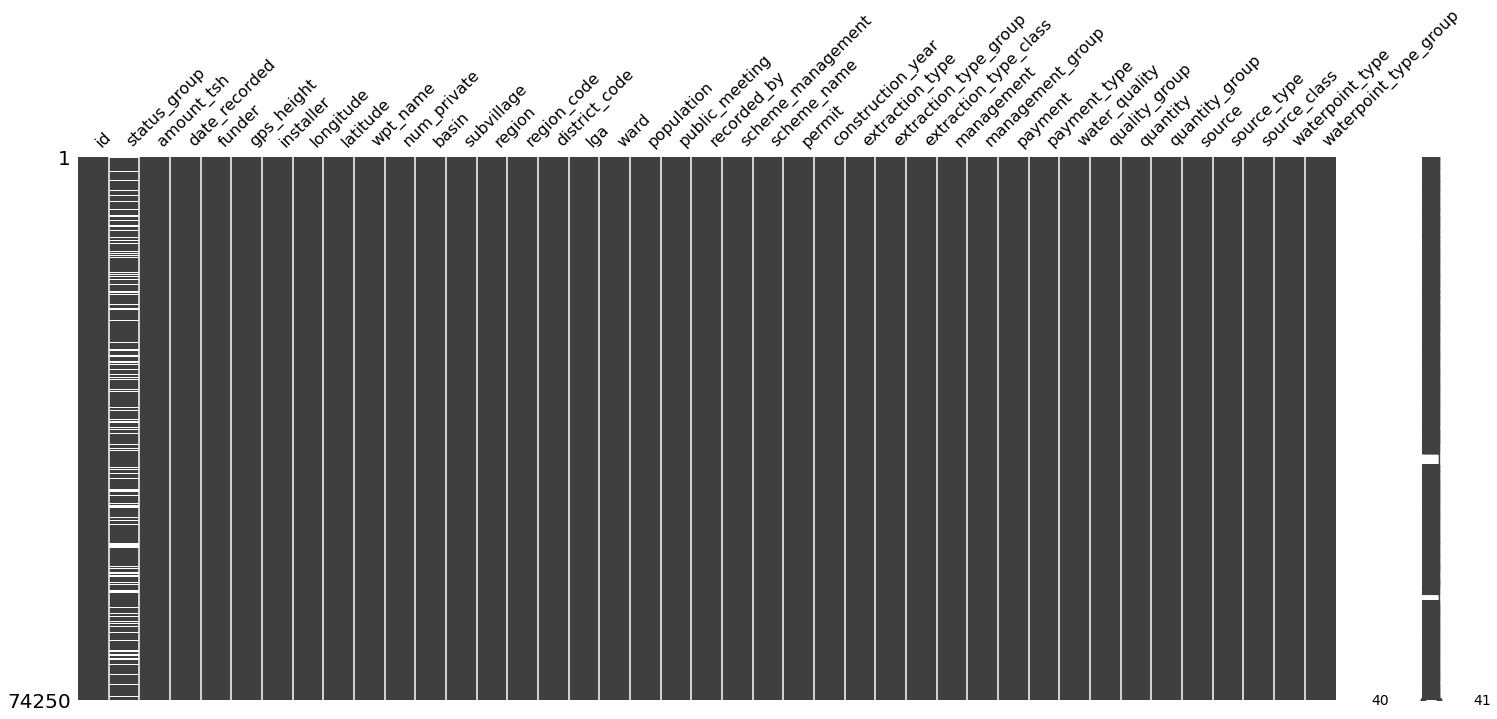

In [634]:
#there are no more missing values (note: missing data only remains in high cardinality features that I will not use)
sorted_values = cleaned_imputed.sort_values('construction_year')
msno.matrix(sorted_values)

In [635]:
#function to create density plot
def impute_checker (feature):
  cleaned[feature].plot(kind='kde', c='black')
  cleaned_imputed[feature].plot(kind='kde', style = "--", c= 'red')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.show()

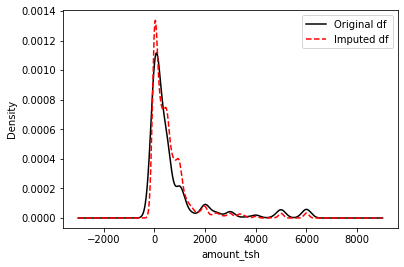

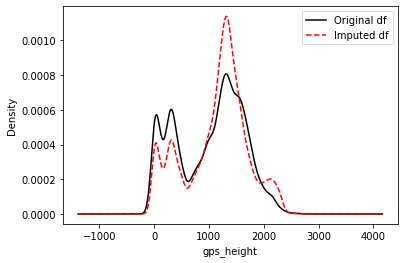

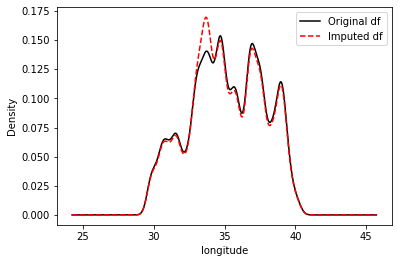

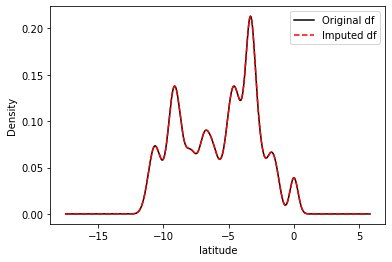

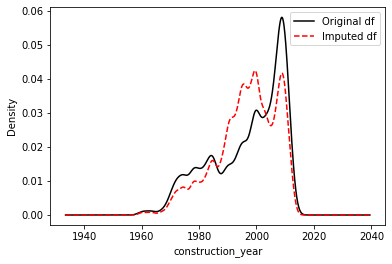

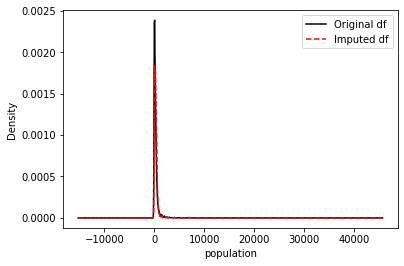

In [636]:
#plot the distribution of each imputed feature before and after imputing. Note: construction year is most poorly imputed
for feature in ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'construction_year', 'population']:
  impute_checker(feature)

In [637]:
#save imputed df
#cleaned_imputed.to_csv("cleaned_imputed_waterpumps.csv")

#**4 Feature Engineering**

####**4.1 Is missing**

If the presence or absence of a feature would be an indicator for the status of the waterpump, we could create a feature indicating wheter or not a value is present for a given feature.

In [638]:
engineered = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/cleaned_imputed_waterpumps.csv')
engineered= engineered.drop("Unnamed: 0", axis=1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [639]:
#load the un-imputed dataset
cleaned = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/cleaned.csv', parse_dates = ['date_recorded' ])
cleaned  = cleaned .drop("Unnamed: 0", axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [640]:
#create a copy of the cleaned dataframe
missing = cleaned.copy()


In [641]:
#create function that prints "missing" when value is missing and "present" when value is not
def missingness(feature):
  missing[feature] = np.where(missing[feature].isnull(),"True","False")

In [642]:
#apply function to dataframe
for feature in missing.columns:
  missingness(feature)

In [643]:

#add statusgroup feature to the new dataframe
missing['status_group_original'] = cleaned['status_group']
missing.head()

id status_group amount_tsh date_recorded funder gps_height installer  \
0  False        False      False         False  False      False     False   
1  False        False       True         False  False      False     False   
2  False        False      False         False  False      False     False   
3  False        False       True         False  False      False     False   
4  False        False       True         False  False       True     False   

  longitude latitude wpt_name num_private  basin subvillage region  \
0     False    False    False       False  False      False  False   
1     False    False    False       False  False      False  False   
2     False    False    False       False  False      False  False   
3     False    False    False       False  False      False  False   
4     False    False    False       False  False      False  False   

  region_code district_code    lga   ward population public_meeting  \
0       False         False  False  False      False          False   
1       False         False  False  False      False           True   
2       False         False  False  False      False          False   
3       False         False  False  False      False          False   
4       False         False  False  False       True          False   

  recorded_by scheme_management scheme_name permit construction_year  \
0       False             False       False  False             False   
1       False             False        True  False             False   
2       False             False       False  False             False   
3       False             False        True  False             False   
4       False              True        True  False              True   

  extraction_type extraction_type_group extraction_type_class management  \
0           False                 False                 False      False   
1           False                 False                 False      False   
2           False                 False                 False      False   
3           False                 False                 False      False   
4           False                 False                 False      False   

  management_group payment payment_type water_quality quality_group quantity  \
0            False   False        False         False         False    False   
1            False   False        False         False         False    False   
2            False   False        False         False         False    False   
3            False   False        False         False         False    False   
4            False   False        False         False         False    False   

  quantity_group source source_type source_class waterpoint_type  \
0          False  False       False        False           False   
1          False  False       False        False           False   
2          False  False       False        False           False   
3          False  False       False        False           False   
4          False  False       False        False           False   

  waterpoint_type_group status_group_original  
0                 False            functional  
1                 False            functional  
2                 False            functional  
3                 False        non functional  
4                 False            functional

In [258]:
#create boxplot function
def barplotter_missing (dataset, feature):
  ax1 = sns.displot(dataset, x =feature,  stat = 'density', discrete = True, color = 'black')
  ax1.set(title=feature, xlabel = "")
  ax1.set_xticklabels( rotation = 80)
  ax2 = sns.displot(dataset, x =feature, col = 'status_group_original', stat = 'density', discrete = True, color = 'lightblue')
  ax2.set(xlabel = "")
  ax2.set_xticklabels( rotation = 80)
  plt.show()

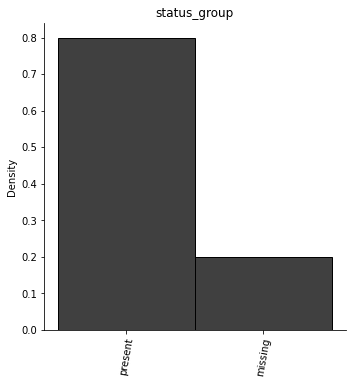

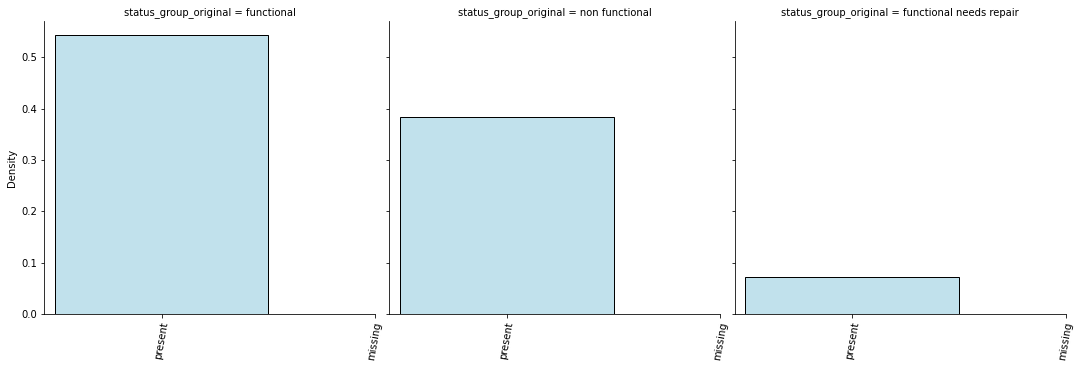

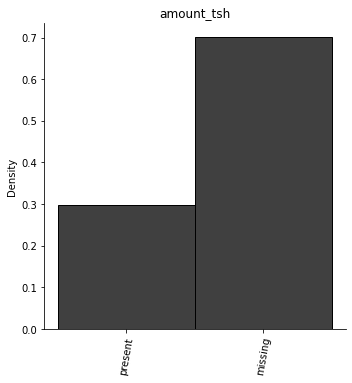

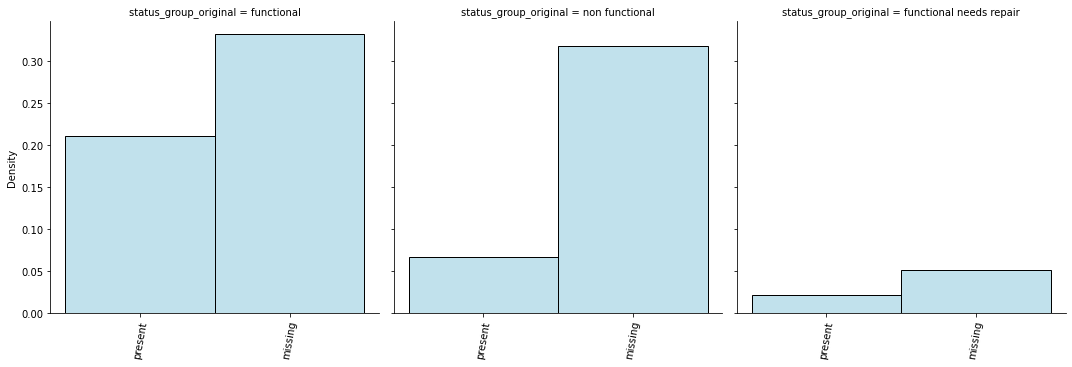

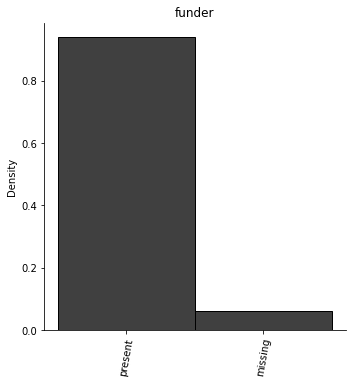

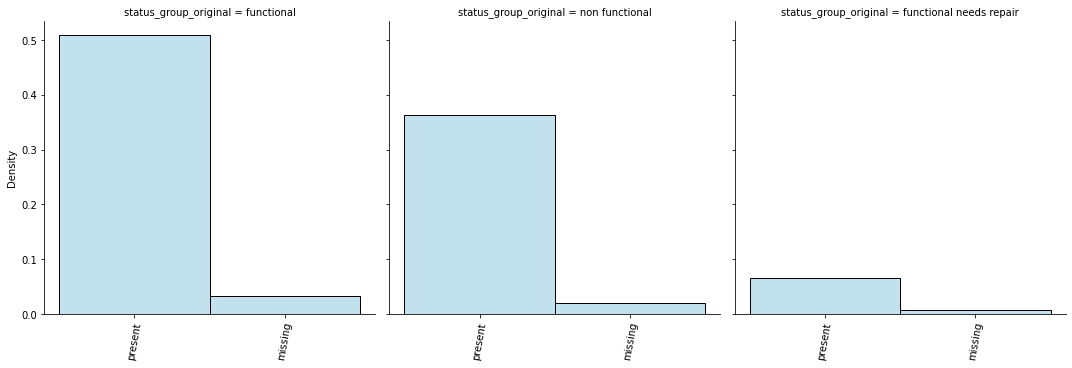

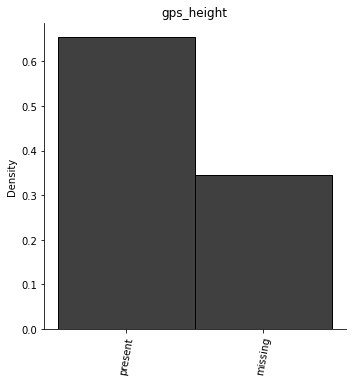

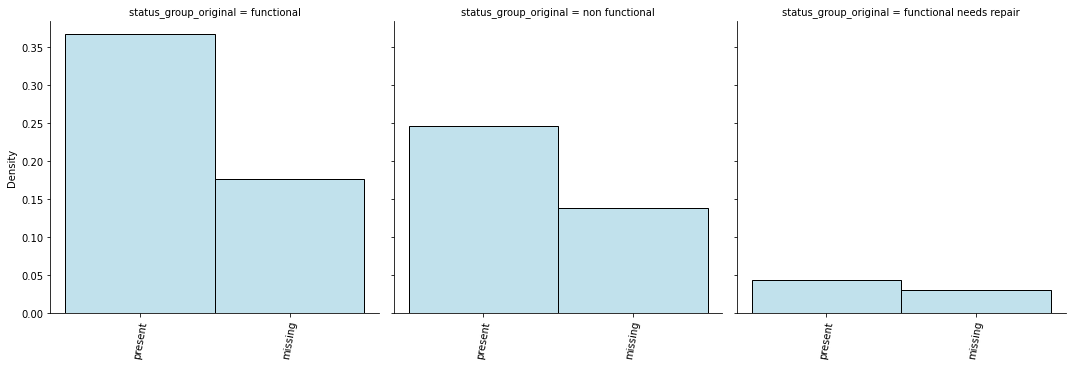

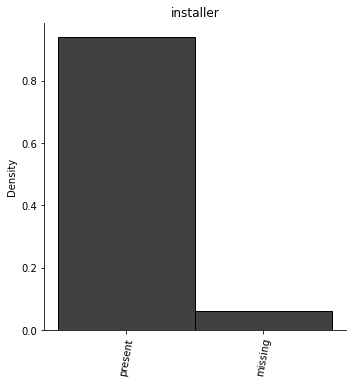

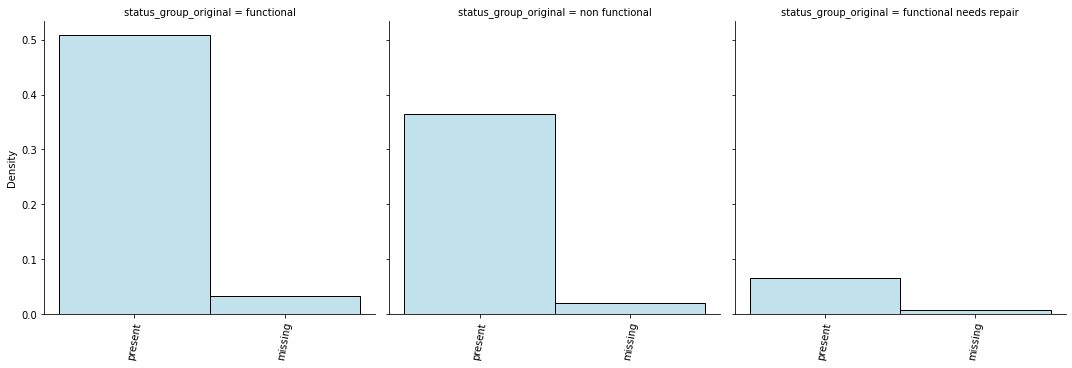

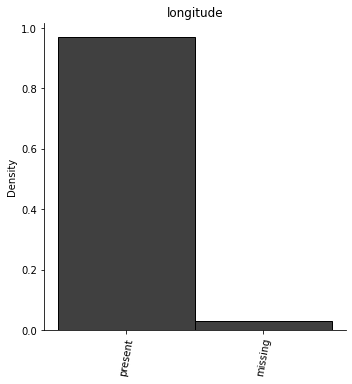

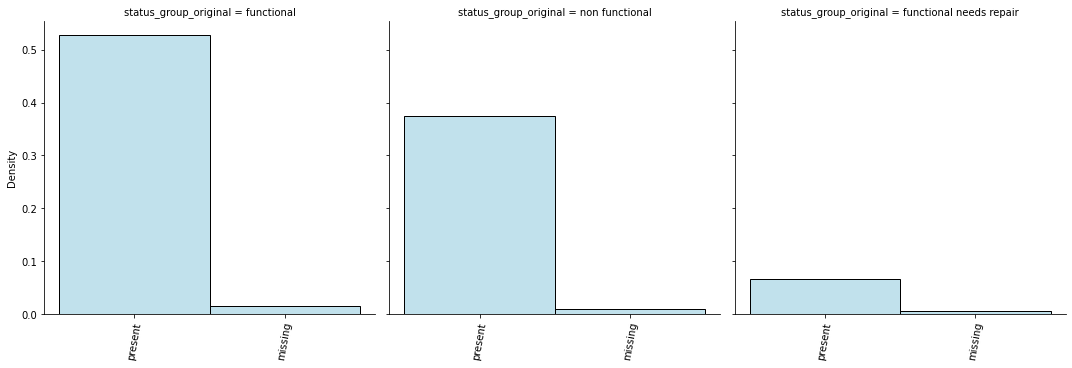

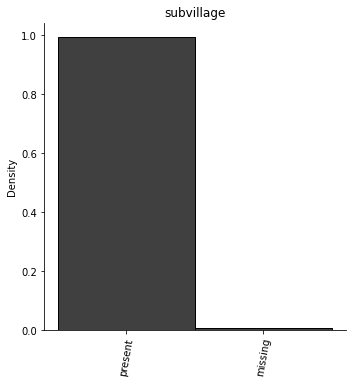

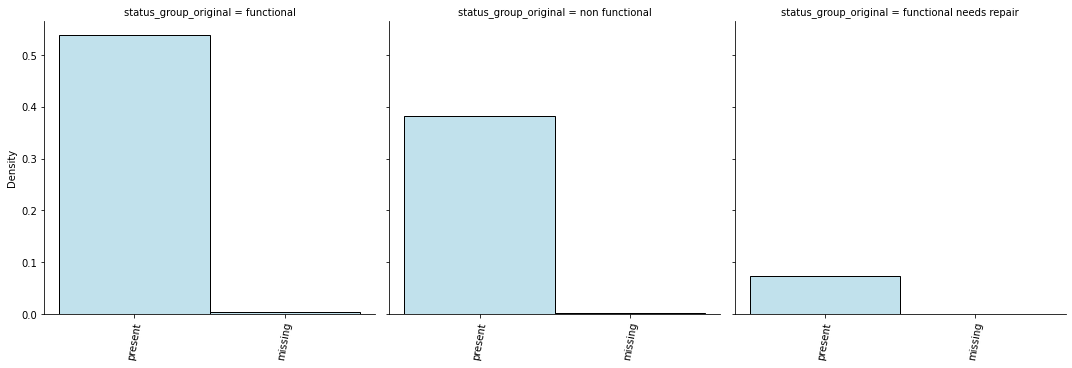

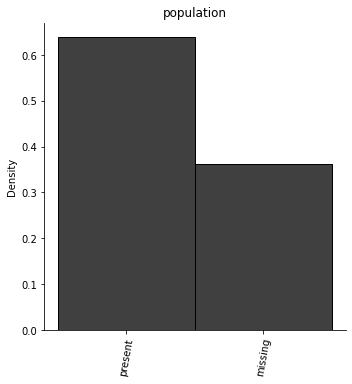

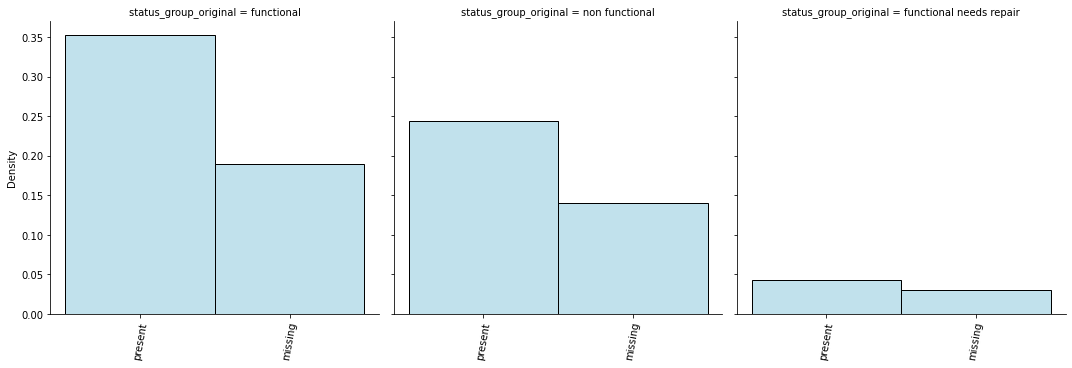

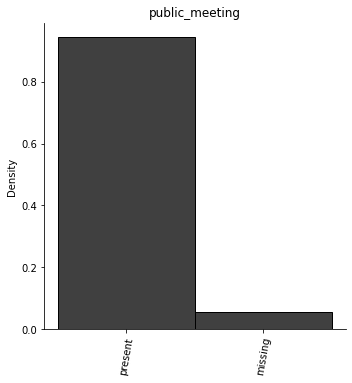

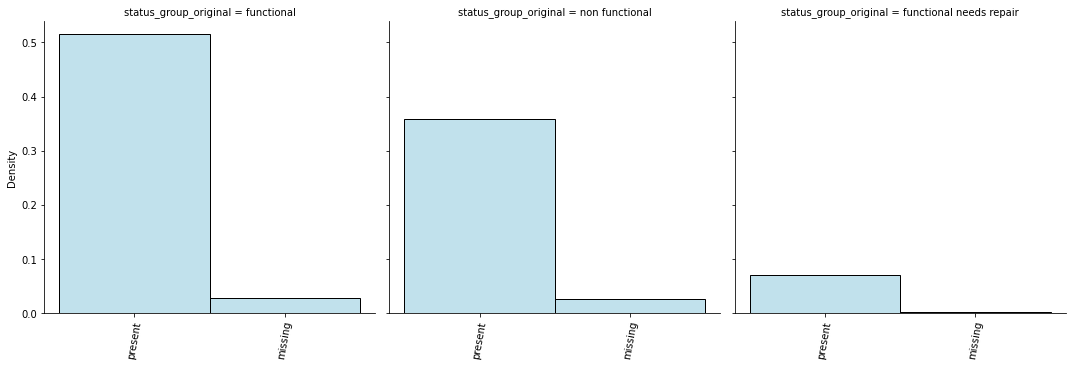

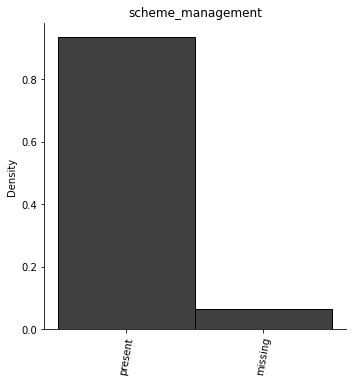

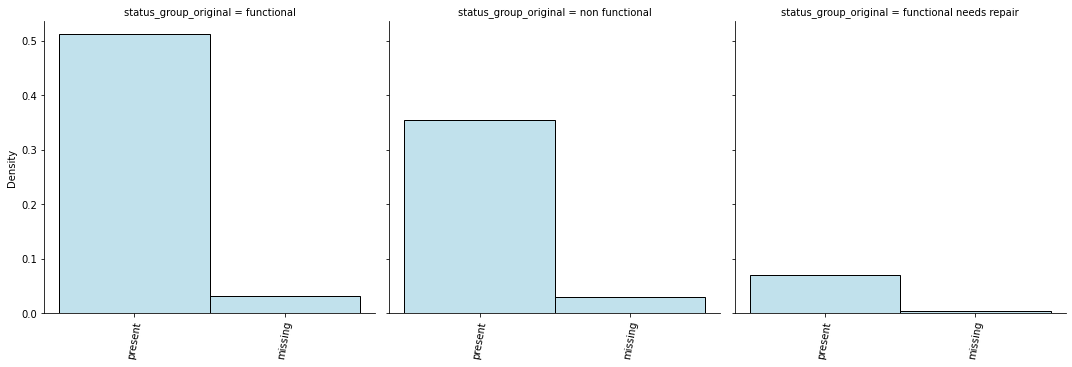

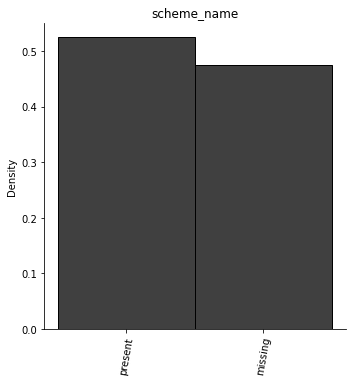

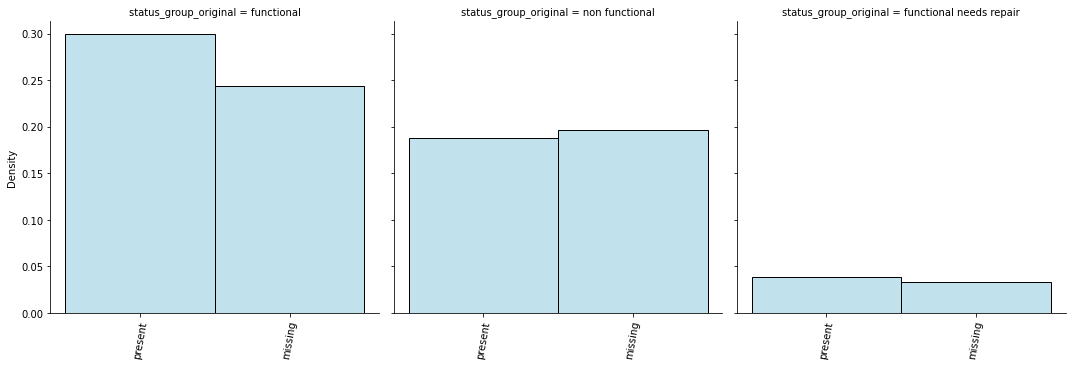

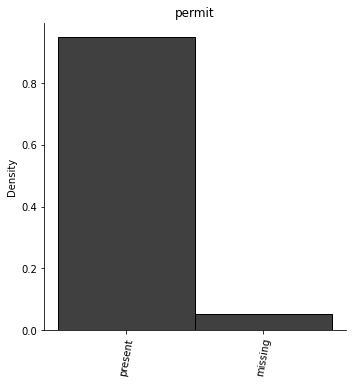

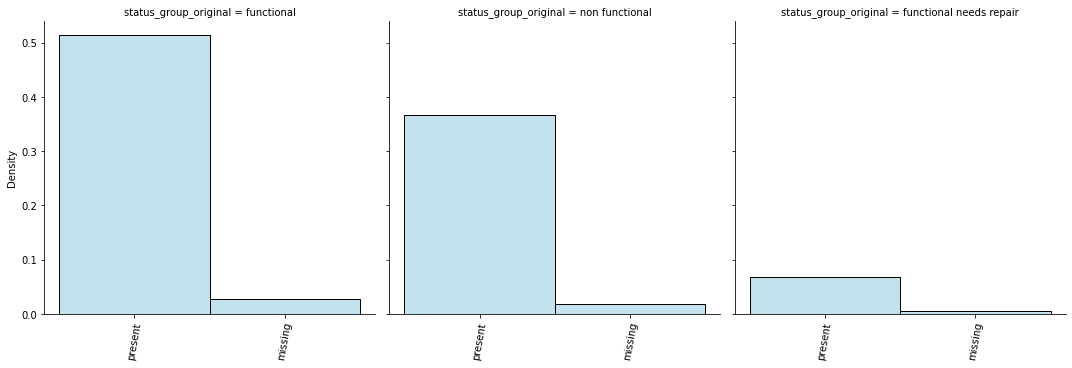

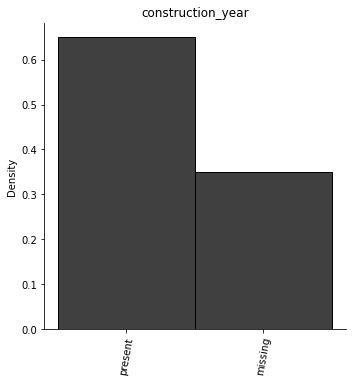

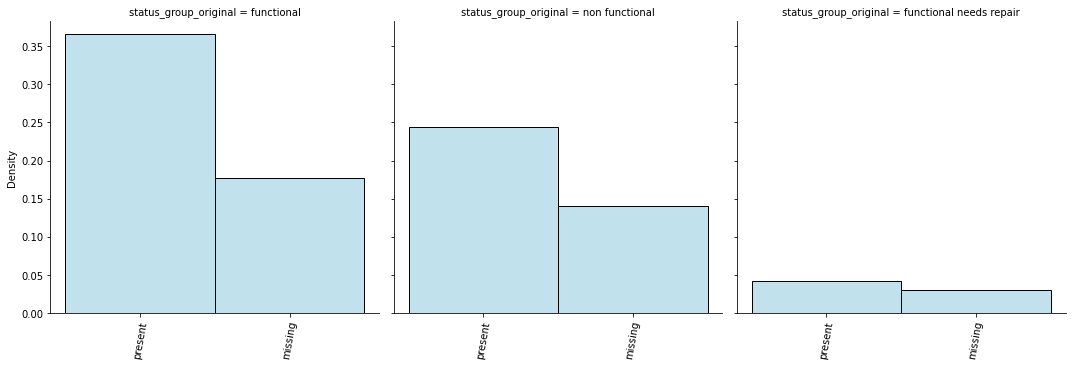

In [259]:
#apply boxplot function to list of features that contain missing values
missing_list = [c for c in missing if missing[c].str.contains('missing').any()]

for feature in missing_list:
  barplotter_missing(missing, feature)

#conclusion: I don't see a clear pattern for missingness and the status of waterpumps so I won't create any 'is_missing' features

Of all the features that contained missing data, it stands out that there is quite a bit more missing data in Amount_tsh for non-functional pumps than there is for functional pumps. Therefore I will include the missingness of amount_tsh as a feature.

In [644]:
#create missigness feature for amount_tsh
engineered['amount_tsh_missing'] = missing['amount_tsh']
engineered.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.2    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional       713.7    2013-01-28        Unicef         263   
4  19728      functional         0.2    2011-07-13   Action In A        2031   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population  public_meeting              recorded_by  \
0     Ludewa    Mundindi         109             1.0  GeoData Consultants Ltd   
1  Serengeti       Natta         280             0.0  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250             1.0  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58             1.0  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi         423             1.0  GeoData Consultants Ltd   

  scheme_management                  scheme_name  permit  construction_year  \
0               VWC                        Roman     0.0               1999   
1             Other                            K     1.0               2010   
2               VWC  Nyumba ya mungu pipe scheme     1.0               2009   
3               VWC                            K     1.0               1986   
4               VWC                            K     1.0               1999   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communa

####**4.1 High cardinality**

We have two features with high cardinalit but a fairly common mode. This feature is in itself not usefull, but perhabs we can still find some interesting patterns in it.

**Funder**

In [645]:
#governement of tanzania is by far the most common funder
engineered['funder'].value_counts()

Government Of Tanzania    15803
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
                          ...  
Icf                           1
Saboga Bise Makori            1
Hesswa                        1
Lg                            1
Bkhws                         1
Name: funder, Length: 2140, dtype: int64

In [646]:
#create binary features to indicate whether the house has a garage, basement or porch
engineered["funder_is_Government_Tanzania"] = engineered["funder"].apply(lambda x: 'True' if x =="Government Of Tanzania" else 'False')


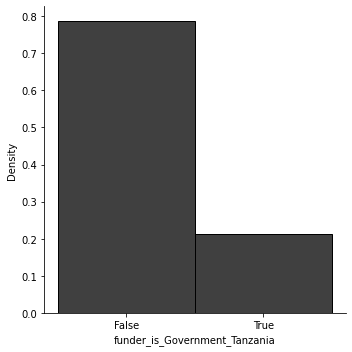

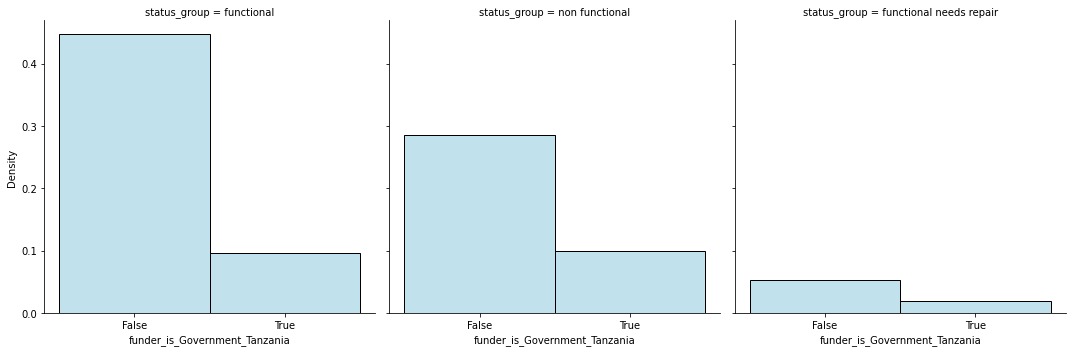

In [647]:
#the governemtn of Tanzania is a lot more often the funder of non-funtioning wells than in functional wells
ax1 = sns.displot(engineered, x = 'funder_is_Government_Tanzania',  stat = 'density', discrete = True, color = 'black')
ax2 = sns.displot(engineered, x = 'funder_is_Government_Tanzania',col = 'status_group', stat = 'density', discrete = True, color = 'lightblue')
plt.show()

**Installer**

In [648]:
#governement of tanzania is by far the most common funder
engineered['installer'].value_counts()

DWE                      26283
Government                2282
RWE                       1498
Commu                     1347
DANIDA                    1305
                         ...  
DEW                          1
Shule ya msingi ufala        1
RC Njoro                     1
Uwamalu                      1
EAGT Church                  1
Name: installer, Length: 2410, dtype: int64

In [649]:
#create binary features to indicate whether the house has a garage, basement or porch
engineered["installer_is_DWE"] = engineered["installer"].apply(lambda x: 'True' if x =="DWE" else 'False')


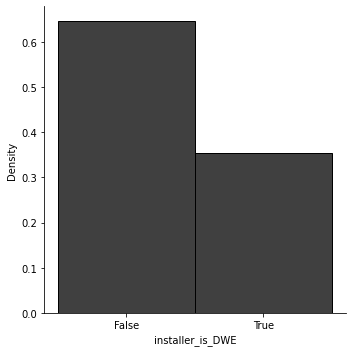

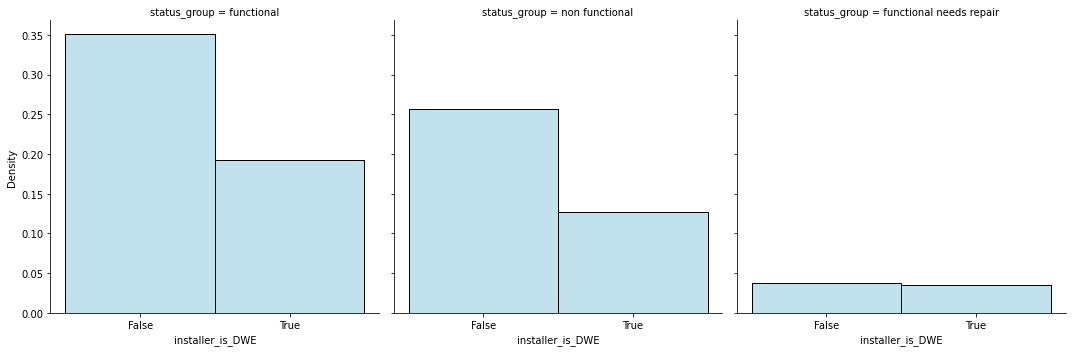

In [650]:

#there is no clear difference visible for wells installed by DWE or another party so we will drop this feature
ax1 = sns.displot(engineered, x = 'installer_is_DWE',  stat = 'density', discrete = True, color = 'black')
ax2 = sns.displot(engineered, x = 'installer_is_DWE',col = 'status_group', stat = 'density', discrete = True, color = 'lightblue')
plt.show()

In [651]:
#drop feature
engineered = engineered.drop("installer_is_DWE", axis=1)

####**4.3 Age well**

In [652]:
#in order to calculate the age of the well, we need to change the datatypes of construction_year and date_recorded
engineered['date_recorded_string'] = engineered['date_recorded'].str.replace('-','')
engineered['date_recorded_dt'] = pd.to_datetime(engineered['date_recorded_string'], format='%Y%m%d')
engineered['construction_year_dt'] = pd.to_datetime(engineered['construction_year'], format='%Y')

#calculate feature as timedelta
engineered['age_well_timedelta']= engineered['date_recorded_dt'] - engineered['construction_year_dt']

#convert timedelta to int
engineered['age_well_at_recording'] = (engineered['age_well_timedelta']/ np.timedelta64(1, 'Y')).astype(int)

#drop redundant features
engineered = engineered.drop(['date_recorded_string', 'date_recorded_dt', 'construction_year_dt', 'age_well_timedelta'], axis=1)

engineered.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.2    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional       713.7    2013-01-28        Unicef         263   
4  19728      functional         0.2    2011-07-13   Action In A        2031   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population  public_meeting              recorded_by  \
0     Ludewa    Mundindi         109             1.0  GeoData Consultants Ltd   
1  Serengeti       Natta         280             0.0  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250             1.0  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58             1.0  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi         423             1.0  GeoData Consultants Ltd   

  scheme_management                  scheme_name  permit  construction_year  \
0               VWC                        Roman     0.0               1999   
1             Other                            K     1.0               2010   
2               VWC  Nyumba ya mungu pipe scheme     1.0               2009   
3               VWC                            K     1.0               1986   
4               VWC                            K     1.0               1999   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communa

23


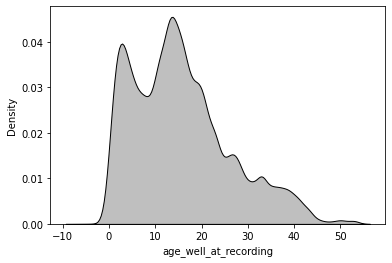

In [653]:
#there are some wells that have recorded dates that were recorded before they were actually build.
#this is probably the result of poor imputations, but we will fix it by chagning negative values to zero
wrong_date = engineered[engineered['age_well_at_recording']<0]
print(len(wrong_date))

#there is quite a big peak at age 0, so I will reset negative values to zero
sns.kdeplot(data = engineered, x ='age_well_at_recording',  shade = True, color  = "black" )

In [654]:
#replace negative values by zero
engineered['age_well_at_recording'] = engineered['age_well_at_recording'] .clip(lower=0)


In [655]:
engineered['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

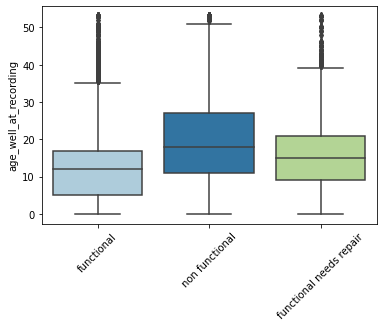

In [656]:
  #on average functional wells are a bit younger than non-functional wells
  ax =sns.boxplot(x = "status_group",  y="age_well_at_recording",  data = engineered, palette = "Paired")
  ax.set(xlabel = "")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.show()

####**4.4 population**

The boxplot and previous kde plot show that populaton has a problematic distribution. If we consider that any village that hase a population greater than  mean + 3 x stdev (i.e. 1.702 inhabitants), we would find 886towns. Only 7 towns have 10.000 or more inhabitants. I have no reason to believe that these are true outliers. I will deal with the skewed distribution and try to create a feature that will bin the population.b

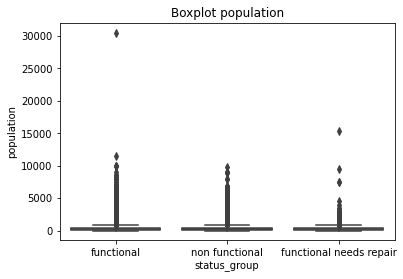

In [657]:
ax =sns.boxplot( x = 'status_group',  y="population",  data = engineered, palette = "Paired")
ax.set_title("Boxplot population")
plt.show()

In [658]:
#calculate mean, std and outlier (3xstd)
mean = engineered['population'].mean()
std = engineered['population'].std()
outlier = mean + 3* std
print(mean)
print(std)
print(outlier)

309.51785858585856
464.0969506398697
1701.8087105054678


In [659]:
#number of records with outlier population
outlier_population = engineered[engineered['population']>1702]
print(len(outlier_population))
print(len(raw['population']))

#number of records 10.000 or more inhabitants
outlier_population = engineered[engineered['population']>=10000]
print(len(outlier_population))

886
74250
7


In [660]:
#the easiest way to handle outliers is to use a clamp transformation. 
#One common way to calculate clamp trensholds is to set the lower treshold to the 1st quarltile value minus 1.5 times the IWR and the uper trenshold to the 3rd quarlitle plus 1.5 times the IWR
Q1 = engineered['population'].quantile(0.25)
Q3 = engineered['population'].quantile(0.75)
IQR = Q3-Q1
print(Q1)
print(Q3)
print(IQR)

#lower_boundary = Q1 - 1.5 * IQR # this resuls in a negative value, so we will only use an upper clamp
upper_boundary = Q3 + 1.5 * IQR
print(upper_boundary)

##number of records with outlier population (2.418 rows were clipped = 3% of data)
outlier_population = engineered[engineered['population']>upper_boundary]
print(len(outlier_population))
print(len(engineered))

86.0
412.0
326.0
901.0
2419
74250


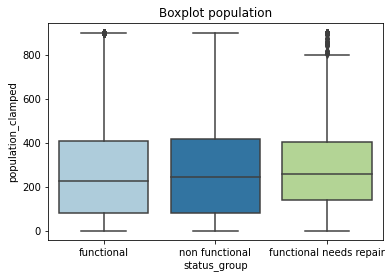

In [661]:
#apply upper clamp
engineered['population_clamped'] = engineered['population'] .clip(upper=upper_boundary)

#plot: note: clamping results in near identical population distributions for the different status_groups
ax =sns.boxplot( x = 'status_group',  y="population_clamped",  data = engineered, palette = "Paired")
ax.set_title("Boxplot population")
plt.show()


**Binning**

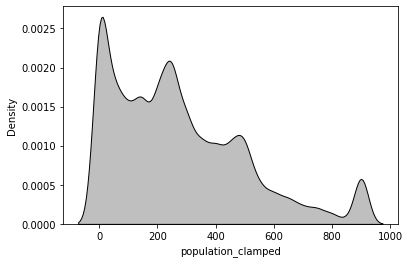

In [662]:

sns.kdeplot(data = engineered, x ='population_clamped',  shade = True, color  = "black" )

Because the distribution of age is highly skewed I will apply equal-frequency binning (i.e the binsize differs but each bin has the same number of datapoints). It doesn't matter if we use population of population_clamped because the outliers will fall in the last bin regardless. I will choose a relatively low number of bins because the population is overall quite low and it probably doesn't really matter if there are 40 or 140 people living in a town.

* bin 1: 0 - 40
* bin 2: 40 - 145
* bin 3: 145 - 200
* bin 4: 240 - 340
* bin 5: 340 - 495
* bin 6: 495 - 903

In [663]:
bin_labels = [1, 2, 3, 4, 5,6]
engineered['population_bin'] = pd.qcut(engineered['population_clamped'], q=6,  labels=bin_labels)


In [664]:
#each bin contains a very similar number of datapoints
engineered['population_bin'].value_counts()

1    12692
3    12554
6    12347
5    12293
4    12230
2    12134
Name: population_bin, dtype: int64

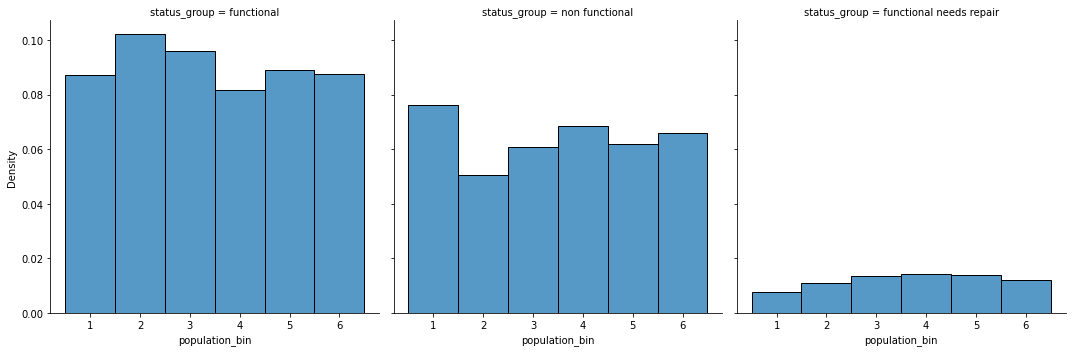

In [665]:
#we see some small differences in the distribution of population for the different status_groups
ax= sns.displot(engineered, x ='population_bin', stat = 'density', discrete = True, col = 'status_group')


####**4.5 Altitude**

Using just 5 bins already shows some nice differences between functional and non-functional pumps. non-fuctional pumps are more often found at lower altitudes.

* bin 1: 0 - 524 m
* bin 2: 524 - 1148 m
* bin 3: 1148 - 1341 m
* bin 4: 1341 - 1562 m
* bin 5: 1562 - 2777 m

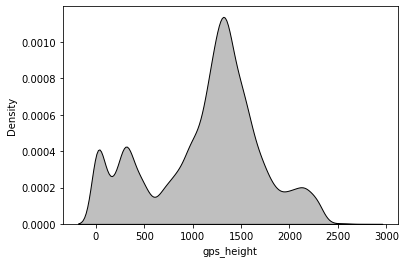

In [666]:

sns.kdeplot(data = engineered, x ='gps_height',  shade = True, color  = "black" )

In [667]:
bin_labels = [1, 2, 3, 4, 5]
engineered['gps_height_bin'] = pd.qcut(engineered['gps_height'], q=5,  labels=bin_labels)


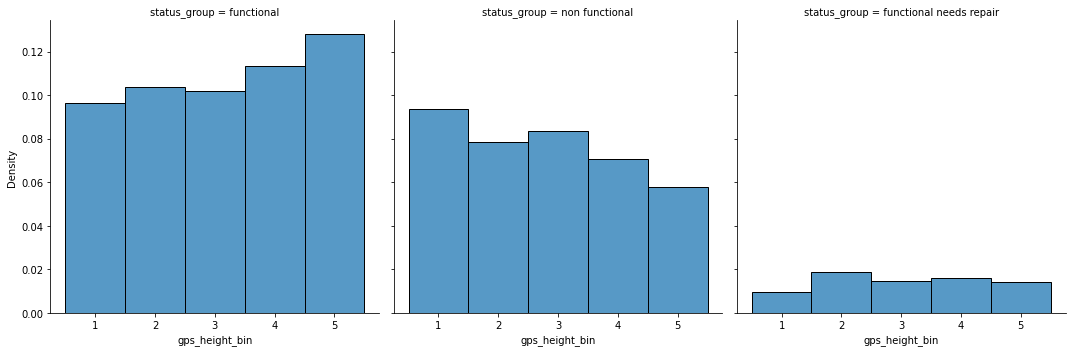

In [668]:
#we see some small differences in the distribution of population for the different status_groups
ax= sns.displot(engineered, x ='gps_height_bin', stat = 'density', discrete = True, col = 'status_group')


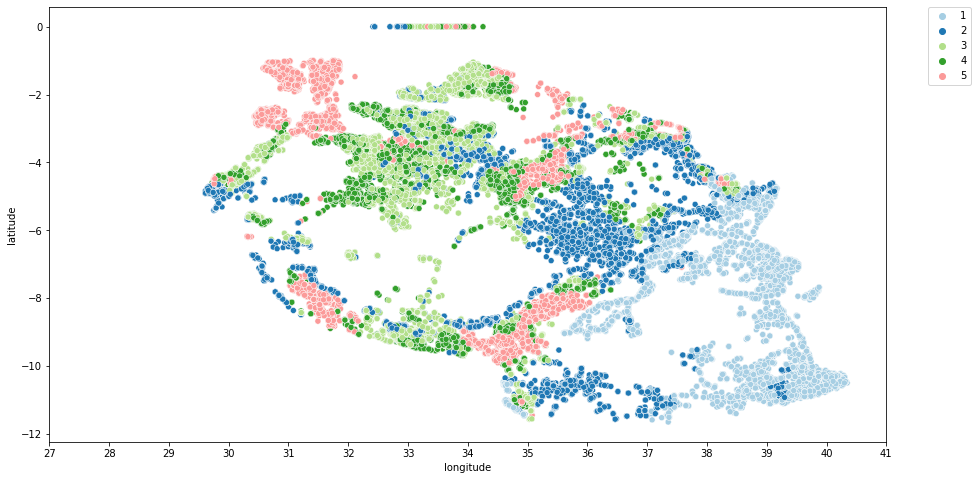

In [669]:
#plot the location 
plt.figure(figsize = (15,8))
ax = sns.scatterplot(x= engineered['longitude'], y = engineered['latitude'], hue = engineered['gps_height_bin'], palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticks(range(27 ,42))
#ax.set_yticks(range(0, -12))
plt.show()

**Change dtypes**

In [671]:
engineered[['num_private', 'region_code', 'district_code']] = engineered[['num_private', 'region_code', 'district_code']].astype('str')

engineered["funder_is_Government_Tanzania"]  = engineered["funder_is_Government_Tanzania"] .apply(lambda x: 1 if x == "True" else 0)
engineered["amount_tsh_missing"]  = engineered["amount_tsh_missing"]  .apply(lambda x: 1 if x == "True" else 0)

#save imputed df
#engineered.to_csv("engineered.csv")

#**5. Final Dataset 1**

* keep the correlated features
* no scaling or normalization
* coordinates raw
* no oversampling

In [673]:
df1= pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpumps/engineered.csv')
df1= df1.drop("Unnamed: 0", axis=1)
df1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.2    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional       713.7    2013-01-28        Unicef         263   
4  19728      functional         0.2    2011-07-13   Action In A        2031   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population  public_meeting              recorded_by  \
0     Ludewa    Mundindi         109             1.0  GeoData Consultants Ltd   
1  Serengeti       Natta         280             0.0  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250             1.0  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58             1.0  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi         423             1.0  GeoData Consultants Ltd   

  scheme_management                  scheme_name  permit  construction_year  \
0               VWC                        Roman     0.0               1999   
1             Other                            K     1.0               2010   
2               VWC  Nyumba ya mungu pipe scheme     1.0               2009   
3               VWC                            K     1.0               1986   
4               VWC                            K     1.0               1999   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communa

In [608]:
#high cardinality
['funder', 'installer', 'wpt_name', 'subvillage', 'lga',  'ward','scheme_name']

#low cardinality
['num_private', 'recorded_by', ]

#high percentage missing
['amount_tsh']

#correlation
['region','district_code' , 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']  #we will keep these for nhow because we don't know if we should keep the ones with the highest or lowest cardinality

#derrived features
['amount_tsh', 'date_recorded','construction_year', 'funder']

to_drop = ['amount_tsh', 'date_recorded','construction_year', 'funder', 'installer', 'wpt_name', 'num_private', 'subvillage', 'lga', 'ward', 'recorded_by' , 'scheme_name', 'population']

df1 = df1.drop(to_drop, axis=1)
df1.head()

id    status_group  gps_height  longitude  latitude  \
0  69572      functional      1390.0       35.0     -10.0   
1   8776      functional      1399.0       35.0      -2.0   
2  34310      functional       686.0       37.0      -4.0   
3  67743  non functional       263.0       38.0     -11.0   
4  19728      functional      2031.0       31.0      -2.0   

                     basin   region  region_code  district_code  \
0               Lake Nyasa   Iringa           11              5   
1            Lake Victoria     Mara           20              2   
2                  Pangani  Manyara           21              4   
3  Ruvuma / Southern Coast   Mtwara           90             63   
4            Lake Victoria   Kagera           18              1   

   public_meeting scheme_management  permit extraction_type  \
0             1.0               VWC     0.0         gravity   
1             0.0             Other     1.0         gravity   
2             1.0               VWC     1.0         gravity   
3             1.0               VWC     1.0     submersible   
4             1.0               VWC     1.0         gravity   

  extraction_type_group extraction_type_class management management_group  \
0               gravity               gravity        vwc       user-group   
1               gravity               gravity        wug       user-group   
2               gravity               gravity        vwc       user-group   
3           submersible           submersible        vwc       user-group   
4               gravity               gravity      other            other   

          payment payment_type water_quality quality_group      quantity  \
0    pay annually     annually          soft          good        enough   
1       never pay    never pay          soft          good  insufficient   
2  pay per bucket   per bucket          soft          good        enough   
3       never pay    never pay          soft          good           dry   
4       never pay    never pay          soft          good      seasonal   

  quantity_group                source           source_type source_class  \
0         enough                spring                spring  groundwater   
1   insufficient  rainwater harvesting  rainwater harvesting      surface   
2         enough                   dam                   dam      surface   
3            dry           machine dbh              borehole  groundwater   
4       seasonal  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group  amount_tsh_missing  \
0           communal standpipe    communal standpipe                   0   
1           communal standpipe    communal standpipe                   1   
2  communal standpipe multiple    communal standpipe                   0   
3  communal standpipe multiple    communal standpipe                   1   
4           communal standpipe    communal standpipe                   1   

   funder_is_Government_Tanzania  age_well_at_recording  population_clamped  \
0                              0                     12               109.0   
1                              0                      3               280.0   
2                              0                      4               250.0   
3                              0                     27                58.0   
4                              0                     11               423.0   

   population_bin  gps_height_bin  
0               2               4  
1               4               4  
2               4               2  
3               2               1  
4               5               5

In [609]:
#define train and test
df1_train = df1[df1["id"].isin(train_values["id"])]
df1_test =  df1[df1["id"].isin(test_values["id"])]
#df1_train.head()

In [610]:
#define X and y

X_raw = df1_train.drop(['id', 'status_group'], axis=1)
y = df1_train['status_group']

#create a list of all categorical features
categorical_cols = [cname for cname in X_raw.columns if
                    X_raw[cname].dtype == "object"]


# one hot encoding of low cardinality features encoded low_cardinality
ohe = pd.get_dummies(X_raw[categorical_cols])
 
# Concatenate one hot encoded features to full dataframe
X_ohe = pd.concat([X_raw, ohe], axis=1)


#create final X
X = X_ohe.drop(categorical_cols, axis=1)
X.head()

gps_height  longitude  latitude  region_code  district_code  \
0      1390.0       35.0     -10.0           11              5   
1      1399.0       35.0      -2.0           20              2   
2       686.0       37.0      -4.0           21              4   
3       263.0       38.0     -11.0           90             63   
4      2031.0       31.0      -2.0           18              1   

   public_meeting  permit  amount_tsh_missing  funder_is_Government_Tanzania  \
0             1.0     0.0                   0                              0   
1             0.0     1.0                   1                              0   
2             1.0     1.0                   0                              0   
3             1.0     1.0                   1                              0   
4             1.0     1.0                   1                              0   

   age_well_at_recording  population_clamped  population_bin  gps_height_bin  \
0                     12               109.0               2               4   
1                      3               280.0               4               4   
2                      4               250.0               4               2   
3                     27                58.0               2               1   
4                     11               423.0               5               5   

   basin_Internal  basin_Lake Nyasa  basin_Lake Rukwa  basin_Lake Tanganyika  \
0               0                 1                 0                      0   
1               0                 0                 0                      0   
2               0                 0                 0                      0   
3               0                 0                 0                      0   
4               0                 0                 0                      0   

   basin_Lake Victoria  basin_Pangani  basin_Rufiji  \
0                    0              0             0   
1                    1              0             0   
2                    0              1             0   
3                    0              0             0   
4                    1              0             0   

   basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  region_Arusha  \
0                              0                  0              0   
1                              0                  0              0   
2                              0                  0              0   
3                              1                  0              0   
4                              0                  0              0   

   region_Dar es Salaam  region_Dodoma  region_Iringa  region_Kagera  \
0                     0              0              1              0   
1                     0              0              0              0   
2                     0              0              0              0   
3                     0              0              0              0   
4                     0              0              0              1   

   region_Kigoma  region_Kilimanjaro  region_Lindi  region_Manyara  \
0              0                   0             0               0   
1              0                   0             0               0   
2              0                   0             0               1   
3              0                   0             0               0   
4              0                   0             0               0   

   region_Mara  region_Mbeya  region_Morogoro  region_Mtwara  region_Mwanza  \
0            0             0                0              0              0   
1            1             0                0              0              0   
2            0             0                0              0              0   
3            0             0                0              1              0   
4            0             0                0              0              0   

   region_Pwani  region_Rukwa  region_Ruvuma  region_Shinyanga  \
0             0 

In [611]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [674]:
#https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546

from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [683]:
test = df1.copy()

In [684]:
def find_nearest(lat, long):
    distances = test.apply(
        lambda row: dist(lat, long, row['latitude'], row['longitude']), 
        axis=1)
    return test.loc[distances.idxmin(), 'id']

In [ ]:
test['nearest_pump_id'] = test.apply(
    lambda row: find_nearest(row['latitude'], row['longitude']), 
    axis=1)
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
test.head()